# Install ptitprince and load libraries

In [1]:
!pip install ptitprince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 65.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ptitprince: filename=ptitprince-0.3.1-py3-none-any.whl size=16216 sha256=e3dfb22d38e63fe9a2ec1811aa619073a5ef0b26ce06ff590965839f073b2eb8
  Stored in directory: /root/.cache/pip/wheels/5d/79/49/b89a41fd3d8780ce2c21c7f2debe45f3c6b08d8aef400e3df1
Successfully built ptitprince


In [2]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 56.3 MB/s eta 0:00:00


#Get Data


combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv

In [3]:
!unzip /content/ne_110m_admin_0_countries.zip

Archive:  /content/ne_110m_admin_0_countries.zip
  inflating: ne_110m_admin_0_countries.README.html  
 extracting: ne_110m_admin_0_countries.VERSION.txt  
 extracting: ne_110m_admin_0_countries.cpg  
  inflating: ne_110m_admin_0_countries.dbf  
  inflating: ne_110m_admin_0_countries.prj  
  inflating: ne_110m_admin_0_countries.shp  
  inflating: ne_110m_admin_0_countries.shx  


# Dataset comparisons

/tmp/ipython-input-195757952.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


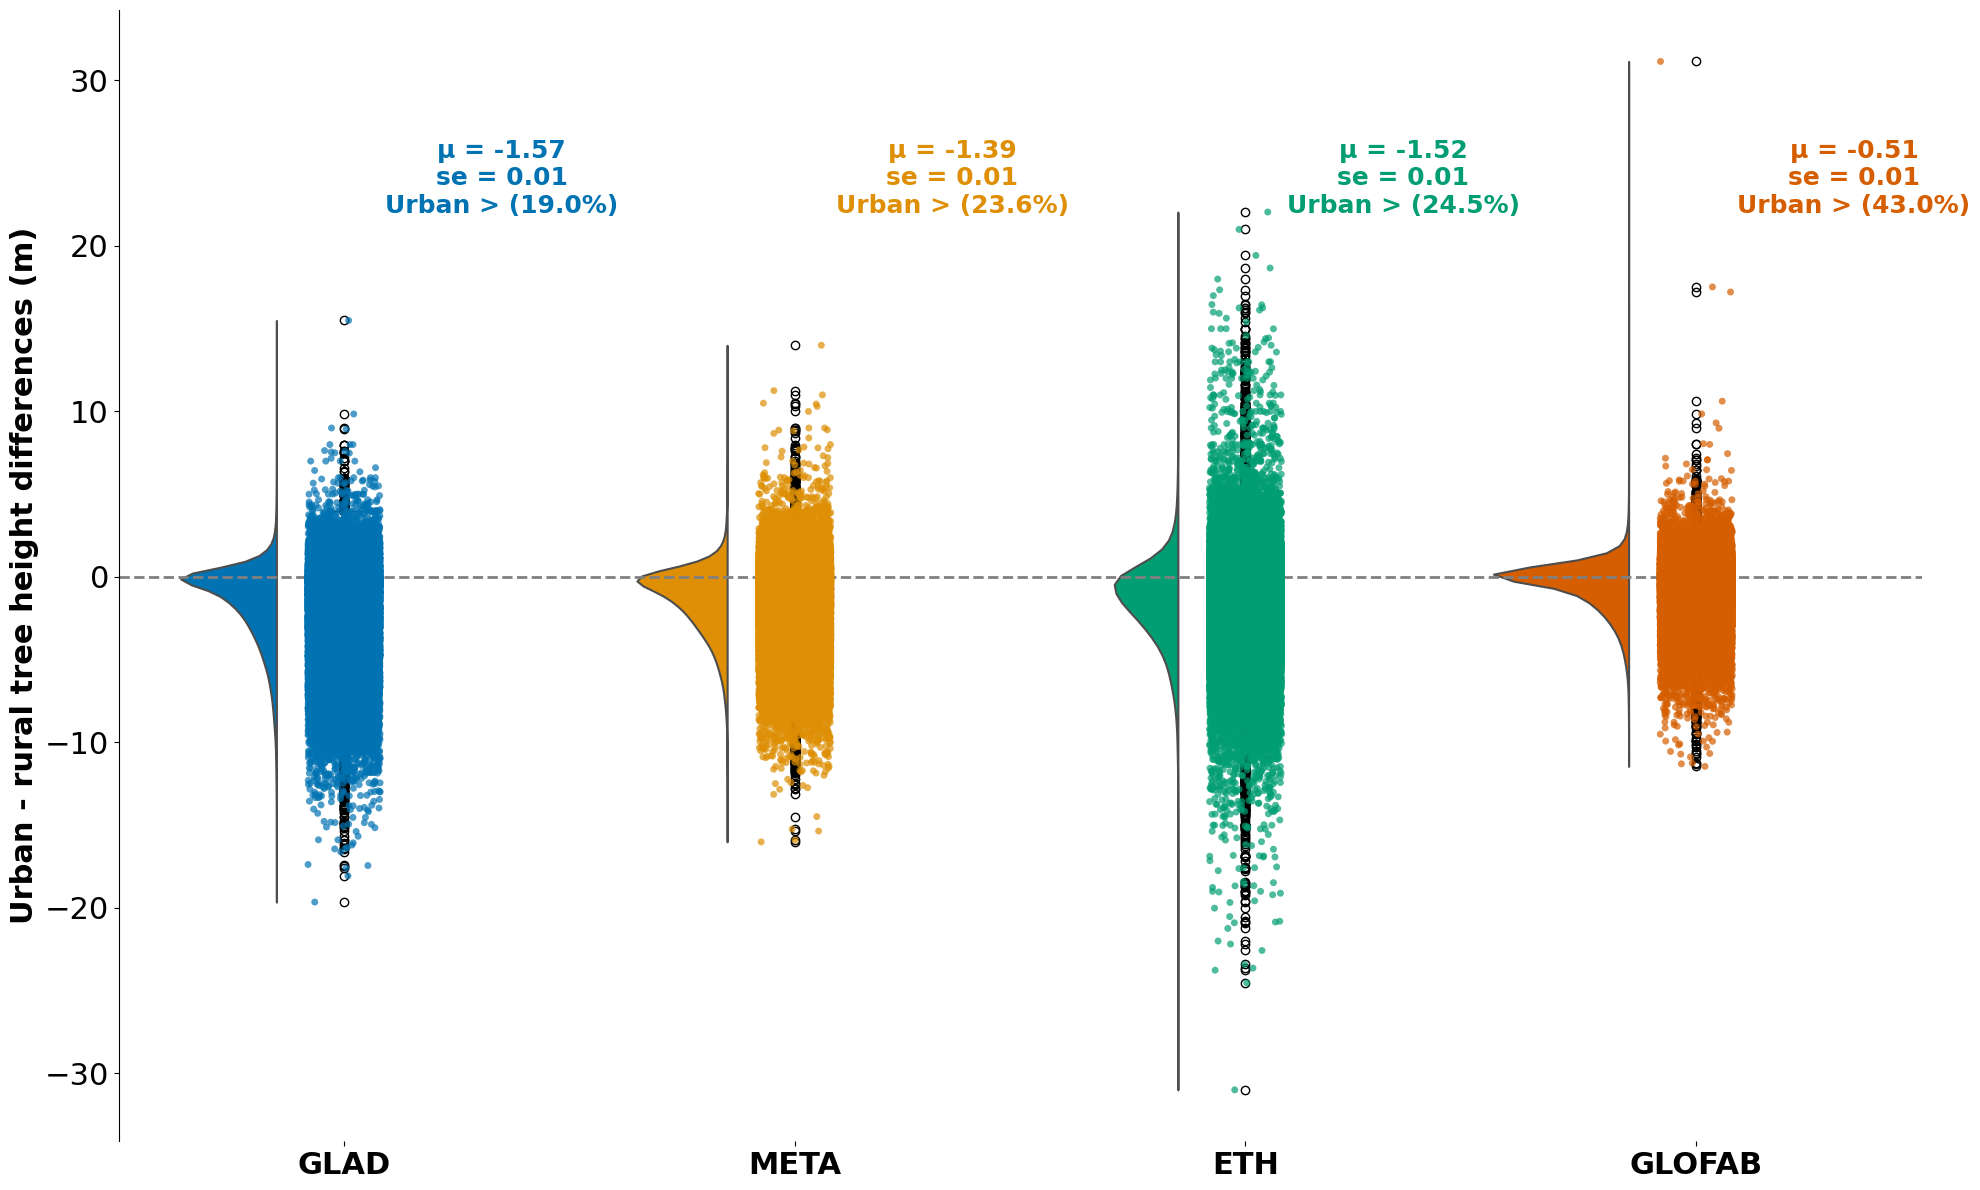

Source  Number of Samples  Mean Difference  Std Deviation  Standard Error  \
0    GLAD              82021            -1.57           2.32            0.01   
1    META              82021            -1.39           2.00            0.01   
2     ETH              82021            -1.52           2.52            0.01   
3  GLOFAB              82021            -0.51           1.49            0.01   

   Percentage Urban > Rural (%)  
0                         18.96  
1                         23.62  
2                         24.49  
3                         42.96

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from IPython.display import display

# Load the data with error handling
file_path = '/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv'
try:
    data = pd.read_csv(file_path)
    # data = data.nlargest(1000, 'Urban_Area')
except Exception as e:
    raise IOError(f"Error reading the CSV file: {e}")

# Validate necessary columns
required_columns = [
    'glad_mean_urban', 'glad_mean_rural',
    'meta_mean_urban', 'meta_mean_rural',
    'eth_mean_urban', 'eth_mean_rural',
    'glofab_mean_urban', 'glofab_mean_rural',
    'Urban_Area'
]
for column in required_columns:
    if column not in data.columns or data[column].isna().any():
        raise ValueError(f"Issue with column '{column}' (missing or NaNs).")

# Filter out rows with all zero values
non_zero_filter = (
    (data['glad_mean_urban'] != 0) | (data['glad_mean_rural'] != 0) |
    (data['meta_mean_urban'] != 0) | (data['meta_mean_rural'] != 0) |
    (data['eth_mean_urban'] != 0) | (data['eth_mean_rural'] != 0) |
    (data['glofab_mean_urban'] != 0) | (data['glofab_mean_rural'] != 0)
)
data = data[non_zero_filter].copy()

# Compute differences for each source
sources = ['GLAD', 'META', 'ETH', 'GLOFAB']
diff_cols = ['glad_diff', 'meta_diff', 'eth_diff', 'glofab_diff']
urban_cols = ['glad_mean_urban', 'meta_mean_urban', 'eth_mean_urban', 'glofab_mean_urban']
rural_cols = ['glad_mean_rural', 'meta_mean_rural', 'eth_mean_rural', 'glofab_mean_rural']

for diff, urban, rural in zip(diff_cols, urban_cols, rural_cols):
    data[diff] = data[urban] - data[rural]

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Source': np.repeat(sources, data.shape[0]),
    'Difference': pd.concat([data[col] for col in diff_cols], ignore_index=True)
})

# Set up a color-blind friendly palette
colors = sns.color_palette("colorblind", len(sources))

# Create enhanced RainCloud plot
plt.figure(figsize=(20, 12))
ax = plt.gca()

# RainCloud (Half Violin)
pt.half_violinplot(
    x='Source', y='Difference', data=plot_data, palette=colors, bw=.2,
    cut=0, scale="area", width=.6, inner=None, orient='v', ax=ax
)

# Boxplot overlay
sns.boxplot(
    x='Source', y='Difference', data=plot_data, width=.15,
    showcaps=True, boxprops={'facecolor':'none', 'linewidth':2},
    whiskerprops={'linewidth':2}, saturation=1, color='black', ax=ax
)

# Stripplot overlay (jittered points)
sns.stripplot(
    x='Source', y='Difference', data=plot_data, palette=colors,
    jitter=0.08, size=5, alpha=0.7, ax=ax
)

# Horizontal reference line at y=0 (This one is kept)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

plt.xlabel('', fontsize=22, fontweight='bold')
plt.xticks(fontsize=22, fontweight='bold')
plt.yticks(fontsize=22)
plt.ylabel('Urban - rural tree height differences (m)', fontsize=22, fontweight='bold')

# --- REMOVED GRID ---
# The plt.grid() line has been removed.

# --- MODIFIED ANNOTATION ---
# Annotate statistics beside each plot
for idx, (source, diff_col) in enumerate(zip(sources, diff_cols)):
    diff_data = data[diff_col]
    mean_val = diff_data.mean()
    std_dev = diff_data.std()
    n_samples = diff_data.count()
    std_error = std_dev / np.sqrt(n_samples)
    perc_urban_greater = (diff_data > 0).mean() * 100 # Calculate percentage

    # Updated annotation text to show percentage instead of std dev
    annotation_text = (
        f'μ = {mean_val:.2f}\n'
        f'se = {std_error:.2f}\n'
        f'Urban > ({perc_urban_greater:.1f}%)\n'
    )

    xpos = idx + 0.35
    ypos = 20

    plt.text(
        xpos, ypos, annotation_text, fontsize=18, fontweight='bold',
        horizontalalignment='center', verticalalignment='bottom',
        color=colors[idx]
    )

# --- MODIFIED BORDERS ---
# Remove plot borders, including the bottom x-axis line
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False) # This removes the x-axis line

plt.tight_layout()

plt.savefig('/content/Fig4_urban_rural_canopy_height_rainbow_ALL.pdf', dpi=300, bbox_inches='tight', format='pdf')



plt.show()

# Display statistics summary table (this remains unchanged)
stats_summary = {
    'Source': [],
    'Number of Samples': [],
    'Mean Difference': [],
    'Std Deviation': [],
    'Standard Error': [],
    'Percentage Urban > Rural (%)': []
}

for source, diff_col in zip(sources, diff_cols):
    diff_data = data[diff_col]
    n_samples = diff_data.count()
    mean_diff = diff_data.mean()
    std_diff = diff_data.std()
    std_error = std_diff / np.sqrt(n_samples)
    perc_urban_greater = (diff_data > 0).mean() * 100

    stats_summary['Source'].append(source)
    stats_summary['Number of Samples'].append(n_samples)
    stats_summary['Mean Difference'].append(mean_diff)
    stats_summary['Std Deviation'].append(std_diff)
    stats_summary['Standard Error'].append(std_error)
    stats_summary['Percentage Urban > Rural (%)'].append(perc_urban_greater)

stats_df = pd.DataFrame(stats_summary)
display(stats_df.round(2))

/tmp/ipython-input-2761393015.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


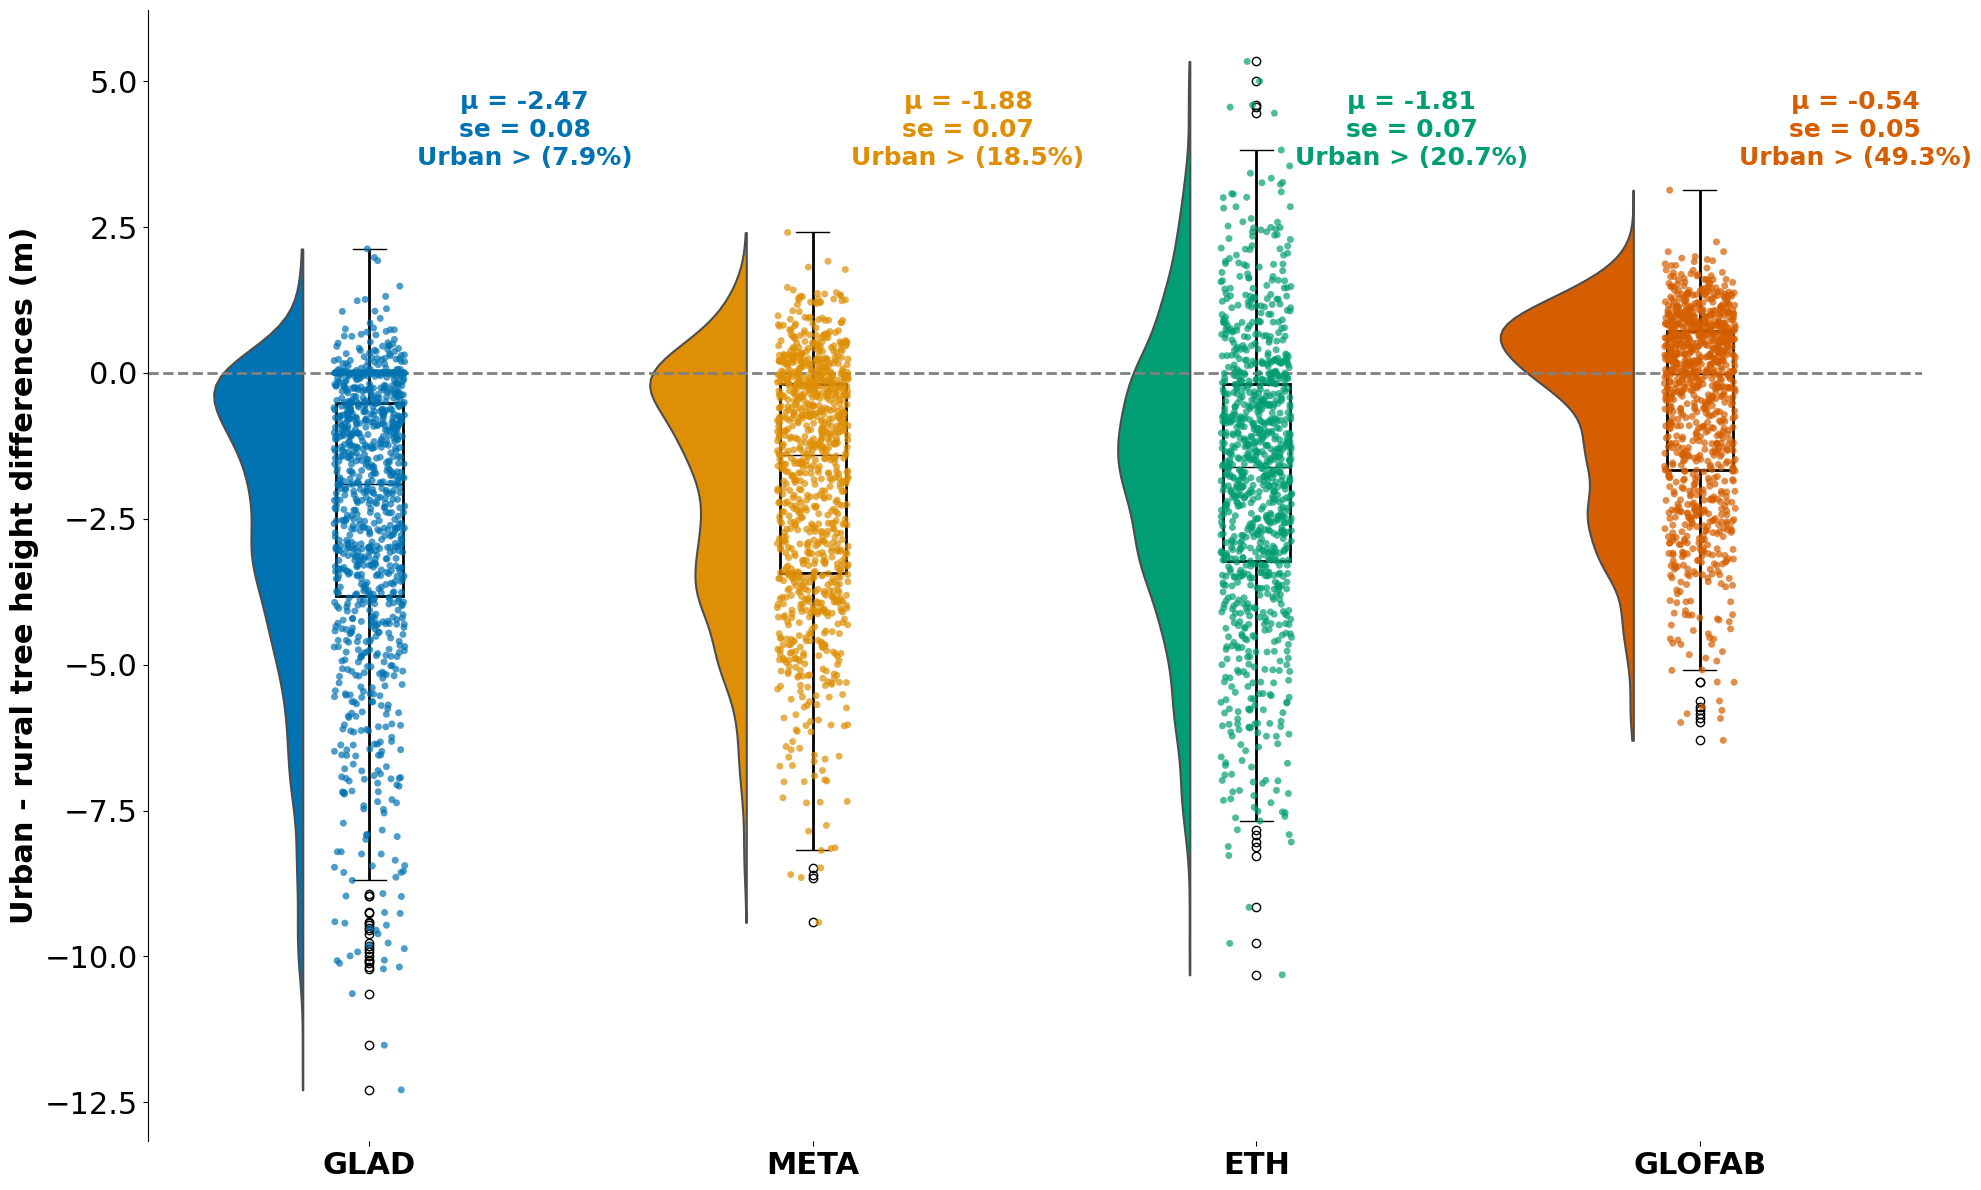

Source  Number of Samples  Mean Difference  Std Deviation  Standard Error  \
0    GLAD               1000            -2.47           2.46            0.08   
1    META               1000            -1.88           2.07            0.07   
2     ETH               1000            -1.81           2.36            0.07   
3  GLOFAB               1000            -0.54           1.65            0.05   

   Percentage Urban > Rural (%)  
0                           7.9  
1                          18.5  
2                          20.7  
3                          49.3

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from IPython.display import display

# Load the data with error handling
file_path = '/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv'
try:
    data = pd.read_csv(file_path)
    data = data.nlargest(1000, 'Urban_Area')
except Exception as e:
    raise IOError(f"Error reading the CSV file: {e}")

# Validate necessary columns
required_columns = [
    'glad_mean_urban', 'glad_mean_rural',
    'meta_mean_urban', 'meta_mean_rural',
    'eth_mean_urban', 'eth_mean_rural',
    'glofab_mean_urban', 'glofab_mean_rural',
    'Urban_Area'
]
for column in required_columns:
    if column not in data.columns or data[column].isna().any():
        raise ValueError(f"Issue with column '{column}' (missing or NaNs).")

# Filter out rows with all zero values
non_zero_filter = (
    (data['glad_mean_urban'] != 0) | (data['glad_mean_rural'] != 0) |
    (data['meta_mean_urban'] != 0) | (data['meta_mean_rural'] != 0) |
    (data['eth_mean_urban'] != 0) | (data['eth_mean_rural'] != 0) |
    (data['glofab_mean_urban'] != 0) | (data['glofab_mean_rural'] != 0)
)
data = data[non_zero_filter].copy()

# Compute differences for each source
sources = ['GLAD', 'META', 'ETH', 'GLOFAB']
diff_cols = ['glad_diff', 'meta_diff', 'eth_diff', 'glofab_diff']
urban_cols = ['glad_mean_urban', 'meta_mean_urban', 'eth_mean_urban', 'glofab_mean_urban']
rural_cols = ['glad_mean_rural', 'meta_mean_rural', 'eth_mean_rural', 'glofab_mean_rural']

for diff, urban, rural in zip(diff_cols, urban_cols, rural_cols):
    data[diff] = data[urban] - data[rural]

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Source': np.repeat(sources, data.shape[0]),
    'Difference': pd.concat([data[col] for col in diff_cols], ignore_index=True)
})

# Set up a color-blind friendly palette
colors = sns.color_palette("colorblind", len(sources))

# Create enhanced RainCloud plot
plt.figure(figsize=(20, 12))
ax = plt.gca()

# RainCloud (Half Violin)
pt.half_violinplot(
    x='Source', y='Difference', data=plot_data, palette=colors, bw=.2,
    cut=0, scale="area", width=.6, inner=None, orient='v', ax=ax
)

# Boxplot overlay
sns.boxplot(
    x='Source', y='Difference', data=plot_data, width=.15,
    showcaps=True, boxprops={'facecolor':'none', 'linewidth':2},
    whiskerprops={'linewidth':2}, saturation=1, color='black', ax=ax
)

# Stripplot overlay (jittered points)
sns.stripplot(
    x='Source', y='Difference', data=plot_data, palette=colors,
    jitter=0.08, size=5, alpha=0.7, ax=ax
)

# Horizontal reference line at y=0 (This one is kept)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

plt.xlabel('', fontsize=22, fontweight='bold')
plt.xticks(fontsize=22, fontweight='bold')
plt.yticks(fontsize=22)
plt.ylabel('Urban - rural tree height differences (m)', fontsize=22, fontweight='bold')

# --- REMOVED GRID ---
# The plt.grid() line has been removed.

# --- MODIFIED ANNOTATION ---
# Annotate statistics beside each plot
for idx, (source, diff_col) in enumerate(zip(sources, diff_cols)):
    diff_data = data[diff_col]
    mean_val = diff_data.mean()
    std_dev = diff_data.std()
    n_samples = diff_data.count()
    std_error = std_dev / np.sqrt(n_samples)
    perc_urban_greater = (diff_data > 0).mean() * 100 # Calculate percentage

    # Updated annotation text to show percentage instead of std dev
    annotation_text = (
        f'μ = {mean_val:.2f}\n'
        f'se = {std_error:.2f}\n'
        f'Urban > ({perc_urban_greater:.1f}%)\n'
    )

    xpos = idx + 0.35
    ypos = 3

    plt.text(
        xpos, ypos, annotation_text, fontsize=18, fontweight='bold',
        horizontalalignment='center', verticalalignment='bottom',
        color=colors[idx]
    )

# --- MODIFIED BORDERS ---
# Remove plot borders, including the bottom x-axis line
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False) # This removes the x-axis line

plt.tight_layout()
plt.savefig('/content/Fig4_urban_rural_canopy_height_rainbow_top1000.pdf', dpi=300, bbox_inches='tight', format='pdf')

plt.show()

# Display statistics summary table (this remains unchanged)
stats_summary = {
    'Source': [],
    'Number of Samples': [],
    'Mean Difference': [],
    'Std Deviation': [],
    'Standard Error': [],
    'Percentage Urban > Rural (%)': []
}

for source, diff_col in zip(sources, diff_cols):
    diff_data = data[diff_col]
    n_samples = diff_data.count()
    mean_diff = diff_data.mean()
    std_diff = diff_data.std()
    std_error = std_diff / np.sqrt(n_samples)
    perc_urban_greater = (diff_data > 0).mean() * 100

    stats_summary['Source'].append(source)
    stats_summary['Number of Samples'].append(n_samples)
    stats_summary['Mean Difference'].append(mean_diff)
    stats_summary['Std Deviation'].append(std_diff)
    stats_summary['Standard Error'].append(std_error)
    stats_summary['Percentage Urban > Rural (%)'].append(perc_urban_greater)

stats_df = pd.DataFrame(stats_summary)
display(stats_df.round(2))

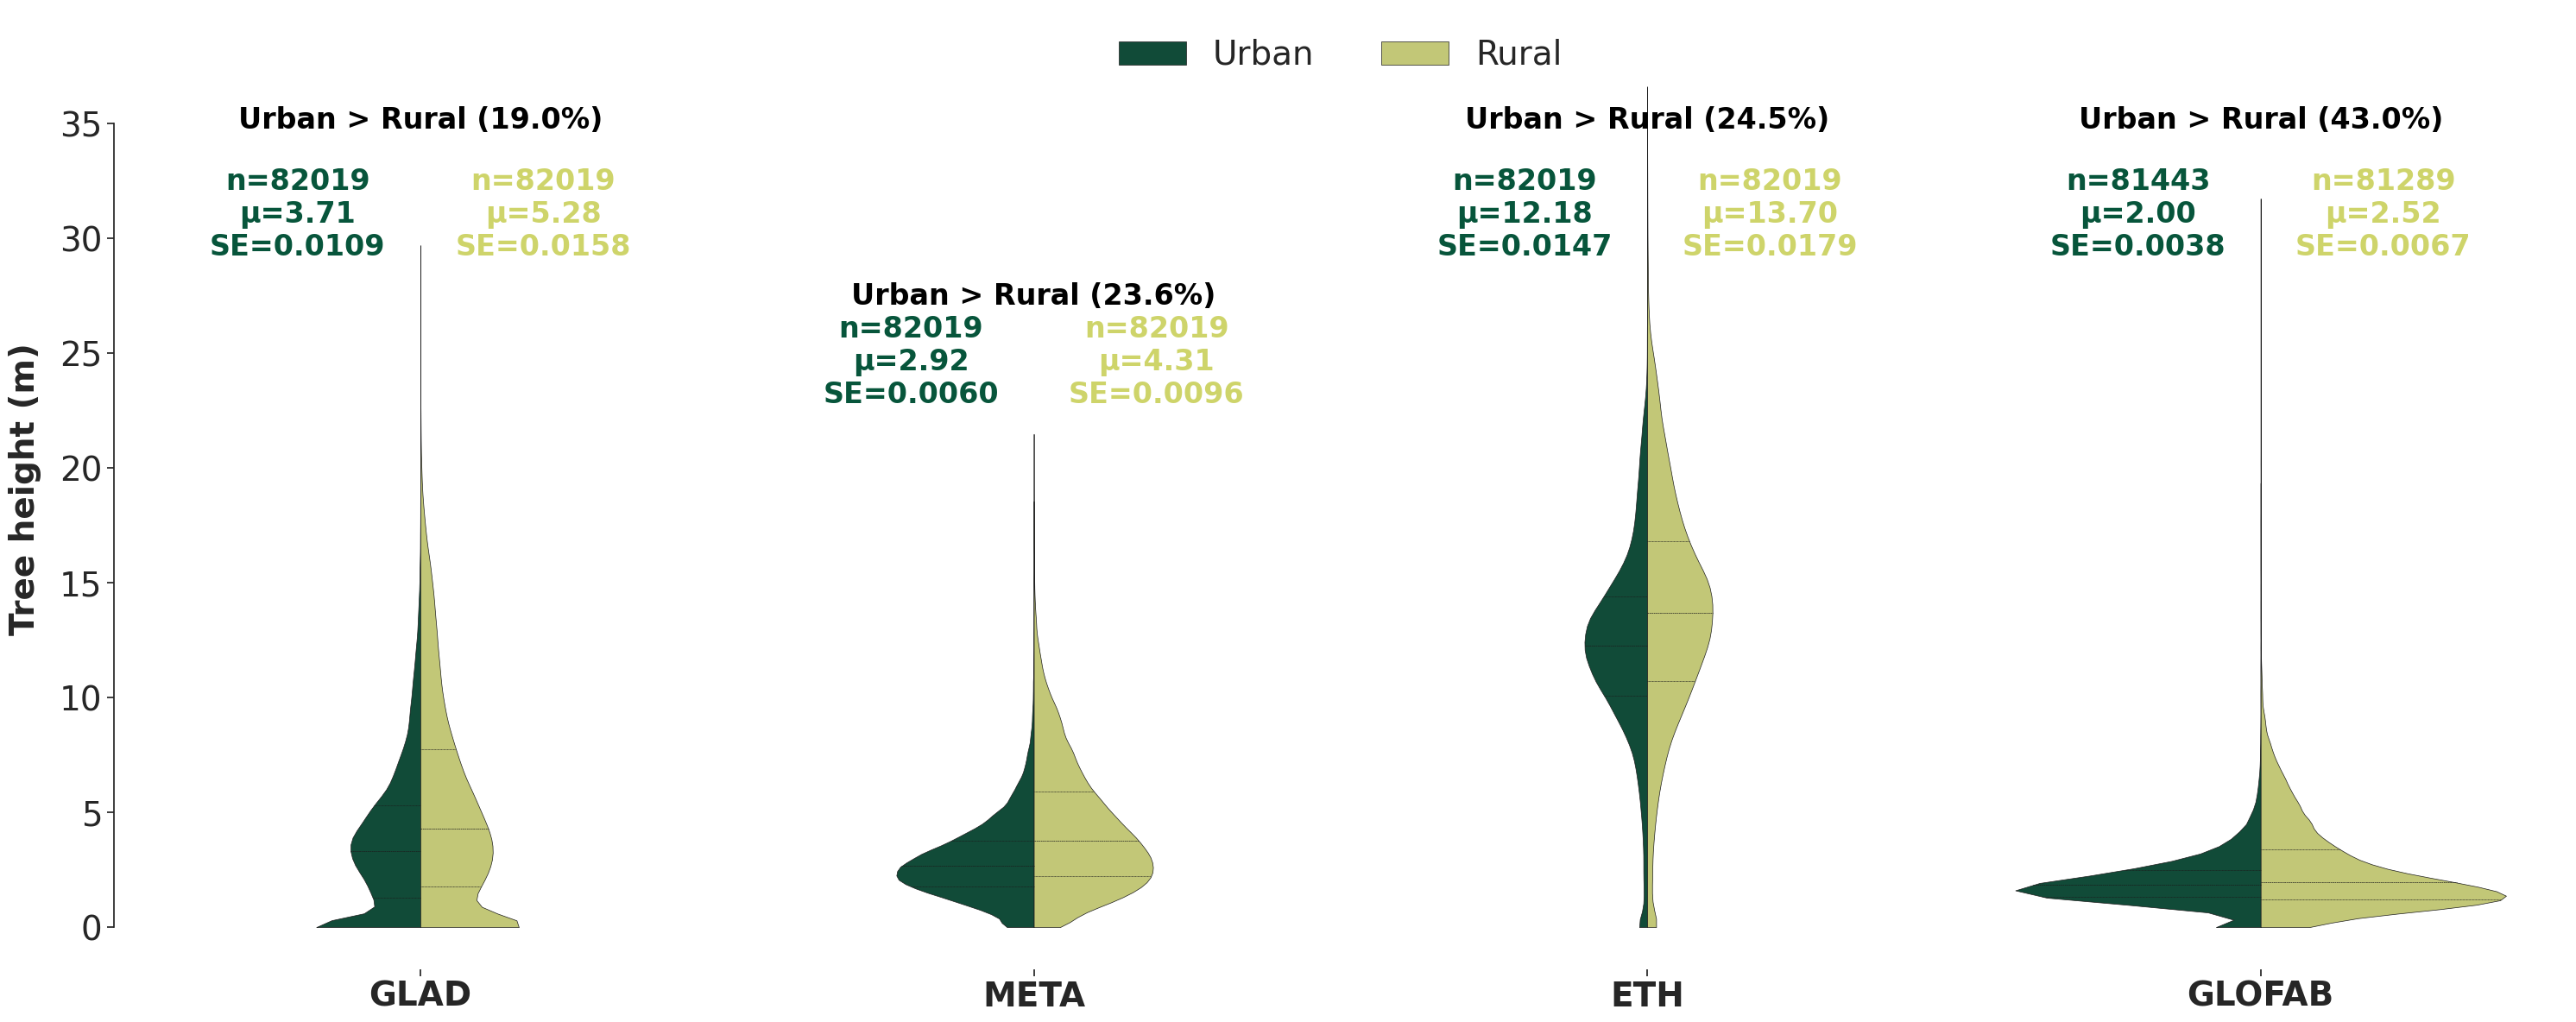

Source  Number of Urban Samples  Mean Urban Canopy Height  SE Urban  \
0    GLAD                    82019                  3.710013  0.010871   
1    META                    82019                  2.917110  0.005952   
2     ETH                    82019                 12.178128  0.014711   
3  GLOFAB                    81443                  2.004369  0.003836   

   Number of Rural Samples  Mean Rural Canopy Height  SE Rural  \
0                    82019                  5.275300  0.015768   
1                    82019                  4.311939  0.009640   
2                    82019                 13.700091  0.017850   
3                    81289                  2.523843  0.006699   

   Urban > Rural (%)  
0          18.957802  
1          23.622575  
2          24.488228  
3          42.955900

In [6]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ---------------------------- Config & I/O ----------------------------
# Please update this file path to the location of your CSV file.
file_path = '/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

try:
    data = pd.read_csv(file_path)
except Exception as e:
    raise RuntimeError(f"Error reading CSV file: {e}")

# Required columns
required_columns = [
    'glad_mean_urban', 'glad_mean_rural',
    'meta_mean_urban', 'meta_mean_rural',
    'eth_mean_urban',  'eth_mean_rural',
    'glofab_mean_urban','glofab_mean_rural'
]
for col in required_columns:
    if col not in data.columns:
        raise ValueError(f"Column '{col}' is not found in the data.")
    if data[col].isna().any():
        raise ValueError(f"Column '{col}' contains NaN values; please address these before proceeding.")

# ---------------------------- Filtering ----------------------------
# Keep rows with at least one positive canopy height value
non_zero_filter = (
    (data['glad_mean_urban'] > 0)  | (data['glad_mean_rural'] > 0)  |
    (data['meta_mean_urban'] > 0)  | (data['meta_mean_rural'] > 0)  |
    (data['eth_mean_urban']  > 0)  | (data['eth_mean_rural']  > 0)  |
    (data['glofab_mean_urban']> 0) | (data['glofab_mean_rural']> 0)
)
data = data[non_zero_filter].copy()
if data.empty:
    raise ValueError("After filtering, no rows remain with positive canopy height values.")

# ---------------------------- Reshaping ----------------------------
urban_cols   = ['glad_mean_urban', 'meta_mean_urban', 'eth_mean_urban', 'glofab_mean_urban']
rural_cols   = ['glad_mean_rural', 'meta_mean_rural', 'eth_mean_rural', 'glofab_mean_rural']
source_order = ['GLAD', 'META', 'ETH', 'GLOFAB']

# Urban > Rural % (calculated for the summary table)
urban_greater_than_rural_pct = {}
for source, u_col, r_col in zip(source_order, urban_cols, rural_cols):
    pct = (data[u_col] > data[r_col]).mean() * 100.0
    urban_greater_than_rural_pct[source] = pct

# Melt data for plotting
urban_melt = pd.melt(data, value_vars=urban_cols, var_name='variable', value_name='Canopy Height')
urban_melt['Area Type'] = 'Urban'
urban_melt['Source'] = urban_melt['variable'].str.replace('_mean_urban', '', regex=False).str.upper()

rural_melt = pd.melt(data, value_vars=rural_cols, var_name='variable', value_name='Canopy Height')
rural_melt['Area Type'] = 'Rural'
rural_melt['Source'] = rural_melt['variable'].str.replace('_mean_rural', '', regex=False).str.upper()

plot_data = pd.concat([urban_melt, rural_melt], ignore_index=True)
# Keep non-negative for plotting
plot_data = plot_data[plot_data['Canopy Height'] >= 0].copy()
if plot_data.empty:
    raise ValueError("No non-negative canopy heights remain for plotting after filtering.")

# ---------------------------- Plot ----------------------------
# Use a style with no background grid
sns.set_theme(style="ticks")

plt.figure(figsize=(30, 12))
ax = sns.violinplot(
    x='Source', y='Canopy Height', hue='Area Type', data=plot_data,
    split=True, inner="quartile", cut=0, order=source_order,
    palette={'Urban': '#07553B', 'Rural': '#CED46A'},
    linewidth=0.5
)

# ----- Remove ALL grid lines -----
# (Seaborn's 'ticks' style doesn't add grids, but we force-disable anyway)
ax.grid(False)                 # turn off major grid
ax.set_axisbelow(False)        # ensure nothing sneaks under
ax.minorticks_off()            # disable minor ticks (and potential minor grids)
# Do NOT call plt.grid(...) anywhere

plt.title('', fontsize=28, fontweight='bold')
plt.xlabel('', fontsize=28, labelpad=15)
plt.ylabel('Tree height (m)', fontsize=28, labelpad=15, fontweight='bold')
plt.xticks(fontsize=28, fontweight='bold')
plt.yticks(fontsize=28)
plt.legend(title='', fontsize=28, title_fontsize=28, loc='upper center', ncol=2, frameon=False)
sns.despine(trim=True, bottom=True)

# Set a hard limit for the y-axis to ensure annotations fit
ax.set_ylim(top=40)

# ---------------------------- Stats (with SE) ----------------------------
# Group stats per (Source, Area Type)
group_stats = (
    plot_data
    .groupby(['Source', 'Area Type'], as_index=False)
    .agg(
        n=('Canopy Height', 'count'),
        mean=('Canopy Height', 'mean'),
        std=('Canopy Height', 'std'),
        y_max=('Canopy Height', 'max')
    )
)

# Compute SE = std / sqrt(n); guard against n<=1
group_stats['se'] = group_stats.apply(
    lambda r: (r['std'] / math.sqrt(r['n'])) if (pd.notnull(r['std']) and r['n'] > 1) else float('nan'), axis=1
)

# Annotation positions
x_offsets = {'Urban': -0.2, 'Rural': +0.2}
color_map = {'Urban': '#07553B', 'Rural': '#CED46A'}

source_y_max = (
    plot_data.groupby('Source')['Canopy Height'].max().reindex(source_order).fillna(0.0)
)

# Add per-group annotations: stats and Urban > Rural percentage
for i, src in enumerate(source_order):
    # --- Position calculation for this source ---
    y_max_for_source = source_y_max.get(src, 0)

    # Define desired vertical positions relative to the data's max height
    y_stats_pos = y_max_for_source + 0.05 * max(1.0, y_max_for_source)
    y_pct_pos = y_max_for_source + 0.25 * max(1.0, y_max_for_source) # Position for percentage text

    # If the top annotation goes above our ceiling (34.5m), scale both down.
    if y_pct_pos > 34.5:
        scale = 34.5 / y_pct_pos
        y_pct_pos *= scale
        y_stats_pos *= scale

    # --- Add "Urban > Rural (%)" annotation ---
    pct = urban_greater_than_rural_pct.get(src, 0.0)
    plt.text(
        i, y_pct_pos, f"Urban > Rural ({pct:.1f}%)",
        ha='center', va='bottom', fontsize=24, fontweight='bold', color='black'
    )

    # --- Add per-group stats (n, mu, se) annotations ---
    for typ in ['Urban', 'Rural']:
        row_filter = (group_stats['Source'] == src) & (group_stats['Area Type'] == typ)
        if not group_stats[row_filter].empty:
            row = group_stats[row_filter].iloc[0]
            x = i + x_offsets.get(typ, 0.0)

            mu = row['mean']
            se = row['se']
            n  = int(row['n'])

            if pd.notnull(se):
                annotation = f"n={n}\nμ={mu:.2f}\nSE={se:.4f}"
            else:
                annotation = f"n={n}\nμ={mu:.2f}\nSE=NA"

            plt.text(
                x, y_stats_pos, annotation, ha='center', va='bottom',
                fontsize=24, fontweight='bold', color=color_map[typ]
            )

# ---------------------------- Save and Show Plot ----------------------------
plt.tight_layout()
# Please update this output path if needed.
out_plot = '/content/EDFig7C.pdf'
os.makedirs(os.path.dirname(out_plot), exist_ok=True)
plt.savefig(out_plot, dpi=300, bbox_inches='tight', format='pdf')
plt.show()

# ---------------------------- Source-level Summary Table ----------------------------
# For the table, compute per-source stats for Urban and Rural separately with SE
def _se(series: pd.Series) -> float:
    s = series.dropna()
    n = len(s)
    if n <= 1:
        return float('nan')
    return s.std(ddof=1) / math.sqrt(n)

table_rows = []
for src, u_col, r_col in zip(source_order, urban_cols, rural_cols):
    u = data.loc[data[u_col] >= 0, u_col]
    r = data.loc[data[r_col] >= 0, r_col]

    table_rows.append({
        'Source': src,
        'Number of Urban Samples': int(u.shape[0]),
        'Mean Urban Canopy Height': u.mean(),
        'SE Urban': _se(u),

        'Number of Rural Samples': int(r.shape[0]),
        'Mean Rural Canopy Height': r.mean(),
        'SE Rural': _se(r),

        'Urban > Rural (%)': urban_greater_than_rural_pct.get(src, 0.0)
    })

source_stats_df = pd.DataFrame(table_rows)
display(source_stats_df)


# Maps

###urban city

In [7]:
from __future__ import annotations
import math
import re
import sys
from pathlib import Path
from typing import Tuple, Optional, Dict

import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

# ────────────────────────── CONFIG ──────────────────────────

CSV_PATH = Path("/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv")
TOP_N = 1000

VARIABLE_LABEL = "Tree height"

# ────────────────────────── COL RESOLUTION ──────────────────────────

def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).strip().lower())

def resolve_column(
    df: pd.DataFrame,
    candidates,
    *,
    required: bool = True,
    label: str = ""
) -> Optional[str]:
    """
    Case/underscore/space-insensitive resolver with substring fallback.
    """
    if isinstance(candidates, str):
        candidates = [candidates]

    lut = {_norm(c): c for c in df.columns}

    # Exact normalized
    for cand in candidates:
        k = _norm(cand)
        if k in lut:
            return lut[k]

    # Fuzzy contains
    for c in df.columns:
        nc = _norm(c)
        for cand in candidates:
            if _norm(cand) in nc:
                return c

    if required:
        raise KeyError(
            f"Required column not found for {label or candidates}: "
            f"none of {candidates!r} matched. "
            f"Columns present (first 30): {df.columns[:30].tolist()}"
        )
    return None

def choose_columns(df: pd.DataFrame) -> Tuple[str, str, str, str, Optional[str]]:
    """
    Resolve:
      - H_urban, H_rural
      - tree_cover_area_urban, tree_cover_area_rural
      - Urban_Area (for TOP_N selection)
    """
    h_u = resolve_column(
        df,
        ["meta_mean_urban", "glad_mean_urban", "eth_mean_urban", "glofab_mean_urban"],
        label="Urban tree height (mean)",
    )
    h_r = resolve_column(
        df,
        ["meta_mean_rural", "glad_mean_rural", "eth_mean_rural", "glofab_mean_rural"],
        label="Rural tree height (mean)",
    )
    tcu = resolve_column(df, "tree_cover_area_urban", label="tree_cover_area_urban")
    tcr = resolve_column(df, "tree_cover_area_rural", label="tree_cover_area_rural")
    ua  = resolve_column(df, "Urban_Area", required=False, label="Urban_Area (for Top 1000)")
    return h_u, h_r, tcu, tcr, ua

# ────────────────────────── HELPERS ──────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _unweighted_mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = pd.to_numeric(x, errors="coerce").dropna()
    n = int(x.size)
    if n == 0:
        return (np.nan, np.nan, 0)
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return mu, se, n

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    """
    Kish-style SE for a weighted mean:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x - μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ(w^2)
      SE    = sqrt(Var_w / n_eff)
    """
    x = pd.to_numeric(x, errors="coerce")
    w = pd.to_numeric(w, errors="coerce")
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].astype(float)
    w = w[m].astype(float)
    if x.empty:
        return (np.nan, np.nan)

    sw = float(w.sum())
    if sw <= 0:
        return (np.nan, np.nan)

    mu_w = float(np.dot(w, x) / sw)

    if x.size == 1:
        return (mu_w, np.nan)

    var_w = float(np.dot(w, (x - mu_w) ** 2) / sw)
    w2 = float(np.dot(w, w))
    if not np.isfinite(var_w) or var_w < 0 or w2 <= 0:
        return (mu_w, np.nan)

    n_eff = (sw * sw) / w2
    if not np.isfinite(n_eff) or n_eff <= 0:
        return (mu_w, np.nan)

    se = float(math.sqrt(var_w / n_eff))
    return mu_w, se

def _cohens_d_paired(diff: pd.Series) -> float:
    d = pd.to_numeric(diff, errors="coerce").dropna()
    n = d.size
    if n < 2:
        return float("nan")
    sd = float(d.std(ddof=1))
    if sd <= 0 or not np.isfinite(sd):
        return float("nan")
    return float(d.mean() / sd)

def _rank_biserial_from_diff(diff: pd.Series) -> float:
    """
    Paired rank-biserial for Urban − Rural:

        r_rb = (R_pos − R_neg) / (R_pos + R_neg)

    based on Wilcoxon signed-rank logic (ranks of |diff|, zeros excluded).
    """
    d = pd.to_numeric(diff, errors="coerce")
    d = d[d != 0].dropna()
    n = int(d.size)
    if n == 0:
        return float("nan")

    ranks = d.abs().rank(method="average")
    R_pos = float(ranks[d > 0].sum())
    R_neg = float(ranks[d < 0].sum())
    R_tot = R_pos + R_neg
    if R_tot <= 0:
        return float("nan")

    return float((R_pos - R_neg) / R_tot)

def _pct_diff_breakdown(diff: pd.Series) -> Tuple[float, float, float]:
    """
    From paired diff = Urban − Rural, compute:
      % U>R  = 100 * share(diff > 0)
      % U==R = 100 * share(diff == 0)
      % R>U  = 100 * share(diff < 0)
    """
    d = pd.to_numeric(diff, errors="coerce").dropna()
    n = float(d.size)
    if n == 0:
        return np.nan, np.nan, np.nan
    pct_ugt = float((d > 0).sum() * 100.0 / n)
    pct_ueq = float((d == 0).sum() * 100.0 / n)
    pct_rgt = float((d < 0).sum() * 100.0 / n)
    return pct_ugt, pct_ueq, pct_rgt

def _subset_top_n(df: pd.DataFrame, ua_col: Optional[str], n: int) -> pd.DataFrame:
    if ua_col is None or ua_col not in df.columns:
        return df.iloc[0:0].copy()
    tmp = df.dropna(subset=[ua_col])
    tmp = tmp[tmp[ua_col] > 0]
    if tmp.empty:
        return tmp
    return tmp.nlargest(min(n, len(tmp)), ua_col, keep="all").copy()

def _fmt_4dp(v):
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v}"
    if v is None:
        return ""
    return str(v)

def _fmt_2dp(v):
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.2f}"
    if isinstance(v, (int, np.integer)):
        return f"{float(v):.2f}"
    if v is None:
        return ""
    return str(v)

# ────────────────────────── CORE SUMMARY ──────────────────────────

def summarize_scope(
    df: pd.DataFrame,
    cohort_label: str,
    h_u_col: str,
    h_r_col: str,
    tcu_col: str,
    tcr_col: str,
) -> Optional[Dict]:
    """
    Compute one row of summary stats for Tree height for given scope,
    matching the main LAI analysis pattern.
    """
    needed = [h_u_col, h_r_col, tcu_col, tcr_col]
    sub = df.copy()
    for c in needed:
        sub[c] = _coerce_num(sub[c])
    sub = sub.dropna(subset=needed)
    sub = sub[(sub[tcu_col] > 0) & (sub[tcr_col] > 0)]
    if sub.empty:
        return None

    H_u = sub[h_u_col]
    H_r = sub[h_r_col]
    wU  = sub[tcu_col]
    wR  = sub[tcr_col]

    # Unweighted means
    urb_mu, urb_se, _ = _unweighted_mean_se(H_u)
    rur_mu, rur_se, _ = _unweighted_mean_se(H_r)

    # Weighted means
    urb_mu_w, urb_se_w = _kish_weighted_mean_se(H_u, wU)
    rur_mu_w, rur_se_w = _kish_weighted_mean_se(H_r, wR)

    # Differences (paired)
    diff = H_u - H_r
    d_clean = pd.to_numeric(diff, errors="coerce").dropna()
    n = int(d_clean.size)
    delta   = float(d_clean.mean()) if n > 0 else np.nan
    delta_w = float(urb_mu_w - rur_mu_w) if np.isfinite(urb_mu_w) and np.isfinite(rur_mu_w) else np.nan

    # Paired effect sizes
    d_val = _cohens_d_paired(diff)
    r_rb  = _rank_biserial_from_diff(diff)

    # Wilcoxon signed-rank p-value (on non-zero diffs)
    try:
        d_nz = d_clean[d_clean != 0]
        if d_nz.size == 0:
            p = np.nan
        else:
            stat, p = wilcoxon(
                d_nz,
                zero_method="wilcox",
                alternative="two-sided",
                mode="auto",
            )
            p = float(p)
    except Exception:
        p = np.nan

    # % U>R, % U==R, % R>U
    pct_ugt, pct_ueq, pct_rgt = _pct_diff_breakdown(diff)

    return {
        "Variable": VARIABLE_LABEL,
        "Cohort": cohort_label,
        "Urban μ": urb_mu,
        "Urban SE": urb_se,
        "Urban μw": urb_mu_w,
        "Urban SEw": urb_se_w,
        "Rural μ": rur_mu,
        "Rural SE": rur_se,
        "Rural μw": rur_mu_w,
        "Rural SEw": rur_se_w,
        "Δ": delta,
        "Δw": delta_w,
        "Cohen's d": d_val,
        "Rank-biserial r": r_rb,
        "p-value": p,
        "% U>R": pct_ugt,
        "% U==R": pct_ueq,
        "% R>U": pct_rgt,
        "n": n,
    }

# ────────────────────────── MAIN ──────────────────────────

def main():
    if not CSV_PATH.is_file():
        print(f"[ERROR] CSV not found: {CSV_PATH}", file=sys.stderr)
        sys.exit(1)

    try:
        df_raw = pd.read_csv(CSV_PATH, low_memory=False)
    except Exception as e:
        print(f"[ERROR] Failed to read CSV: {e}", file=sys.stderr)
        sys.exit(2)

    try:
        h_u_col, h_r_col, tcu_col, tcr_col, ua_col = choose_columns(df_raw)
    except KeyError as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(3)

    # Ensure numeric
    cols_to_coerce = {h_u_col, h_r_col, tcu_col, tcr_col}
    if ua_col:
        cols_to_coerce.add(ua_col)
    for c in cols_to_coerce:
        df_raw[c] = _coerce_num(df_raw[c])

    # ALL cities
    row_all = summarize_scope(df_raw, "All cities", h_u_col, h_r_col, tcu_col, tcr_col)

    # TOP 1000 / Major cities
    df_top = _subset_top_n(df_raw, ua_col, TOP_N)
    row_top = summarize_scope(df_top, "Major cities", h_u_col, h_r_col, tcu_col, tcr_col)

    rows = [r for r in (row_top, row_all) if r is not None]  # Major first, then All
    if not rows:
        print("[ERROR] No valid rows produced. Check input columns and data.", file=sys.stderr)
        sys.exit(4)

    summary_df = pd.DataFrame(rows, columns=[
        "Variable", "Cohort",
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw", "Cohen's d", "Rank-biserial r", "p-value",
        "% U>R", "% U==R", "% R>U",
        "n",
    ])

    float_cols_4dp = [
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw", "Cohen's d", "Rank-biserial r",
        "p-value",
    ]
    pct_cols = ["% U>R", "% U==R", "% R>U"]

    for c in float_cols_4dp:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

    for c in pct_cols:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

    formatters = {}
    for c in summary_df.columns:
        if c in pct_cols:
            formatters[c] = _fmt_2dp
        elif c in ["Variable", "Cohort", "n"]:
            formatters[c] = str
        else:
            formatters[c] = _fmt_4dp

    print("\n=== TREE HEIGHT: URBAN vs RURAL (All cities & Top 1000) ===")
    print(summary_df.to_string(index=False, formatters=formatters))

    out_csv = CSV_PATH.parent / "T1_tree.csv"
    try:
        summary_df.to_csv(out_csv, index=False, na_rep="")
        print(f"\n[OK] Summary CSV saved → {out_csv}")
    except Exception as e:
        print(f"[ERROR] Failed to save CSV: {e}", file=sys.stderr)
        sys.exit(5)

if __name__ == "__main__":
    main()



=== TREE HEIGHT: URBAN vs RURAL (All cities & Top 1000) ===
   Variable       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Rank-biserial r p-value % U>R % U==R % R>U     n
Tree height Major cities  3.2888   0.0393   3.9511    0.0944  5.1711   0.0865   6.9087    0.1898 -1.8823 -2.9576   -0.9099         -0.8266  0.0000 18.50   0.00 81.50  1000
Tree height   All cities  2.9373   0.0059   3.6639    0.0537  4.3392   0.0097   6.3442    0.0906 -1.4018 -2.6804   -0.7081         -0.7256  0.0000 23.57   0.24 76.20 81181

[OK] Summary CSV saved → /content/T1_tree.csv


Analyzing the 1000 largest cities by urban area.


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
A critical error occurred: [Errno 2] No such file or directory: '/content/Figur

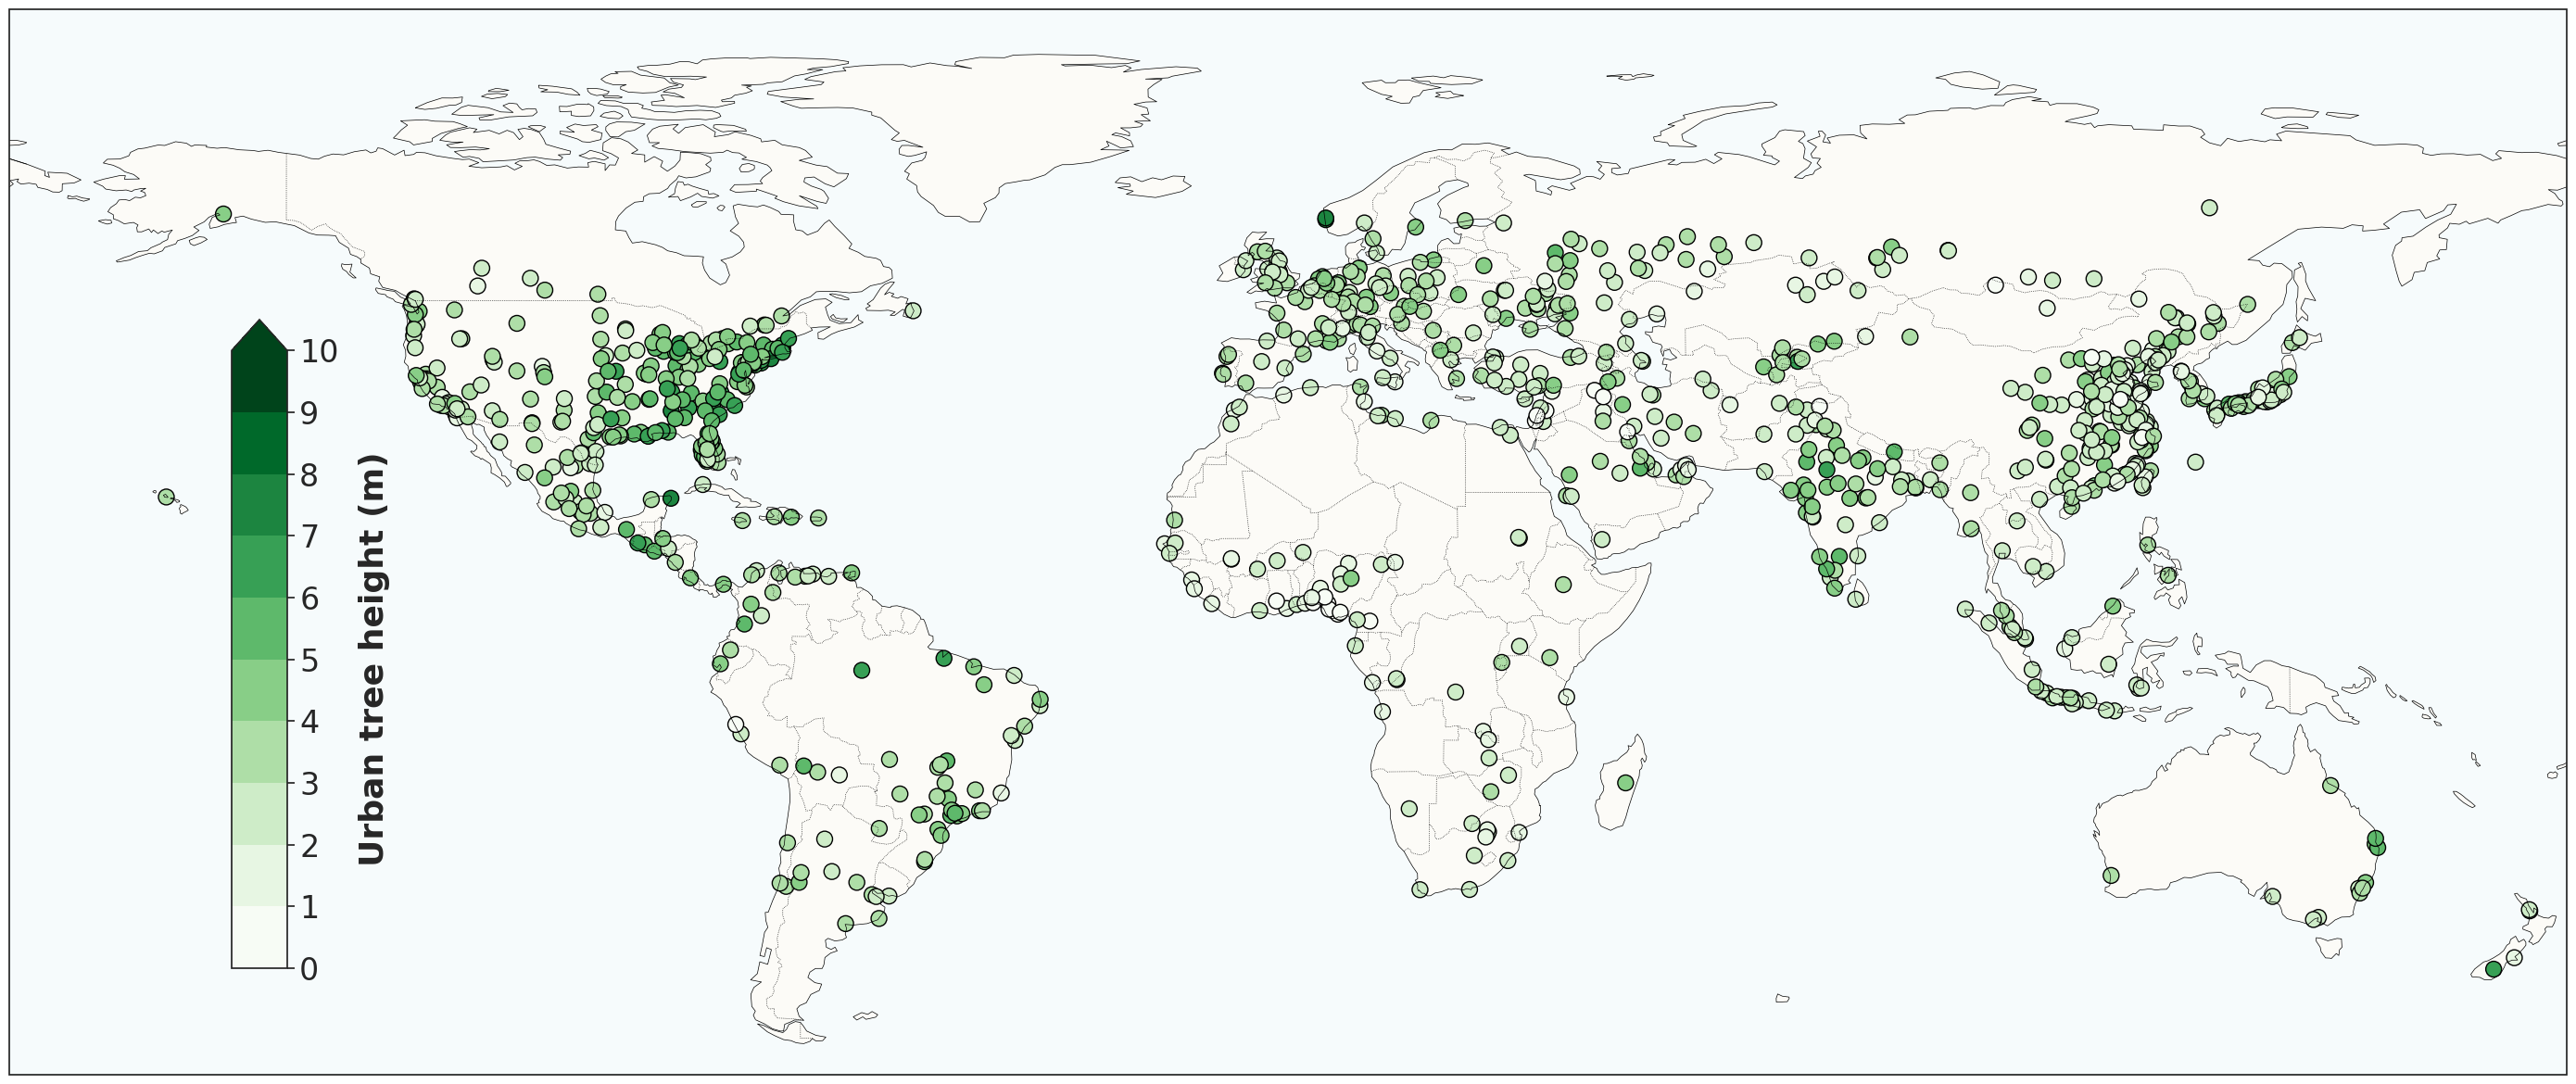

In [8]:
# ------------------------------------------------------------------
# STEP 1: IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# ------------------------------------------------------------------
# STEP 2: CONFIGURATION
# ------------------------------------------------------------------
# Adjust paths for your environment.
# This script assumes the input CSV is in the /content/ directory.
CSV_PATH = Path('/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv')

# Outputs will be saved in the specified directory.
OUT_DIR = Path('/content/FiguresV3/')
OUT_MAP = OUT_DIR / 'Fig4A_map.pdf'
OUT_HIST = OUT_DIR / 'Fig4A_hist.pdf'

# --- Parameters ---
# Use 10 distinct color classes for the map and histogram color scale.
NUM_COLOR_BINS = 10
# Use 60 bins for the fine-grained histogram representation.
NUM_HIST_BINS = 60
# A sequential green colormap suitable for vegetation data.
SEQUENTIAL_CMAP = plt.cm.Greens

# ------------------------------------------------------------------
# 3. HELPER FUNCTION: MINIMALIST HISTOGRAM
# ------------------------------------------------------------------
def minimalist_hist(series: pd.Series, bounds_arr, bins, cmap_obj, path):
    """
    Creates a minimalist histogram where each bar is colored according to its
    value, using the same discrete normalization as the map for consistency.
    """
    # Use the same normalization as the map for a direct visual link.
    norm_hist = BoundaryNorm(bounds_arr, ncolors=cmap_obj.N, clip=True)

    # Clip the data series to the exact bounds used in the map.
    series = series.clip(lower=bounds_arr[0], upper=bounds_arr[-1])
    if series.empty:
        print("No data available in the specified range for the histogram – skipped.")
        return

    fig, ax = plt.subplots(figsize=(6, 1.25))

    # Create the histogram.
    counts, edges, patches = ax.hist(
        series,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black',
        linewidth=1
    )

    # Color each histogram bar based on its value's class.
    for p, l, r in zip(patches, edges[:-1], edges[1:]):
        # The color is determined by the midpoint of the bar.
        p.set_facecolor(cmap_obj(norm_hist((l + r) / 2)))

    # Apply minimalist styling: remove ticks, labels, and all spines but the bottom.
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc') # Light color for subtlety
    ax.spines['bottom'].set_linewidth(1.5)

    # Set transparent backgrounds for both the figure and axes.
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    plt.savefig(path, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    print(f"Histogram saved to -> {path}")
    plt.show()


# ------------------------------------------------------------------
# 4. MAIN ANALYSIS AND VISUALIZATION
# ------------------------------------------------------------------
def analyze_and_plot_tree_height(csv_file):
    """
    Loads urban tree height data, plots it on a global map with a 10-class
    color scale, and generates a corresponding minimalist histogram.
    """
    # --- Data Loading and Preparation ---
    if not csv_file.is_file():
        raise FileNotFoundError(f"ERROR: Input CSV not found -> {csv_file}")

    df = pd.read_csv(csv_file, low_memory=False)

    required_columns = ['meta_mean_urban', 'Urban_Area', 'lat', 'lon']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"ERROR: Missing required column '{col}' in CSV.")
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=required_columns, inplace=True)

    # Filter for the 1000 largest cities by urban area.
    df_top1000 = df.nlargest(1000, 'Urban_Area').copy()
    print(f"Analyzing the {len(df_top1000)} largest cities by urban area.")

    # --- Color Scale Definition ---
    # Define the data range for tree height (in meters).
    vmin = 0.0
    vmax = 10.0

    # Create 10 discrete boundaries for the color bins (0-1m, 1-2m, ..., 9-10m).
    bounds = np.linspace(vmin, vmax, NUM_COLOR_BINS + 1)
    # Create a normalization object to map data values to the discrete colormap.
    norm = BoundaryNorm(bounds, ncolors=SEQUENTIAL_CMAP.N, clip=True)

    # --- City Scatter Map ---
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

    # Scatter plot of the top 1000 cities, colored by tree height.
    scatter = ax.scatter(
        df_top1000['lon'],
        df_top1000['lat'],
        c=df_top1000['meta_mean_urban'], # Color based on tree height
        cmap=SEQUENTIAL_CMAP,
        norm=norm,
        s=150,
        alpha=1,
        edgecolors='black',
        linewidths=1,
        transform=ccrs.PlateCarree()
    )

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # --- Color Bar ---
    cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
    sm = ScalarMappable(norm=norm, cmap=SEQUENTIAL_CMAP)
    sm.set_array([]) # An array must be set for the mappable to work.
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
    cbar.set_label('Urban tree height (m)', fontsize=26, labelpad=15, fontweight='bold')

    # Set ticks to the calculated bin edges for clarity.
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f'{b:.0f}' for b in bounds])
    cbar.ax.tick_params(labelsize=24)

    plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
    plt.savefig(OUT_MAP, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    print(f"Map saved to -> {OUT_MAP}")
    plt.show()

    # --- Minimalist Histogram Generation ---
    # Call the helper function to create the histogram with matching style.
    minimalist_hist(
        series=df_top1000['meta_mean_urban'],
        bounds_arr=bounds,
        bins=NUM_HIST_BINS,
        cmap_obj=SEQUENTIAL_CMAP,
        path=OUT_HIST
    )

# ------------------------------------------------------------------
# 5. EXECUTION
# ------------------------------------------------------------------
if __name__ == "__main__":
    try:
        analyze_and_plot_tree_height(CSV_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(f"A critical error occurred: {e}", file=sys.stderr)

Analyzing the 80963 largest cities by urban area.


A critical error occurred: [Errno 2] No such file or directory: '/content/FiguresV3/EDFig7A_map.pdf'


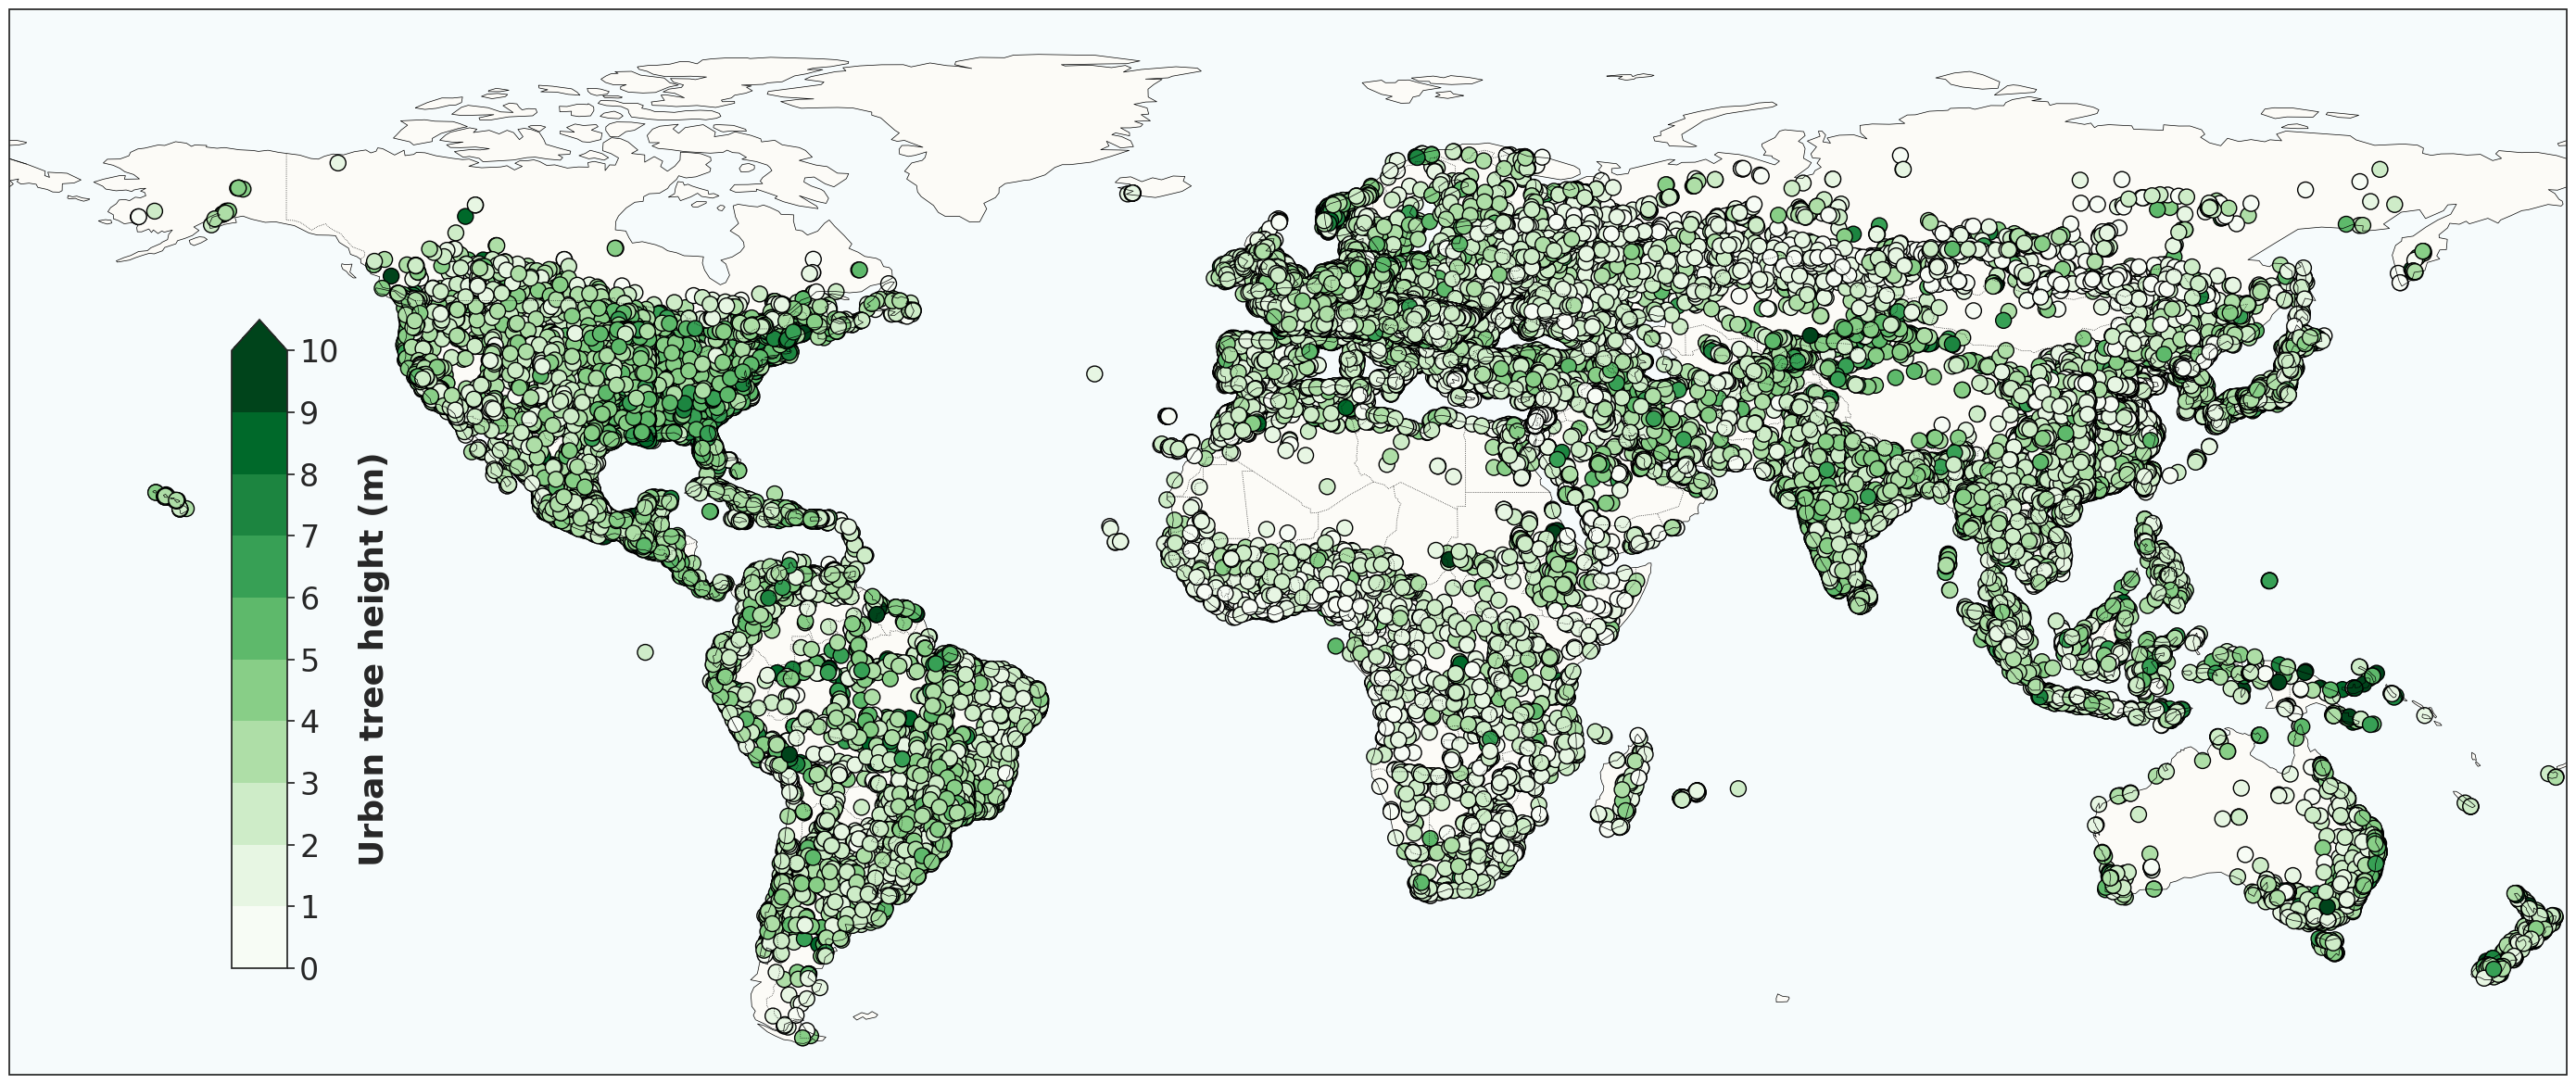

In [9]:
# ------------------------------------------------------------------
# STEP 1: IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# ------------------------------------------------------------------
# STEP 2: CONFIGURATION
# ------------------------------------------------------------------
# Adjust paths for your environment.
# This script assumes the input CSV is in the /content/ directory.
CSV_PATH = Path('/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv')

# Outputs will be saved in the specified directory.
OUT_DIR = Path('/content/FiguresV3/')
OUT_MAP = OUT_DIR / 'EDFig7A_map.pdf'
OUT_HIST = OUT_DIR / 'EDFig7A_hist.pdf'

# --- Parameters ---
# Use 10 distinct color classes for the map and histogram color scale.
NUM_COLOR_BINS = 10
# Use 60 bins for the fine-grained histogram representation.
NUM_HIST_BINS = 60
# A sequential green colormap suitable for vegetation data.
SEQUENTIAL_CMAP = plt.cm.Greens

# ------------------------------------------------------------------
# 3. HELPER FUNCTION: MINIMALIST HISTOGRAM
# ------------------------------------------------------------------
def minimalist_hist(series: pd.Series, bounds_arr, bins, cmap_obj, path):
    """
    Creates a minimalist histogram where each bar is colored according to its
    value, using the same discrete normalization as the map for consistency.
    """
    # Use the same normalization as the map for a direct visual link.
    norm_hist = BoundaryNorm(bounds_arr, ncolors=cmap_obj.N, clip=True)

    # Clip the data series to the exact bounds used in the map.
    series = series.clip(lower=bounds_arr[0], upper=bounds_arr[-1])
    if series.empty:
        print("No data available in the specified range for the histogram – skipped.")
        return

    fig, ax = plt.subplots(figsize=(6, 1.25))

    # Create the histogram.
    counts, edges, patches = ax.hist(
        series,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black',
        linewidth=1
    )

    # Color each histogram bar based on its value's class.
    for p, l, r in zip(patches, edges[:-1], edges[1:]):
        # The color is determined by the midpoint of the bar.
        p.set_facecolor(cmap_obj(norm_hist((l + r) / 2)))

    # Apply minimalist styling: remove ticks, labels, and all spines but the bottom.
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc') # Light color for subtlety
    ax.spines['bottom'].set_linewidth(1.5)

    # Set transparent backgrounds for both the figure and axes.
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    plt.savefig(path, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    print(f"Histogram saved to -> {path}")
    plt.show()


# ------------------------------------------------------------------
# 4. MAIN ANALYSIS AND VISUALIZATION
# ------------------------------------------------------------------
def analyze_and_plot_tree_height(csv_file):
    """
    Loads urban tree height data, plots it on a global map with a 10-class
    color scale, and generates a corresponding minimalist histogram.
    """
    # --- Data Loading and Preparation ---
    if not csv_file.is_file():
        raise FileNotFoundError(f"ERROR: Input CSV not found -> {csv_file}")

    df = pd.read_csv(csv_file, low_memory=False)

    required_columns = ['meta_mean_urban', 'Urban_Area', 'lat', 'lon']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"ERROR: Missing required column '{col}' in CSV.")
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=required_columns, inplace=True)

    # -----------------------------------------
    # REMOVE ALL 0 TREE HEIGHT VALUES
    # -----------------------------------------
    df = df[df['meta_mean_urban'] > 0].copy()
    if df.empty:
        raise ValueError("After removing zero tree-height values, no data remain.")

    # Filter for the 1000 largest cities by urban area.
    df_top1000 = df
    print(f"Analyzing the {len(df_top1000)} largest cities by urban area.")

    # --- Color Scale Definition ---
    vmin = 0.0
    vmax = 10.0
    bounds = np.linspace(vmin, vmax, NUM_COLOR_BINS + 1)
    norm = BoundaryNorm(bounds, ncolors=SEQUENTIAL_CMAP.N, clip=True)

    # --- City Scatter Map ---
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

    scatter = ax.scatter(
        df_top1000['lon'],
        df_top1000['lat'],
        c=df_top1000['meta_mean_urban'],
        cmap=SEQUENTIAL_CMAP,
        norm=norm,
        s=150,
        alpha=1,
        edgecolors='black',
        linewidths=1,
        transform=ccrs.PlateCarree()
    )

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # --- Color Bar ---
    cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
    sm = ScalarMappable(norm=norm, cmap=SEQUENTIAL_CMAP)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
    cbar.set_label('Urban tree height (m)', fontsize=26, labelpad=15, fontweight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f'{b:.0f}' for b in bounds])
    cbar.ax.tick_params(labelsize=24)

    plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
    plt.savefig(OUT_MAP, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    print(f"Map saved to -> {OUT_MAP}")
    plt.show()

    # --- Minimalist Histogram ---
    minimalist_hist(
        series=df_top1000['meta_mean_urban'],
        bounds_arr=bounds,
        bins=NUM_HIST_BINS,
        cmap_obj=SEQUENTIAL_CMAP,
        path=OUT_HIST
    )

# ------------------------------------------------------------------
# 5. EXECUTION
# ------------------------------------------------------------------
if __name__ == "__main__":
    try:
        analyze_and_plot_tree_height(CSV_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(f"A critical error occurred: {e}", file=sys.stderr)

###urban - rural city

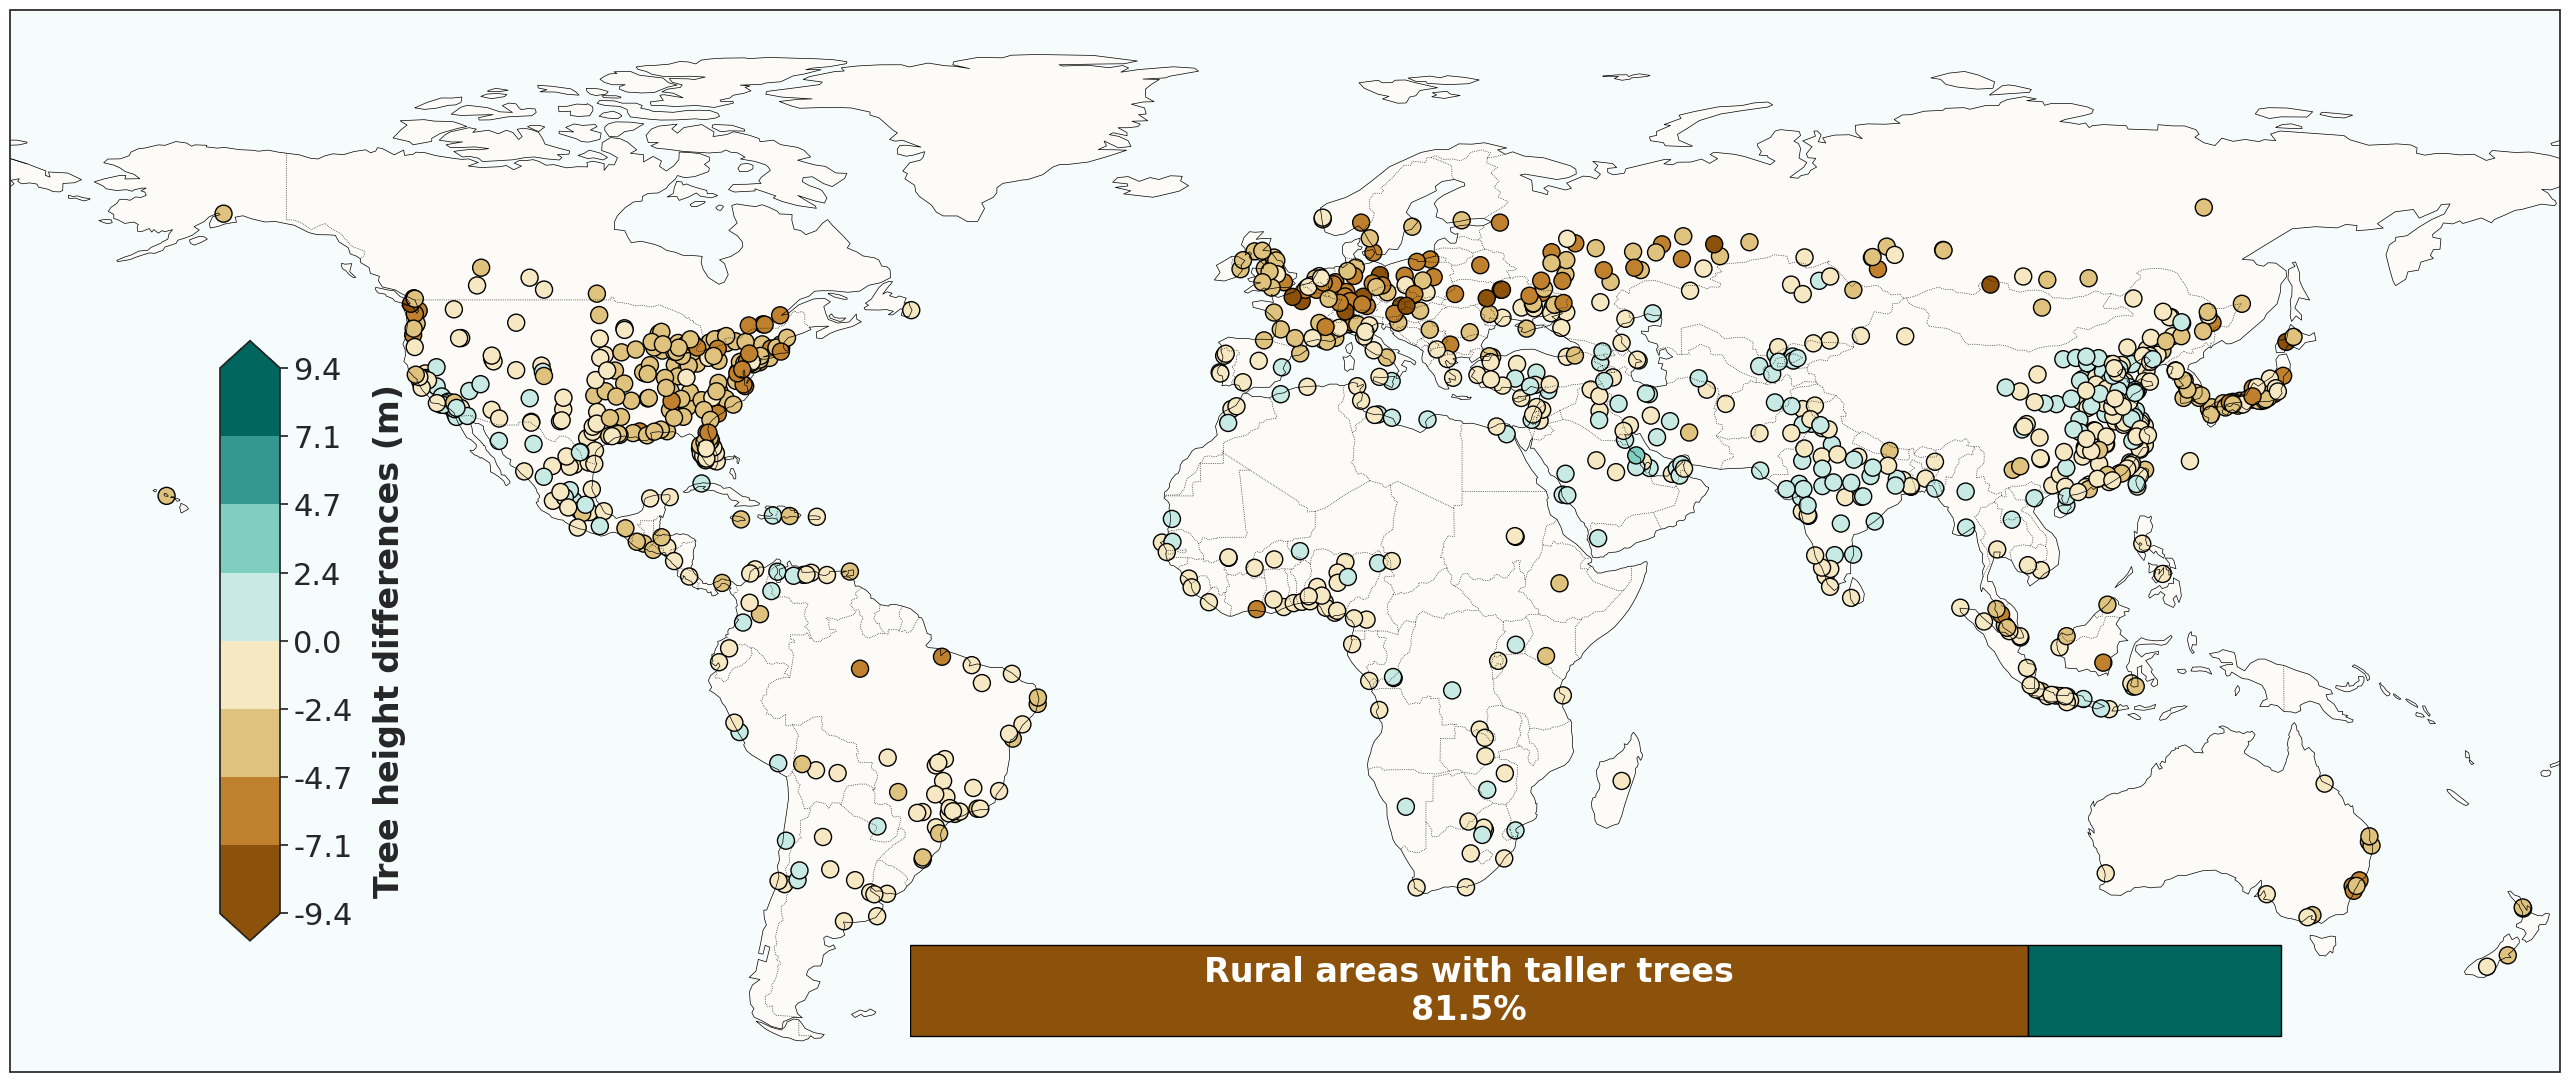

Histogram successfully saved to /content/Fig4B_hist.pdf


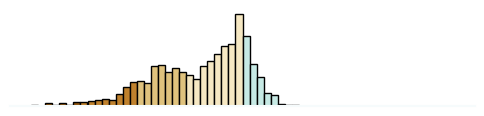

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd

# How many histogram bars (many bars; color comes from discrete classes)
NBINS_HIST = 60


def analyze_tree_height_difference(file_path):
    """
    Loads geospatial tree height data, computes the urban–rural difference,
    and plots a scatter map and histogram with a symmetric DISCRETE color scale.
    """
    # Load data with error handling
    try:
        data = gpd.read_file(file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error reading file '{file_path}': {e}")

    # Ensure required columns exist and are numeric
    required_columns = ['meta_mean_urban', 'meta_mean_rural', 'lat', 'lon', 'Urban_Area']
    missing = [c for c in required_columns if c not in data.columns]
    if missing:
        raise ValueError(f"Required columns missing: {missing}")

    for col in required_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.dropna(subset=required_columns)

    if data.empty:
        raise ValueError("No valid rows after cleaning input columns.")

    # Compute urban – rural tree height difference
    data['tree_height_diff'] = data['meta_mean_urban'] - data['meta_mean_rural']

    # Select the top 1000 rows by Urban_Area (if fewer exist, just take all)
    if 'Urban_Area' not in data.columns:
        raise ValueError("Column 'Urban_Area' is required to select top cities.")
    data = data.nlargest(1000, 'Urban_Area')

    if data.empty:
        raise ValueError("No data available after selecting top cities by 'Urban_Area'.")

    # Diverging DISCRETE colors (even number; symmetric around 0 with BoundaryNorm)
    custom_colors = [
        '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',  # Brown side (rural taller)
        '#c7eae5', '#80cdc1', '#35978f', '#01665e'   # Teal side (urban taller)
    ]

    # Symmetric bounds based on data
    min_val = float(data['tree_height_diff'].min())
    max_val = float(data['tree_height_diff'].max())
    abs_max = max(abs(min_val), abs(max_val)) if np.isfinite(min_val) and np.isfinite(max_val) else 1.0
    if abs_max == 0:
        abs_max = 1.0  # avoid degenerate colormap

    # 8 color classes -> 9 bin edges, symmetric around 0 (0 is a boundary)
    discrete_bounds = np.linspace(-abs_max, abs_max, len(custom_colors) + 1)
    cmap_discrete = ListedColormap(custom_colors)
    discrete_norm = BoundaryNorm(discrete_bounds, len(custom_colors), clip=True)

    # Create the scatter map using Cartopy
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND,  facecolor="#fcfbf7")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS,  linewidth=0.5, linestyle=":")

    scatter = ax.scatter(
        data['lon'],
        data['lat'],
        c=data['tree_height_diff'],
        cmap=cmap_discrete,
        norm=discrete_norm,
        s=150,
        alpha=1,
        edgecolors='black',
        linewidths=1,
        transform=ccrs.PlateCarree()
    )

    # Colorbar
    cbar_ax = fig.add_axes([0.17, 0.3, 0.02, 0.3])
    cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='vertical', extend='both')
    cbar.set_label('Tree height differences (m)', fontsize=24, labelpad=15, weight="bold")
    cbar.ax.tick_params(labelsize=22)
    cbar.set_ticks(discrete_bounds)
    tick_labels = [f"{x:.1f}" for x in discrete_bounds]
    cbar.set_ticklabels(tick_labels)

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # Calculate percentages for the bar chart
    # >0 means urban taller; <0 means rural taller; ==0 ignored
    total_count = len(data)
    urban_count = int((data['tree_height_diff'] > 0).sum())
    rural_count = int((data['tree_height_diff'] < 0).sum())

    if total_count == 0:
        urban_percent = rural_percent = 0.0
    else:
        urban_percent = (urban_count / total_count) * 100.0
        rural_percent = (rural_count / total_count) * 100.0

    # --- SWAPPED ORDER: Rural on LEFT, Urban on RIGHT ---
    bar_ax = fig.add_axes([0.4, 0.25, 0.48, 0.05])
    bar_ax.set_axis_off()

    # Rural (left)
    bar_ax.barh(['Cities'], [rural_percent], color='#8c510a', edgecolor='black', height=0.4)
    # Urban (to the right), offset by rural share
    bar_ax.barh(['Cities'], [urban_percent], color='#01665e', edgecolor='black', height=0.4, left=rural_percent)

    # Annotations with robustness for tiny segments
    def annotate_segment(ax, left, width, y, label, inside_color='white', outside_offset=0.8):
        if width >= 5.0:  # label inside if >= 5% width
            ax.text(left + width/2.0, y, label, ha='center', va='center',
                    fontsize=24, color=inside_color, weight='bold')
        elif width > 0.0:
            ax.text(left + width + outside_offset, y, label, ha='left', va='center',
                    fontsize=22, color='black', weight='bold')

    annotate_segment(
        bar_ax,
        left=0.0,
        width=rural_percent,
        y=0,
        label=f'Rural areas with taller trees\n{rural_percent:.1f}%'
    )
    annotate_segment(
        bar_ax,
        left=rural_percent,
        width=urban_percent,
        y=0,
        label=''  # your original had no label for urban
    )

    bar_ax.set_xlim(0, max(100.0, rural_percent + urban_percent + 5.0))

    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05)
    try:
        plt.savefig(
            '/content/Fig4B_maps.pdf',
            dpi=400, bbox_inches='tight', format='pdf', transparent=True
        )
    except Exception as e:
        print(f"Error saving scatter map: {e}")
    plt.show()
    plt.close(fig)

    # --- DISCRETE-COLORED histogram with MANY bins (like veg_diff example) ---
    create_frequency_histogram_discrete(
        data_series=data['tree_height_diff'],
        bounds=discrete_bounds,
        cmap_discrete=cmap_discrete,
        norm_discrete=discrete_norm,
        num_bins=NBINS_HIST,
        out_path='/content/Fig4B_hist.pdf'
    )


def create_frequency_histogram_discrete(
    data_series: pd.Series,
    bounds: np.ndarray,
    cmap_discrete: ListedColormap,
    norm_discrete: BoundaryNorm,
    num_bins: int,
    out_path: str,
) -> None:
    """
    Minimalist frequency histogram of tree-height differences.

    - X range is clipped to `bounds[0] .. bounds[-1]`
    - Many bins (num_bins), but each bar is colored by the same
      discrete classes used on the map and colorbar.
    """
    lower_bound = float(bounds[0])
    upper_bound = float(bounds[-1])

    # Filter to the same numeric range as the map/cbar
    filtered = data_series[(data_series >= lower_bound) & (data_series <= upper_bound)]
    filtered = filtered[np.isfinite(filtered)]
    if filtered.empty:
        print("No data available within specified bounds for histogram.")
        return

    # Histogram bins: many more than the color classes, but same range
    bins = np.linspace(lower_bound, upper_bound, num_bins + 1)

    fig, ax = plt.subplots(figsize=(6, 1.25))
    try:
        counts, bin_edges, patches = ax.hist(
            filtered,
            bins=bins,
            edgecolor='black',
            linewidth=1
        )

        # Color each bar according to its midpoint's discrete class
        for patch, left, right in zip(patches, bin_edges[:-1], bin_edges[1:]):
            midpoint = 0.5 * (left + right)
            color = cmap_discrete(norm_discrete(midpoint))
            patch.set_facecolor(color)

        # Minimalist styling
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc')
        ax.spines['bottom'].set_linewidth(1.5)

        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, format='pdf', dpi=400, bbox_inches='tight', transparent=True)
        print(f"Histogram successfully saved to {out_path}")
    except Exception as e:
        print(f"Error generating/saving histogram: {e}")
    finally:
        plt.show()
        plt.close(fig)


if __name__ == "__main__":
    file_path = '/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv'
    try:
        analyze_tree_height_difference(file_path)
    except Exception as e:
        print(f"An error occurred during analysis: {e}")


[INFO] n (summary-matched sample) = 81181
[INFO] % U>R  = 23.57%
[INFO] % R>U  = 76.20%
[INFO] % ties = 0.24%


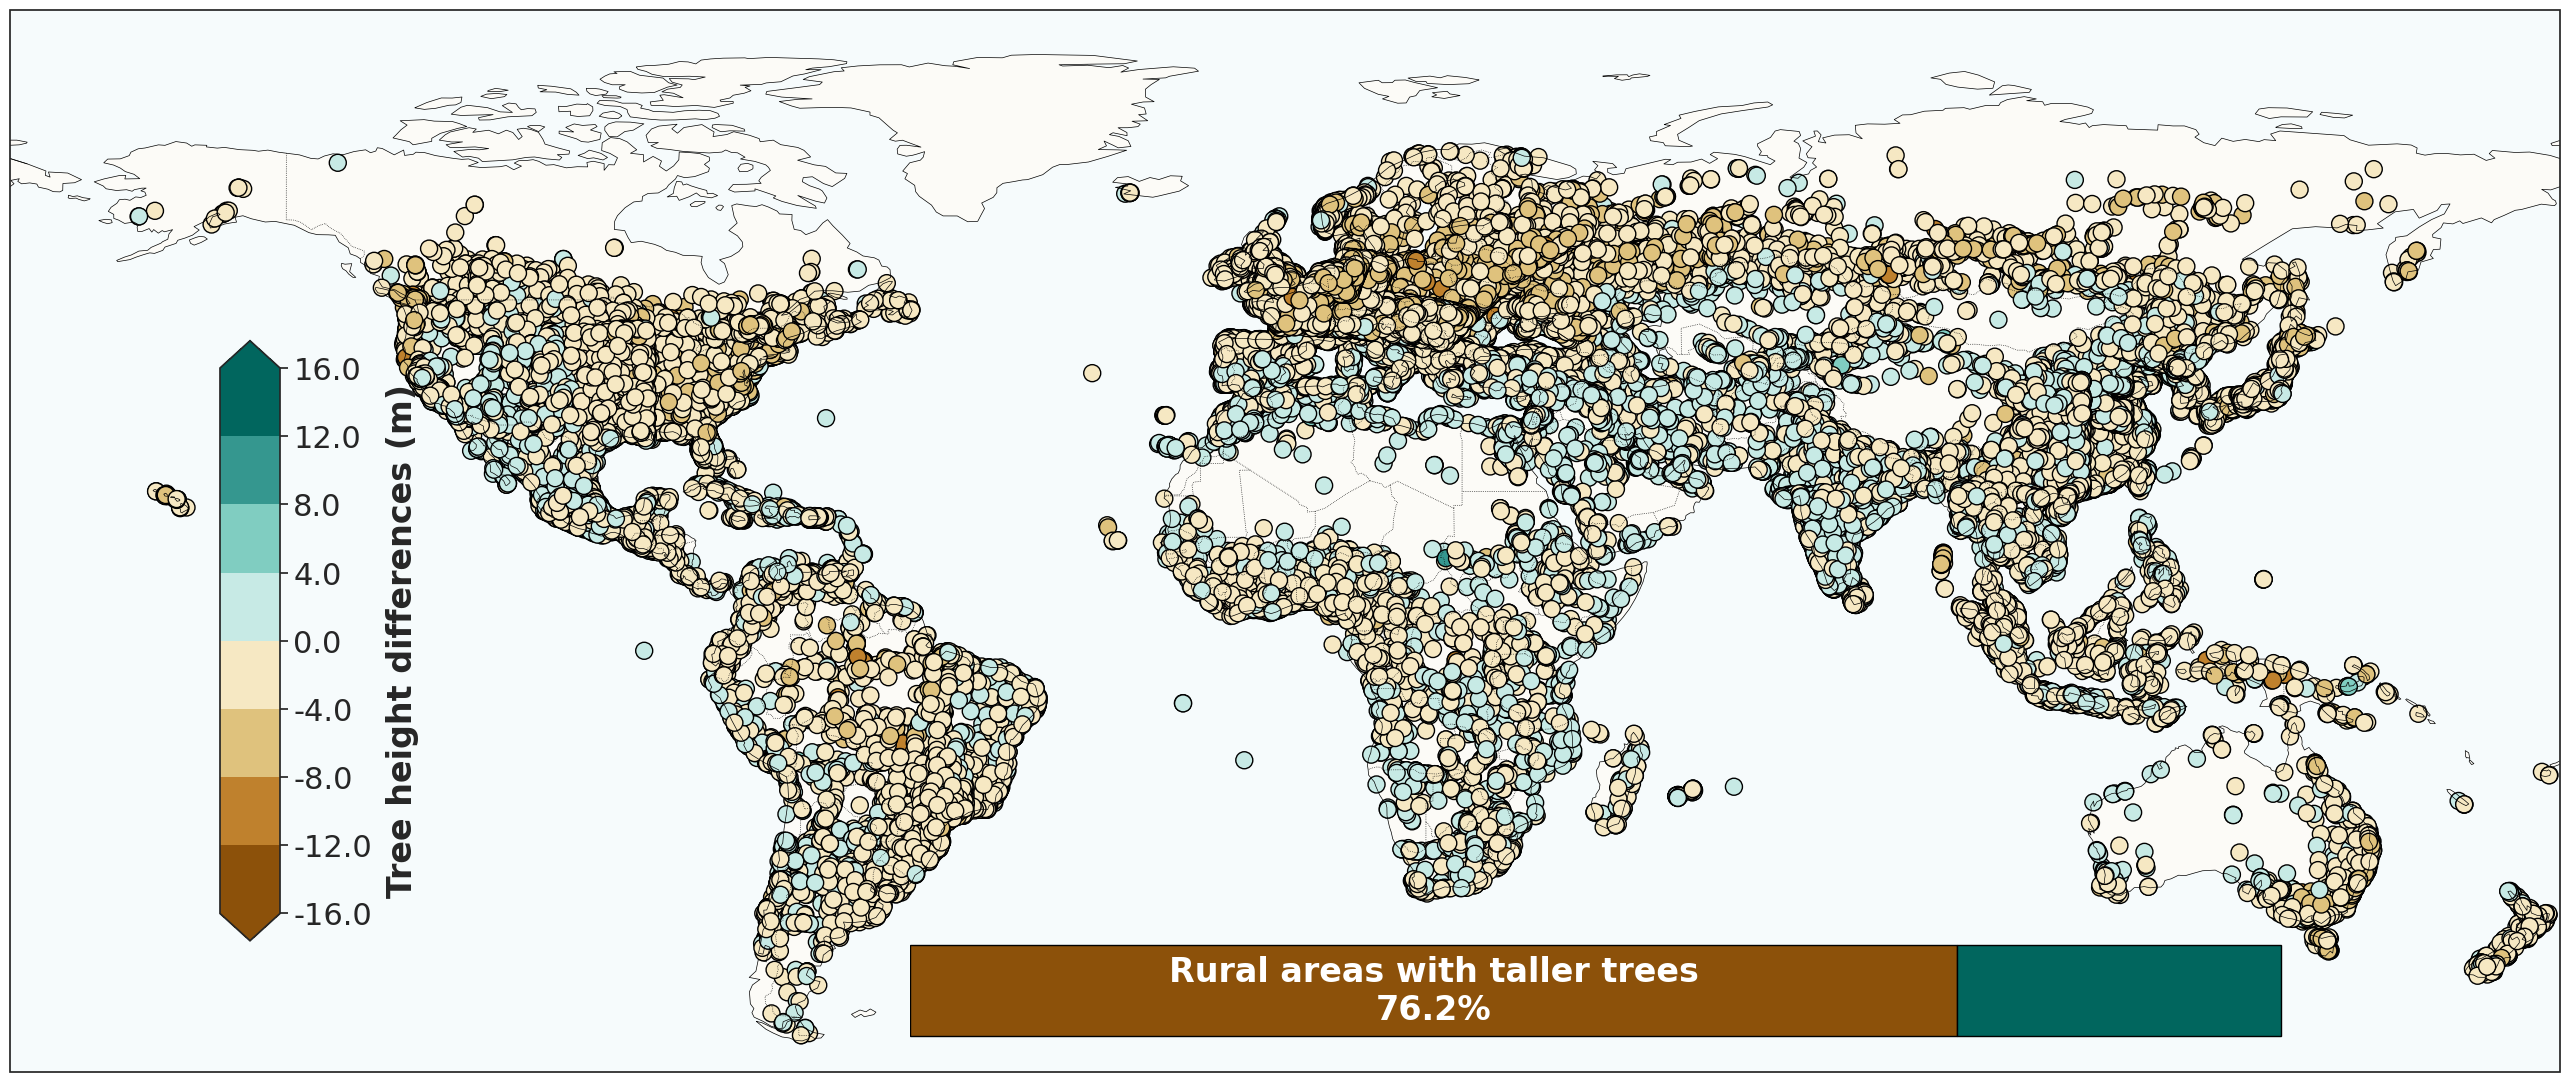

Histogram successfully saved to /content/EDFig7B_hist.pdf


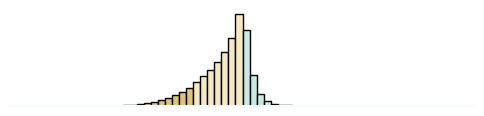

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd

NBINS_HIST = 60  # many bins; color still comes from discrete classes


def analyze_tree_height_difference(file_path):
    """
    Loads geospatial tree height data, computes the urban–rural difference,
    and plots a scatter map and histogram with a symmetric DISCRETE color scale.

    Includes:
      - filtering on tree_cover_area_urban > 0 & tree_cover_area_rural > 0
      - %U>R, %R>U, %ties using .mean() on the filtered sample
      - histogram with many bins, colored by the same discrete classes as the map
    """
    # Load data with error handling
    try:
        data = gpd.read_file(file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error reading file '{file_path}': {e}")

    # Ensure required columns exist and are numeric
    required_columns = [
        'meta_mean_urban', 'meta_mean_rural', 'lat', 'lon',
        'tree_cover_area_urban', 'tree_cover_area_rural'
    ]
    missing = [c for c in required_columns if c not in data.columns]
    if missing:
        raise ValueError(f"Required columns missing: {missing}")

    for col in required_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop NaNs from the required columns
    data = data.dropna(subset=required_columns)
    if data.empty:
        raise ValueError("No valid rows after cleaning input columns.")

    # Compute urban – rural tree height difference
    data['tree_height_diff'] = data['meta_mean_urban'] - data['meta_mean_rural']

    # Filter: keep only cities with non-zero tree cover in BOTH urban and rural
    data = data[
        (data['tree_cover_area_urban'] > 0) &
        (data['tree_cover_area_rural'] > 0)
    ].copy()

    data = data.dropna(subset=['tree_height_diff'])
    if data.empty:
        raise ValueError("No valid rows after applying tree-cover filters (TCU > 0 & TCR > 0).")

    # Diverging DISCRETE colors (even number; symmetric around 0 with BoundaryNorm)
    custom_colors = [
        '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',  # Brown side (rural taller)
        '#c7eae5', '#80cdc1', '#35978f', '#01665e'   # Teal side (urban taller)
    ]

    # Symmetric bounds based on data
    min_val = float(data['tree_height_diff'].min())
    max_val = float(data['tree_height_diff'].max())
    abs_max = max(abs(min_val), abs(max_val)) if np.isfinite(min_val) and np.isfinite(max_val) else 1.0
    if abs_max == 0:
        abs_max = 1.0  # avoid degenerate colormap

    # 8 color classes -> 9 edges; symmetric around 0
    discrete_bounds = np.linspace(-abs_max, abs_max, len(custom_colors) + 1)
    cmap_discrete = ListedColormap(custom_colors)
    discrete_norm = BoundaryNorm(discrete_bounds, len(custom_colors), clip=True)

    # ----- Scatter map -----
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND,  facecolor="#fcfbf7")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS,  linewidth=0.5, linestyle=":")

    scatter = ax.scatter(
        data['lon'],
        data['lat'],
        c=data['tree_height_diff'],
        cmap=cmap_discrete,
        norm=discrete_norm,
        s=150,
        alpha=1,
        edgecolors='black',
        linewidths=1,
        transform=ccrs.PlateCarree()
    )

    # Colorbar
    cbar_ax = fig.add_axes([0.17, 0.3, 0.02, 0.3])
    cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='vertical', extend='both')
    cbar.set_label('Tree height differences (m)', fontsize=24, labelpad=10, weight="bold")
    cbar.ax.tick_params(labelsize=22)
    cbar.set_ticks(discrete_bounds)
    tick_labels = [f"{x:.1f}" for x in discrete_bounds]
    cbar.set_ticklabels(tick_labels)

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # ----- Percentages (U>R, R>U, ties) -----
    diff_series = data['tree_height_diff']
    n = int(diff_series.size)
    if n == 0:
        raise ValueError("No finite height differences in filtered sample.")

    pct_urb   = float((diff_series > 0).mean() * 100.0)
    pct_rural = float((diff_series < 0).mean() * 100.0)
    pct_ties  = float((diff_series == 0).mean() * 100.0)

    print(f"[INFO] n (summary-matched sample) = {n}")
    print(f"[INFO] % U>R  = {pct_urb:.2f}%")
    print(f"[INFO] % R>U  = {pct_rural:.2f}%")
    print(f"[INFO] % ties = {pct_ties:.2f}%")

    # ----- Bar chart -----
    bar_ax = fig.add_axes([0.4, 0.25, 0.48, 0.05])
    bar_ax.set_axis_off()

    # Rural (left)
    bar_ax.barh(['Cities'], [pct_rural], color='#8c510a', edgecolor='black', height=0.4)
    # Urban (right, stacked)
    bar_ax.barh(['Cities'], [pct_urb], color='#01665e', edgecolor='black',
                height=0.4, left=pct_rural)

    def annotate_segment(ax, left, width, y, label, inside_color='white', outside_offset=0.8):
        if width >= 5.0:
            ax.text(left + width / 2.0, y, label, ha='center', va='center',
                    fontsize=24, color=inside_color, weight='bold')
        elif width > 0.0:
            ax.text(left + width + outside_offset, y, label, ha='left', va='center',
                    fontsize=24, color='black', weight='bold')

    annotate_segment(
        bar_ax,
        left=0.0,
        width=pct_rural,
        y=0,
        label=f'Rural areas with taller trees\n{pct_rural:.1f}%'
    )
    annotate_segment(
        bar_ax,
        left=pct_rural,
        width=pct_urb,
        y=0,
        label=''  # staying consistent with your original (no label for urban)
    )

    bar_ax.set_xlim(0, max(100.0, pct_rural + pct_urb + 5.0))

    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05)
    try:
        plt.savefig('/content/EDFig7B_map.pdf',
                    dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    except Exception as e:
        print(f"Error saving scatter map: {e}")
    plt.show()
    plt.close(fig)

    # ----- DISCRETE-colored histogram with MANY bins -----
    create_frequency_histogram_discrete(
        data_series=data['tree_height_diff'],
        bounds=discrete_bounds,
        cmap_discrete=cmap_discrete,
        norm_discrete=discrete_norm,
        num_bins=NBINS_HIST,
        out_path='/content/EDFig7B_hist.pdf'
    )


def create_frequency_histogram_discrete(
    data_series: pd.Series,
    bounds: np.ndarray,
    cmap_discrete: ListedColormap,
    norm_discrete: BoundaryNorm,
    num_bins: int,
    out_path: str,
) -> None:
    """
    Minimalist frequency histogram of tree-height differences.

    - X range is clipped to bounds[0]..bounds[-1]
    - Uses many bins (num_bins), but each bar is colored by the SAME
      discrete classes as the map/colorbar via BoundaryNorm.
    """
    lower_bound = float(bounds[0])
    upper_bound = float(bounds[-1])

    filtered = data_series[(data_series >= lower_bound) & (data_series <= upper_bound)]
    filtered = filtered[np.isfinite(filtered)]
    if filtered.empty:
        print("No data available within specified bounds for histogram.")
        return

    # Many bins in the same numeric range
    bins = np.linspace(lower_bound, upper_bound, num_bins + 1)

    fig, ax = plt.subplots(figsize=(6, 1.25))
    try:
        counts, bin_edges, patches = ax.hist(
            filtered,
            bins=bins,
            edgecolor='black',
            linewidth=1
        )

        # Color each bar according to its midpoint's discrete class
        for patch, left, right in zip(patches, bin_edges[:-1], bin_edges[1:]):
            midpoint = 0.5 * (left + right)
            color = cmap_discrete(norm_discrete(midpoint))
            patch.set_facecolor(color)

        # Minimalist styling
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc')
        ax.spines['bottom'].set_linewidth(1.5)

        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, bbox_inches='tight', format='pdf', transparent=True)
        print(f"Histogram successfully saved to {out_path}")
    except Exception as e:
        print(f"Error generating/saving histogram: {e}")
    finally:
        plt.show()
        plt.close(fig)


if __name__ == "__main__":
    file_path = '/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv'
    try:
        analyze_tree_height_difference(file_path)
    except Exception as e:
        print(f"An error occurred during analysis: {e}")


###country


=== TREE HEIGHT: URBAN vs RURAL (All cities & Top 1000) ===
   Variable       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Rank-biserial r p-value % U>R % U==R % R>U     n
Tree height Major cities  3.2888   0.0393   3.9511    0.0944  5.1711   0.0865   6.9087    0.1898 -1.8823 -2.9576   -0.9099         -0.8266  0.0000 18.50   0.00 81.50  1000
Tree height   All cities  2.9373   0.0059   3.6639    0.0537  4.3392   0.0097   6.3442    0.0906 -1.4018 -2.6804   -0.7081         -0.7256  0.0000 23.57   0.24 76.20 81181

[OK] Summary CSV saved → /content/T1_tree.csv

Keeping 168 countries with ≥3 cities for maps.


/tmp/ipython-input-3052788285.py:530: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_aggregate_country)


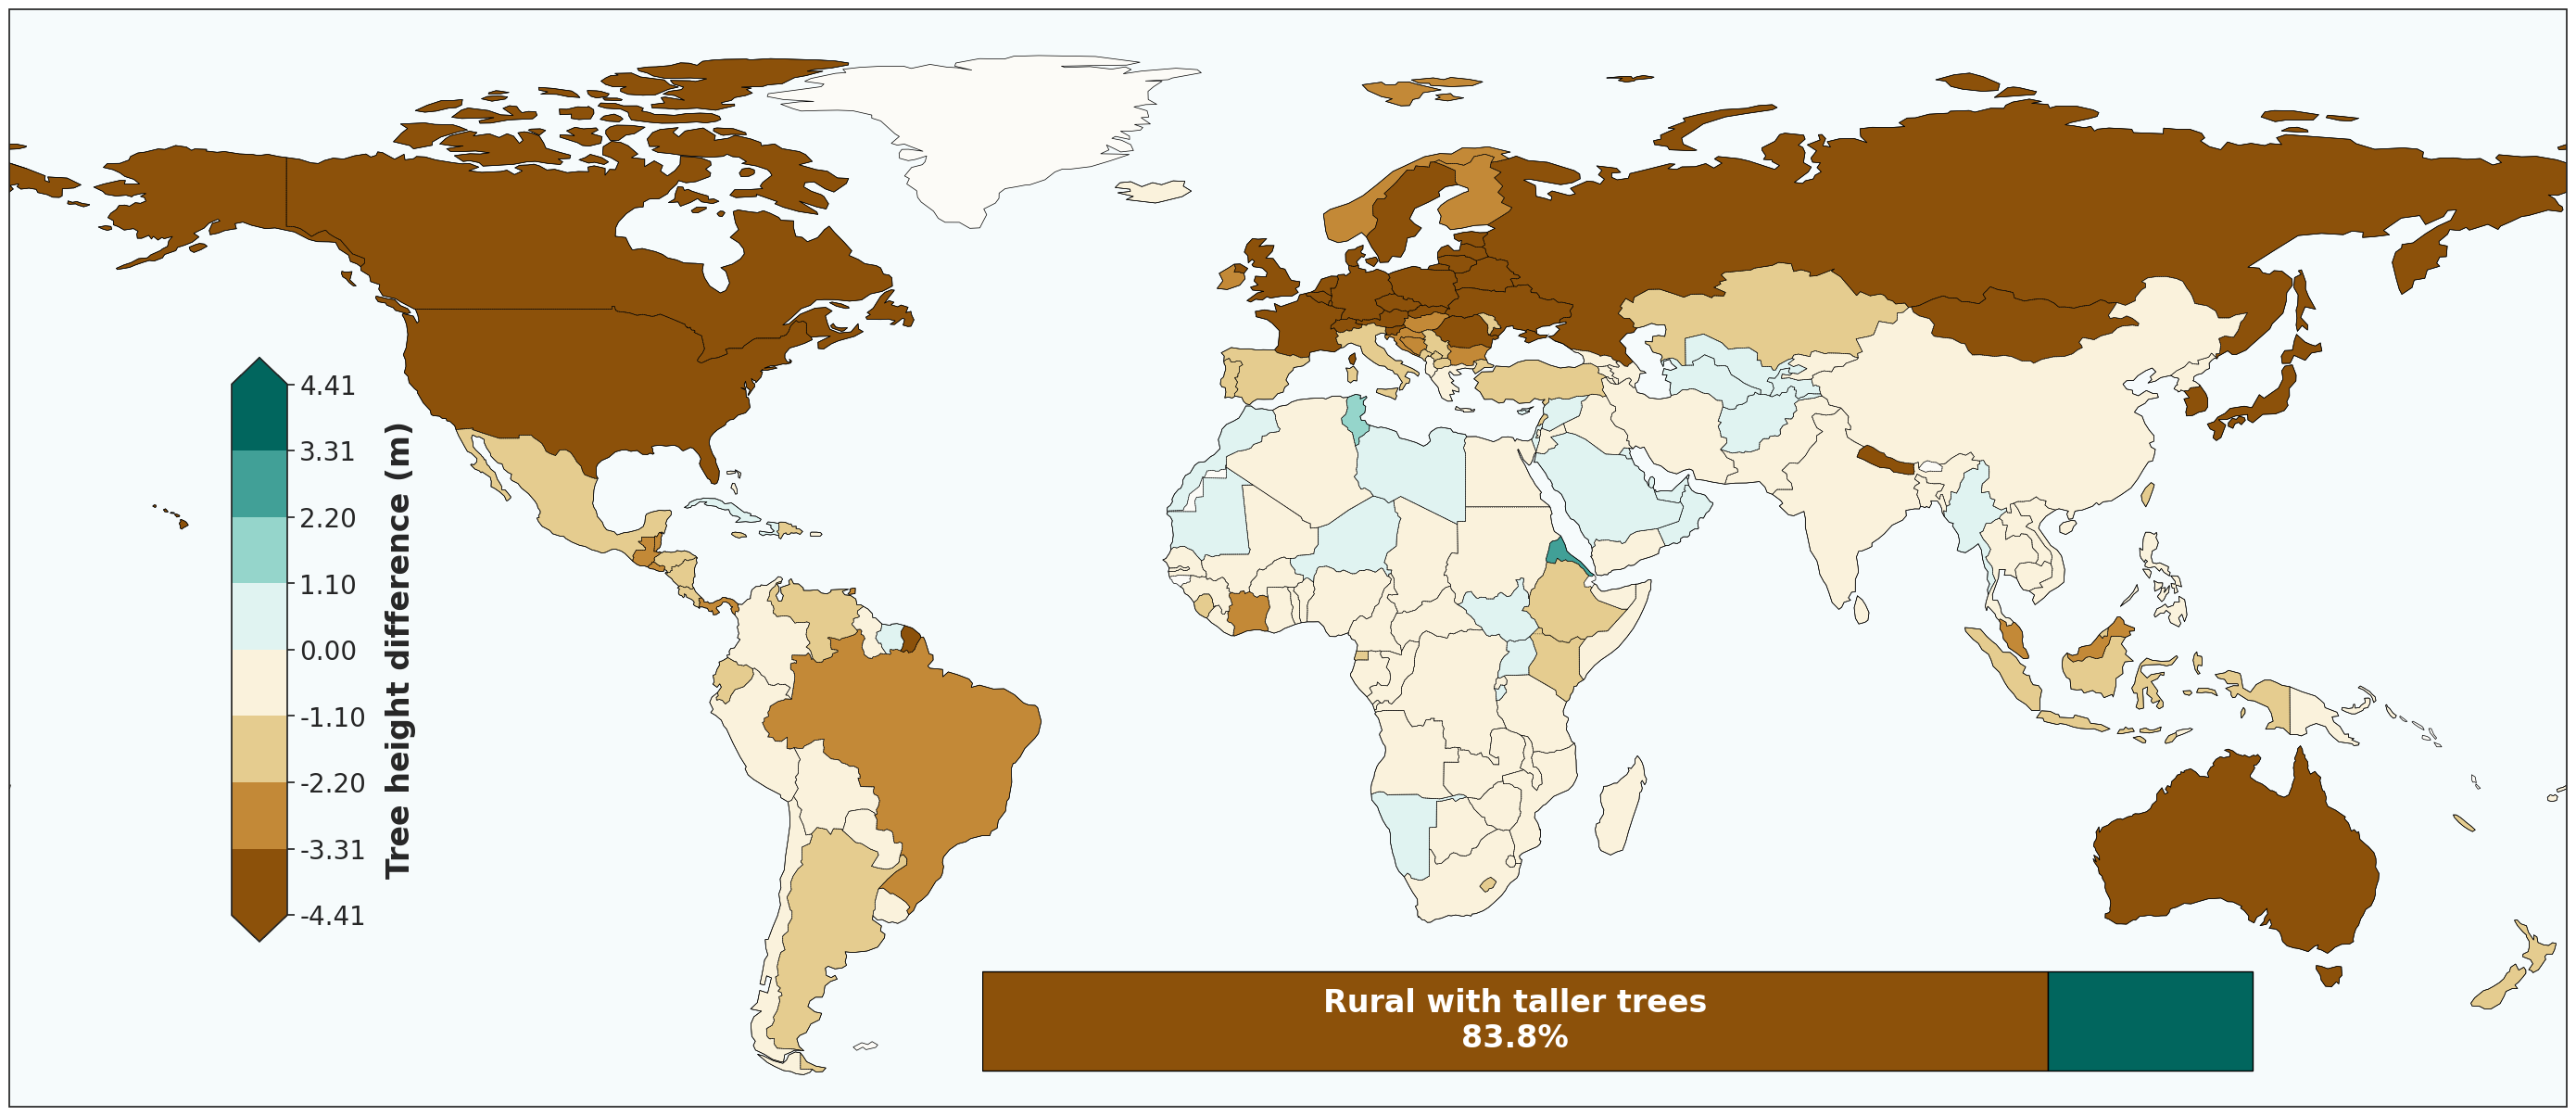

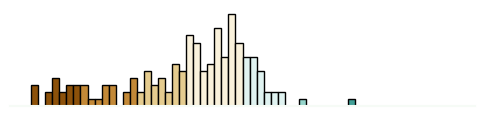

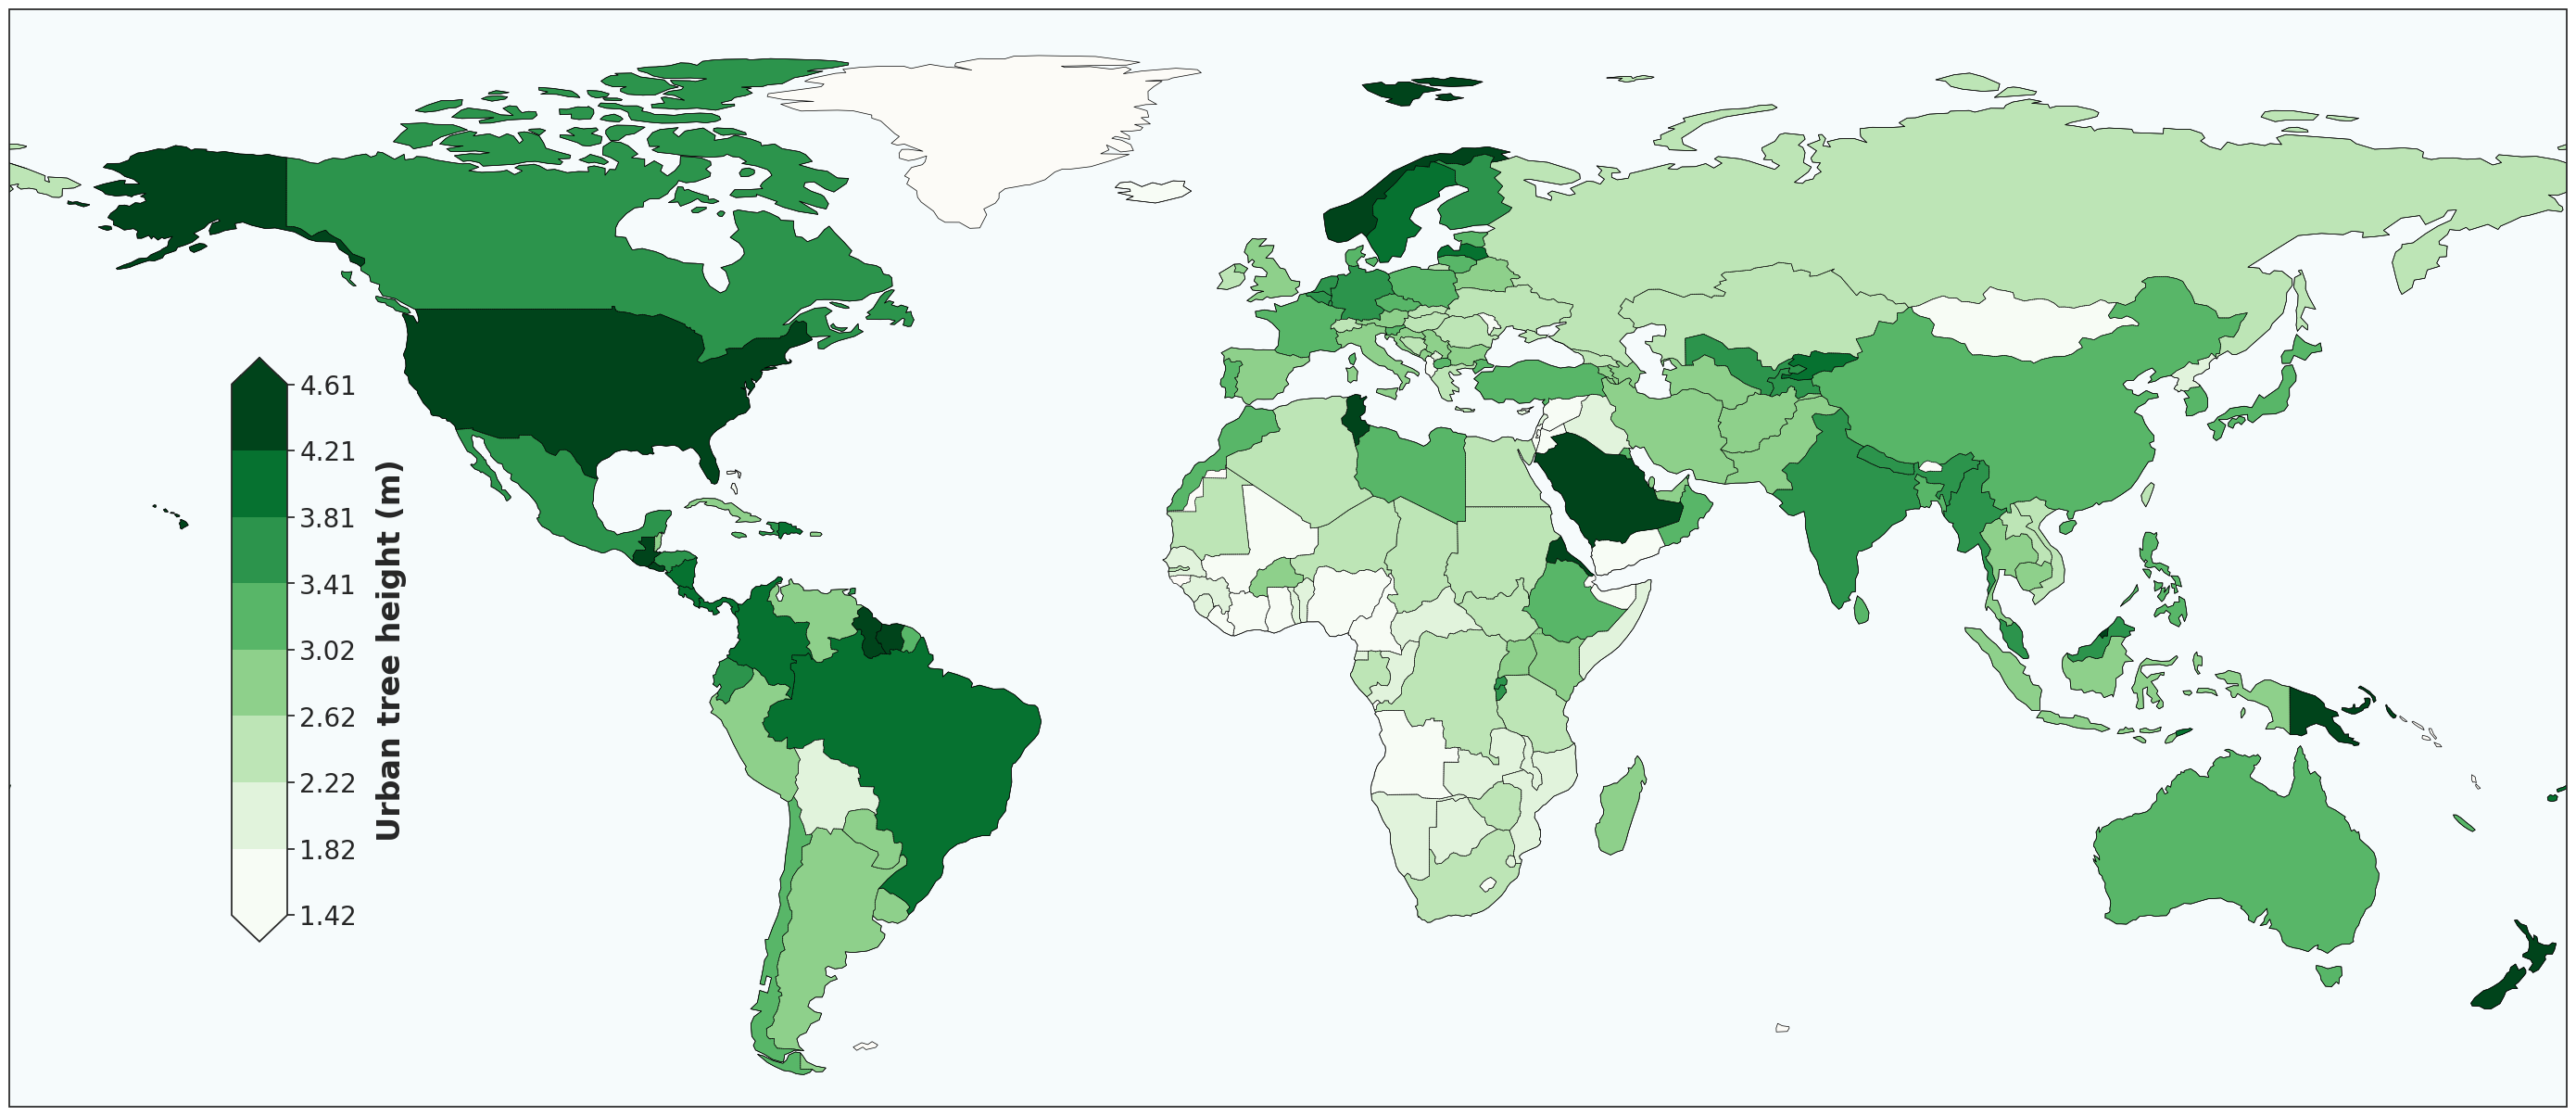

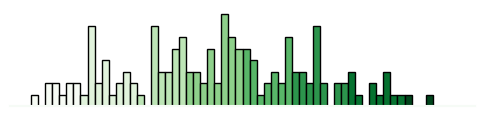

In [12]:
from __future__ import annotations
import math
import re
import sys
from pathlib import Path
from typing import Tuple, Optional, Dict

import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

# ────────────────────────── CONFIG ──────────────────────────

CSV_PATH   = Path("/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv")
SHAPE_PATH = Path("/content/ne_110m_admin_0_countries.shp")
TOP_N      = 1000

VARIABLE_LABEL = "Tree height"
MIN_CITIES     = 3          # min cities per country for maps
NUM_COLOR_BINS = 8
NUM_HIST_BINS  = 60
EPS_TIE        = 1e-9       # tolerance for ties in DW gap (m)

OUT_DIR        = Path("/content/")
OUT_SUMMARY    = CSV_PATH.parent / "T1_tree.csv"
OUT_MAP_DIFF   = OUT_DIR / "Sup_TreeHeight_country_diff_Map.pdf"
OUT_HIST_DIFF  = OUT_DIR / "Sup_TreeHeight_country_diff_Hist.pdf"
OUT_MAP_UABS   = OUT_DIR / "Sup_TreeHeight_country_abs_Map.pdf"
OUT_HIST_UABS  = OUT_DIR / "Sup_TreeHeight_country_abs_Hist.pdf"

# Palettes (diverging for diff, sequential for absolute)
DIVERGING_COLS  = [
    '#8c510a','#bf812d','#dfc27d','#f6e8c3',
    '#ffffff',
    '#c7eae5','#80cdc1','#35978f','#01665e'
]
SEQUENTIAL_COLS = [
    '#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b',
    '#74c476','#41ab5d','#238b45','#006d2c','#00441b'
]
COLOR_RURAL_GREENER = DIVERGING_COLS[0]
COLOR_URBAN_GREENER = DIVERGING_COLS[-1]
COLOR_TIES          = "#d9d9d9"

# ────────────────────────── COL RESOLUTION ──────────────────────────

def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).strip().lower())

def resolve_column(
    df: pd.DataFrame,
    candidates,
    *,
    required: bool = True,
    label: str = ""
) -> Optional[str]:
    """
    Case/underscore/space-insensitive resolver with substring fallback.
    """
    if isinstance(candidates, str):
        candidates = [candidates]

    lut = {_norm(c): c for c in df.columns}

    # Exact normalized
    for cand in candidates:
        k = _norm(cand)
        if k in lut:
            return lut[k]

    # Fuzzy contains
    for c in df.columns:
        nc = _norm(c)
        for cand in candidates:
            if _norm(cand) in nc:
                return c

    if required:
        raise KeyError(
            f"Required column not found for {label or candidates}: "
            f"none of {candidates!r} matched. "
            f"Columns present (first 30): {df.columns[:30].tolist()}"
        )
    return None

def choose_columns(df: pd.DataFrame) -> Tuple[str, str, str, str, Optional[str], str]:
    """
    Resolve:
      - H_urban, H_rural
      - tree_cover_area_urban, tree_cover_area_rural
      - Urban_Area (for TOP_N selection)
      - Country name column
    """
    h_u = resolve_column(
        df,
        ["meta_mean_urban", "glad_mean_urban", "eth_mean_urban", "glofab_mean_urban"],
        label="Urban tree height (mean)",
    )
    h_r = resolve_column(
        df,
        ["meta_mean_rural", "glad_mean_rural", "eth_mean_rural", "glofab_mean_rural"],
        label="Rural tree height (mean)",
    )
    tcu = resolve_column(df, "tree_cover_area_urban", label="tree_cover_area_urban")
    tcr = resolve_column(df, "tree_cover_area_rural", label="tree_cover_area_rural")
    ua  = resolve_column(df, "Urban_Area", required=False, label="Urban_Area (for Top 1000)")
    country_col = resolve_column(df, ["country", "NAME_EN", "ADMIN"], label="Country name")

    return h_u, h_r, tcu, tcr, ua, country_col

# ────────────────────────── HELPERS ──────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _unweighted_mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = pd.to_numeric(x, errors="coerce").dropna()
    n = int(x.size)
    if n == 0:
        return (np.nan, np.nan, 0)
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return mu, se, n

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    """
    Kish-style SE for a weighted mean:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x - μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ(w^2)
      SE    = sqrt(Var_w / n_eff)
    """
    x = pd.to_numeric(x, errors="coerce")
    w = pd.to_numeric(w, errors="coerce")
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].astype(float)
    w = w[m].astype(float)
    if x.empty:
        return (np.nan, np.nan)

    sw = float(w.sum())
    if sw <= 0:
        return (np.nan, np.nan)

    mu_w = float(np.dot(w, x) / sw)

    if x.size == 1:
        return (mu_w, np.nan)

    var_w = float(np.dot(w, (x - mu_w) ** 2) / sw)
    w2 = float(np.dot(w, w))
    if not np.isfinite(var_w) or var_w < 0 or w2 <= 0:
        return (mu_w, np.nan)

    n_eff = (sw * sw) / w2
    if not np.isfinite(n_eff) or n_eff <= 0:
        return (mu_w, np.nan)

    se = float(math.sqrt(var_w / n_eff))
    return mu_w, se

def _cohens_d_paired(diff: pd.Series) -> float:
    d = pd.to_numeric(diff, errors="coerce").dropna()
    n = d.size
    if n < 2:
        return float("nan")
    sd = float(d.std(ddof=1))
    if sd <= 0 or not np.isfinite(sd):
        return float("nan")
    return float(d.mean() / sd)

def _rank_biserial_from_diff(diff: pd.Series) -> float:
    """
    Paired rank-biserial for Urban − Rural:

        r_rb = (R_pos − R_neg) / (R_pos + R_neg)
    """
    d = pd.to_numeric(diff, errors="coerce")
    d = d[d != 0].dropna()
    n = int(d.size)
    if n == 0:
        return float("nan")

    ranks = d.abs().rank(method="average")
    R_pos = float(ranks[d > 0].sum())
    R_neg = float(ranks[d < 0].sum())
    R_tot = R_pos + R_neg
    if R_tot <= 0:
        return float("nan")

    return float((R_pos - R_neg) / R_tot)

def _pct_diff_breakdown(diff: pd.Series) -> Tuple[float, float, float]:
    """
    From paired diff = Urban − Rural, compute:
      % U>R  = 100 * share(diff > 0)
      % U==R = 100 * share(diff == 0)
      % R>U  = 100 * share(diff < 0)
    """
    d = pd.to_numeric(diff, errors="coerce").dropna()
    n = float(d.size)
    if n == 0:
        return np.nan, np.nan, np.nan
    pct_ugt = float((d > 0).sum() * 100.0 / n)
    pct_ueq = float((d == 0).sum() * 100.0 / n)
    pct_rgt = float((d < 0).sum() * 100.0 / n)
    return pct_ugt, pct_ueq, pct_rgt

def _subset_top_n(df: pd.DataFrame, ua_col: Optional[str], n: int) -> pd.DataFrame:
    if ua_col is None or ua_col not in df.columns:
        return df.iloc[0:0].copy()
    tmp = df.dropna(subset=[ua_col])
    tmp = tmp[tmp[ua_col] > 0]
    if tmp.empty:
        return tmp
    return tmp.nlargest(min(n, len(tmp)), ua_col, keep="all").copy()

def _fmt_4dp(v):
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v}"
    if v is None:
        return ""
    return str(v)

def _fmt_2dp(v):
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.2f}"
    if isinstance(v, (int, np.integer)):
        return f"{float(v):.2f}"
    if v is None:
        return ""
    return str(v)

def _std_name_series(series: pd.Series) -> pd.Series:
    return (series.astype(str).str.lower()
            .str.replace("&","and", regex=False)
            .str.replace("-", " ", regex=False)
            .str.replace(".", "",  regex=False)
            .str.replace(",", "",  regex=False)
            .str.strip())

def _build_discrete_norm(bounds, colors):
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
    norm = BoundaryNorm(bounds, ncolors=256)
    return cmap, norm

def _minimalist_hist(series: pd.Series, bounds_arr, bins, colors, out_path: Path):
    """
    Many bins, discrete colors:
      - x-range clipped to [bounds_arr[0], bounds_arr[-1]]
      - bars binned finely
      - each bar color = class in bounds_arr where its midpoint falls
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    s = s[(s >= bounds_arr[0]) & (s <= bounds_arr[-1])]
    if s.empty:
        print("No data in histogram range – skipped.")
        return

    cmap, norm = _build_discrete_norm(bounds_arr, colors)
    n_classes = len(bounds_arr) - 1

    fig, ax = plt.subplots(figsize=(6, 1.25))
    counts, edges, patches = ax.hist(
        s,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black',
        linewidth=1
    )

    for p, left, right in zip(patches, edges[:-1], edges[1:]):
        mid = 0.5 * (left + right)
        idx = np.searchsorted(bounds_arr, mid, side='right') - 1
        idx = max(0, min(idx, n_classes - 1))
        class_mid = 0.5 * (bounds_arr[idx] + bounds_arr[idx + 1])
        p.set_facecolor(cmap(norm(class_mid)))

    ax.set_xticks([])
    ax.set_yticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbf6')
    ax.spines['bottom'].set_linewidth(1.5)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    OUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    plt.show()

def _print_table(title: str, subdf: pd.DataFrame, cols: list[str]):
    print(f"\n{title}")
    print(subdf[cols].to_string(index=False))

# ────────────────────────── CORE SUMMARY (GLOBAL) ──────────────────────────

def summarize_scope(
    df: pd.DataFrame,
    cohort_label: str,
    h_u_col: str,
    h_r_col: str,
    tcu_col: str,
    tcr_col: str,
) -> Optional[Dict]:
    """
    Compute one row of summary stats for Tree height for given scope,
    using tree-cover area as weights (matches LAI-style analysis).
    """
    needed = [h_u_col, h_r_col, tcu_col, tcr_col]
    sub = df.copy()
    for c in needed:
        sub[c] = _coerce_num(sub[c])
    sub = sub.dropna(subset=needed)
    sub = sub[(sub[tcu_col] > 0) & (sub[tcr_col] > 0)]
    if sub.empty:
        return None

    H_u = sub[h_u_col]
    H_r = sub[h_r_col]
    wU  = sub[tcu_col]
    wR  = sub[tcr_col]

    # Unweighted means
    urb_mu, urb_se, _ = _unweighted_mean_se(H_u)
    rur_mu, rur_se, _ = _unweighted_mean_se(H_r)

    # Weighted means (tree-cover area)
    urb_mu_w, urb_se_w = _kish_weighted_mean_se(H_u, wU)
    rur_mu_w, rur_se_w = _kish_weighted_mean_se(H_r, wR)

    # Differences (paired)
    diff = H_u - H_r
    d_clean = pd.to_numeric(diff, errors="coerce").dropna()
    n = int(d_clean.size)
    delta   = float(d_clean.mean()) if n > 0 else np.nan
    delta_w = float(urb_mu_w - rur_mu_w) if np.isfinite(urb_mu_w) and np.isfinite(rur_mu_w) else np.nan

    # Paired effect sizes
    d_val = _cohens_d_paired(diff)
    r_rb  = _rank_biserial_from_diff(diff)

    # Wilcoxon signed-rank p-value (non-zero diffs)
    try:
        d_nz = d_clean[d_clean != 0]
        if d_nz.size == 0:
            p = np.nan
        else:
            stat, p = wilcoxon(
                d_nz,
                zero_method="wilcox",
                alternative="two-sided",
                mode="auto",
            )
            p = float(p)
    except Exception:
        p = np.nan

    # % U>R, % U==R, % R>U
    pct_ugt, pct_ueq, pct_rgt = _pct_diff_breakdown(diff)

    return {
        "Variable": VARIABLE_LABEL,
        "Cohort": cohort_label,
        "Urban μ": urb_mu,
        "Urban SE": urb_se,
        "Urban μw": urb_mu_w,
        "Urban SEw": urb_se_w,
        "Rural μ": rur_mu,
        "Rural SE": rur_se,
        "Rural μw": rur_mu_w,
        "Rural SEw": rur_se_w,
        "Δ": delta,
        "Δw": delta_w,
        "Cohen's d": d_val,
        "Rank-biserial r": r_rb,
        "p-value": p,
        "% U>R": pct_ugt,
        "% U==R": pct_ueq,
        "% R>U": pct_rgt,
        "n": n,
    }

# ────────────────────────── MAIN ──────────────────────────

def main():
    # ---------- Load ----------
    if not CSV_PATH.is_file():
        print(f"[ERROR] CSV not found: {CSV_PATH}", file=sys.stderr)
        sys.exit(1)

    try:
        df_raw = pd.read_csv(CSV_PATH, low_memory=False)
    except Exception as e:
        print(f"[ERROR] Failed to read CSV: {e}", file=sys.stderr)
        sys.exit(2)

    try:
        h_u_col, h_r_col, tcu_col, tcr_col, ua_col, country_col = choose_columns(df_raw)
    except KeyError as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(3)

    # Ensure numeric
    cols_to_coerce = {h_u_col, h_r_col, tcu_col, tcr_col}
    if ua_col:
        cols_to_coerce.add(ua_col)
    for c in cols_to_coerce:
        df_raw[c] = _coerce_num(df_raw[c])

    # Keep a cleaned copy for global + country analysis
    df_clean = df_raw.dropna(subset=[h_u_col, h_r_col, tcu_col, tcr_col])
    df_clean = df_clean[(df_clean[tcu_col] > 0) & (df_clean[tcr_col] > 0)].copy()
    if df_clean.empty:
        print("[ERROR] No valid rows after basic cleaning.", file=sys.stderr)
        sys.exit(4)

    # ────────── GLOBAL SUMMARY (All + Top N) ──────────
    row_all = summarize_scope(df_clean, "All cities", h_u_col, h_r_col, tcu_col, tcr_col)

    df_top = _subset_top_n(df_clean, ua_col, TOP_N)
    row_top = summarize_scope(df_top, "Major cities", h_u_col, h_r_col, tcu_col, tcr_col)

    rows = [r for r in (row_top, row_all) if r is not None]
    if not rows:
        print("[ERROR] No valid rows produced for summary.", file=sys.stderr)
        sys.exit(5)

    summary_df = pd.DataFrame(rows, columns=[
        "Variable", "Cohort",
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw", "Cohen's d", "Rank-biserial r", "p-value",
        "% U>R", "% U==R", "% R>U",
        "n",
    ])

    float_cols_4dp = [
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw", "Cohen's d", "Rank-biserial r",
        "p-value",
    ]
    pct_cols = ["% U>R", "% U==R", "% R>U"]

    for c in float_cols_4dp:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

    for c in pct_cols:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

    formatters = {}
    for c in summary_df.columns:
        if c in pct_cols:
            formatters[c] = _fmt_2dp
        elif c in ["Variable", "Cohort", "n"]:
            formatters[c] = str
        else:
            formatters[c] = _fmt_4dp

    print("\n=== TREE HEIGHT: URBAN vs RURAL (All cities & Top 1000) ===")
    print(summary_df.to_string(index=False, formatters=formatters))

    try:
        summary_df.to_csv(OUT_SUMMARY, index=False, na_rep="")
        print(f"\n[OK] Summary CSV saved → {OUT_SUMMARY}")
    except Exception as e:
        print(f"[ERROR] Failed to save summary CSV: {e}", file=sys.stderr)

    # ────────── COUNTRY-LEVEL DW STATS (tree-cover weighted) ──────────
    df_country = df_clean.copy()
    df_country['COUNTRY_STD'] = _std_name_series(df_country[country_col])

    # Keep countries with ≥ MIN_CITIES
    counts = df_country['COUNTRY_STD'].value_counts()
    countries_ok = set(counts[counts >= MIN_CITIES].index)
    df_country = df_country[df_country['COUNTRY_STD'].isin(countries_ok)].copy()
    print(f"\nKeeping {len(countries_ok)} countries with ≥{MIN_CITIES} cities for maps.")
    if df_country.empty:
        print("[ERROR] No countries passed MIN_CITIES threshold for maps.", file=sys.stderr)
        sys.exit(6)

    def _aggregate_country(g: pd.DataFrame) -> pd.Series:
        # tree-cover–area weighted urban/rural heights (DW logic)
        mu_u, se_u = _kish_weighted_mean_se(g[h_u_col], g[tcu_col])
        mu_r, se_r = _kish_weighted_mean_se(g[h_r_col], g[tcr_col])

        if np.isfinite(mu_u) and np.isfinite(mu_r):
            diff_dw = float(mu_u - mu_r)
            if np.isfinite(se_u) and np.isfinite(se_r):
                se_dw = float(math.sqrt(se_u**2 + se_r**2))
            else:
                se_dw = np.nan
        else:
            diff_dw = np.nan
            se_dw   = np.nan

        n_cities = int(g.shape[0])
        W_u = float(pd.to_numeric(g[tcu_col], errors="coerce").clip(lower=0).sum())
        W_r = float(pd.to_numeric(g[tcr_col], errors="coerce").clip(lower=0).sum())

        return pd.Series({
            'tree_urban_country'      : mu_u,
            'tree_urban_se_country'   : se_u,
            'tree_rural_country'      : mu_r,
            'tree_rural_se_country'   : se_r,
            'tree_diff_country_dw'    : diff_dw,
            'tree_diff_se_country_dw' : se_dw,
            'n_cities'                : n_cities,
            'urban_W'                 : W_u,
            'rural_W'                 : W_r,
        })

    country = (
        df_country
        .groupby('COUNTRY_STD', as_index=False)
        .apply(_aggregate_country)
    )

    country['std_name'] = country['COUNTRY_STD']

    if country.empty:
        print("[ERROR] No countries after weighted aggregation for maps.", file=sys.stderr)
        sys.exit(7)

    # ────────── SHAPEFILE + MERGE ──────────
    if not SHAPE_PATH.is_file():
        print(f"[ERROR] Shapefile not found: {SHAPE_PATH}", file=sys.stderr)
        sys.exit(8)

    world = gpd.read_file(SHAPE_PATH)
    name_field = 'ADMIN' if 'ADMIN' in world.columns else ('NAME_EN' if 'NAME_EN' in world.columns else None)
    if name_field is None:
        print("[ERROR] Could not find country name field ('ADMIN' or 'NAME_EN') in shapefile.", file=sys.stderr)
        sys.exit(9)

    world = world[world.get(name_field, '') != 'Antarctica']
    world['std_name'] = _std_name_series(world[name_field])

    # ────────── DW difference map (urban − rural, m) + inset ──────────
    merged_diff = (
        world.merge(country[['std_name', 'tree_diff_country_dw']], how='left', on='std_name')
             .dropna(subset=['tree_diff_country_dw'])
    )

    if not merged_diff.empty:
        vals_d = merged_diff['tree_diff_country_dw'].to_numpy()
        abs_lim_d = max(float(np.percentile(np.abs(vals_d), 95)), 0.5)
        bounds_d = np.linspace(-abs_lim_d, abs_lim_d, NUM_COLOR_BINS + 1)

        cmap_diff, norm_diff = _build_discrete_norm(bounds_d, DIVERGING_COLS)

        fig, ax = plt.subplots(figsize=(30, 18),
                               subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

        merged_diff.plot(
            column='tree_diff_country_dw',
            cmap=cmap_diff,
            norm=norm_diff,
            ax=ax,
            edgecolor='black',
            linewidth=0.4,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        # Colorbar
        cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
        sm = ScalarMappable(norm=norm_diff, cmap=cmap_diff)
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
        cbar.set_label('Tree height difference (m)', fontsize=24,
                       labelpad=15, fontweight='bold')
        cbar.set_ticks(bounds_d)
        cbar.set_ticklabels([f'{b:.2f}' for b in bounds_d])
        cbar.ax.tick_params(labelsize=20)

        # Inset stacked bar: % countries rural taller / ties / urban taller
        try:
            diffs = merged_diff["tree_diff_country_dw"].dropna().to_numpy()
            n_tot = diffs.size
            rural_mask = diffs < -EPS_TIE
            urban_mask = diffs >  EPS_TIE
            tie_mask   = ~(rural_mask | urban_mask)

            n_rural = int(rural_mask.sum())
            n_urban = int(urban_mask.sum())
            n_ties  = int(tie_mask.sum())

            pct_rural = 100.0 * n_rural / n_tot if n_tot > 0 else 0.0
            pct_urban = 100.0 * n_urban / n_tot if n_tot > 0 else 0.0
            pct_ties  = 100.0 * n_ties  / n_tot if n_tot > 0 else 0.0

            bax = fig.add_axes([0.4, 0.19, 0.48, 0.065])
            bax.set_axis_off()

            # Left: Rural taller
            bax.barh(["Countries"], [pct_rural], color=COLOR_RURAL_GREENER,
                     edgecolor='black', height=0.45, zorder=3)

            if pct_ties > 0:
                bax.barh(["Countries"], [pct_ties], color=COLOR_TIES,
                         edgecolor='black', height=0.45, left=pct_rural, zorder=3)
                right_start = pct_rural + pct_ties
            else:
                right_start = pct_rural

            # Right: Urban taller
            bax.barh(["Countries"], [pct_urban], color=COLOR_URBAN_GREENER,
                     edgecolor='black', height=0.45, left=right_start, zorder=3)

            # Labels
            if pct_rural > 0:
                bax.text(pct_rural/2, 0,
                         f"Rural with taller trees\n{pct_rural:.1f}%",
                         ha='center', va='center', fontsize=24,
                         color='white', weight='bold')
            if pct_ties > 0:
                bax.text(pct_rural + pct_ties/2, 0,
                         f"Tie\n{pct_ties:.1f}% (n={n_ties})",
                         ha='center', va='center', fontsize=24,
                         color='black', weight='bold')
            if pct_urban > 0:
                bax.text(right_start + pct_urban/2, 0,
                         f"",
                         ha='center', va='center', fontsize=24,
                         color='white', weight='bold')
        except Exception as e:
            print(f"[WARN] Inset bar skipped: {e}", file=sys.stderr)

        plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        plt.savefig(OUT_MAP_DIFF, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
        plt.show()

        _minimalist_hist(
            merged_diff['tree_diff_country_dw'],
            bounds_d,
            NUM_HIST_BINS,
            DIVERGING_COLS,
            OUT_HIST_DIFF
        )
    else:
        print("[WARN] No countries matched the shapefile for DW difference map.")

    # ────────── Urban absolute tree height map ──────────
    merged_uabs = (
        world.merge(country[['std_name', 'tree_urban_country']], how='left', on='std_name')
             .dropna(subset=['tree_urban_country'])
    )

    if not merged_uabs.empty:
        vals_u = merged_uabs['tree_urban_country'].to_numpy()
        low_u, high_u = np.percentile(vals_u, 5), np.percentile(vals_u, 95)
        if low_u == high_u:
            low_u, high_u = float(vals_u.min()), float(vals_u.max())
        bounds_u = np.linspace(low_u, high_u, NUM_COLOR_BINS + 1)

        cmap_u, norm_u = _build_discrete_norm(bounds_u, SEQUENTIAL_COLS)

        fig, ax = plt.subplots(figsize=(30, 18),
                               subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

        merged_uabs.plot(
            column='tree_urban_country',
            cmap=cmap_u,
            norm=norm_u,
            ax=ax,
            edgecolor='black',
            linewidth=0.4,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
        sm_u = ScalarMappable(norm=norm_u, cmap=cmap_u)
        sm_u.set_array([])
        cbar = plt.colorbar(sm_u, cax=cbar_ax, orientation='vertical', extend='both')
        cbar.set_label('Urban tree height (m)', fontsize=24,
                       labelpad=15, fontweight='bold')
        cbar.set_ticks(bounds_u)
        cbar.set_ticklabels([f'{b:.2f}' for b in bounds_u])
        cbar.ax.tick_params(labelsize=20)

        plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        plt.savefig(OUT_MAP_UABS, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
        plt.show()

        _minimalist_hist(
            merged_uabs['tree_urban_country'],
            bounds_u,
            NUM_HIST_BINS,
            SEQUENTIAL_COLS,
            OUT_HIST_UABS
        )
    else:
        print("[WARN] No countries matched the shapefile for urban absolute map.")

if __name__ == "__main__":
    main()


#Global north south

In [13]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# ────────────────────────── USER CONFIG ──────────────────────────

CSV_PATH   = Path("/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv")
GROUP_COL  = "GlobalNS"              # expects North/South-style labels
URBAN_AREA = "Urban_Area"
RURAL_AREA_CANDIDATES = ["Buffer_area", "Rural_Area"]
TOP_N      = 1000                    # for "Major cities"
SAVE_DIR   = "/content/tree_height_ns_outputs"  # None → default to CSV dir

# Tree height columns
H_U_COL = "meta_mean_urban"
H_R_COL = "meta_mean_rural"

MAP_NS = {
    "North": "Global North",
    "South": "Global South",
    "Global North": "Global North",
    "Global South": "Global South",
}
REGION_ORDER = ["Global North", "Global South"]

# ────────────────────────── HELPERS ──────────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _unweighted_mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = _coerce_num(x).dropna()
    n = int(x.size)
    if n == 0:
        return np.nan, np.nan, 0
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return mu, se, n

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    """
    Kish-weighted mean & SE:
        μ_w   = Σ w x / Σ w
        Var_w = Σ w (x - μ_w)^2 / Σ w
        n_eff = (Σ w)^2 / Σ w^2
        SE_w  = sqrt(Var_w / n_eff)
    """
    x = _coerce_num(x)
    w = _coerce_num(w)
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].to_numpy(float)
    w = w[m].to_numpy(float)

    if x.size == 0:
        return np.nan, np.nan

    W = float(w.sum())
    if W <= 0:
        return np.nan, np.nan

    mu_w = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    if w2 <= 0:
        return mu_w, np.nan

    n_eff = (W * W) / w2
    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    if not (np.isfinite(var_w) and np.isfinite(n_eff) and n_eff > 0 and var_w >= 0):
        return mu_w, np.nan

    se_w = float(math.sqrt(var_w / n_eff))
    return mu_w, se_w

def _rank_biserial_from_mwu(U: float, n1: int, n2: int) -> Optional[float]:
    if not np.isfinite(U) or n1 <= 0 or n2 <= 0:
        return None
    return 1.0 - 2.0 * (U / (n1 * n2))

def _fmt4(v):
    if v is None or v == "":
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:,d}"
    return str(v)

# ───────────────────── DETECT / PREPARE DATAFRAME ─────────────────

def _pick_rural_area(df: pd.DataFrame) -> str:
    for c in RURAL_AREA_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"Missing rural area col; expected one of {RURAL_AREA_CANDIDATES}")

def _prepare_dataframe(csv_path: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    # Check required columns
    needed = [GROUP_COL, URBAN_AREA, H_U_COL, H_R_COL]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    ra_col = _pick_rural_area(df)

    # Coerce numeric
    for c in [URBAN_AREA, ra_col, H_U_COL, H_R_COL]:
        df[c] = _coerce_num(df[c])

    # Map groups → Global North / Global South
    df[GROUP_COL] = df[GROUP_COL].map(MAP_NS)
    df = df[df[GROUP_COL].isin(REGION_ORDER)].copy()

    # Valid positive areas
    df = df.dropna(subset=[GROUP_COL, URBAN_AREA, ra_col, H_U_COL, H_R_COL])
    df = df[(df[URBAN_AREA] > 0) & (df[ra_col] > 0)].copy()
    if df.empty:
        raise ValueError("No valid rows after area & height filtering.")

    df["Rural_Area_eff"] = df[ra_col]

    # Tree heights
    df["H_urban"] = df[H_U_COL]
    df["H_rural"] = df[H_R_COL]

    # Difference for tests
    df["diff"] = df["H_urban"] - df["H_rural"]

    return df

def _subset_top_n(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if n is None or n <= 0:
        return df.copy()
    tmp = df.dropna(subset=[URBAN_AREA])
    tmp = tmp[tmp[URBAN_AREA] > 0]
    if tmp.empty:
        return pd.DataFrame(columns=df.columns)
    n = min(n, len(tmp))
    return tmp.nlargest(n, URBAN_AREA, keep="all").copy()

# ───────────────────── REGION-STATS & TESTS ───────────────────────

def _compute_region_stats(
    df: pd.DataFrame,
    cohort_label: str,
) -> pd.DataFrame:
    """
    For each Region in REGION_ORDER:
      compute Urban/Rural μ, SE, μw, SEw, Δ, Δw, U>R/U<R/U==R, n.
    """
    rows = []
    for region in REGION_ORDER:
        sub = df[df[GROUP_COL] == region]

        # Urban stats
        u_mu, u_se, u_n = _unweighted_mean_se(sub["H_urban"])
        u_mu_w, u_se_w = _kish_weighted_mean_se(sub["H_urban"], sub[URBAN_AREA])

        # Rural stats
        r_mu, r_se, _ = _unweighted_mean_se(sub["H_rural"])
        r_mu_w, r_se_w = _kish_weighted_mean_se(sub["H_rural"], sub["Rural_Area_eff"])

        # Within-region Δ
        delta = (u_mu - r_mu) if np.isfinite(u_mu) and np.isfinite(r_mu) else np.nan
        delta_w = (u_mu_w - r_mu_w) if np.isfinite(u_mu_w) and np.isfinite(r_mu_w) else np.nan

        # U>R, U<R, U==R
        d = _coerce_num(sub["diff"]).dropna()
        if d.size > 0:
            pct_ur = float((d > 0).mean() * 100.0)
            pct_ul = float((d < 0).mean() * 100.0)
            pct_eq = float((d == 0).mean() * 100.0)
        else:
            pct_ur = pct_ul = pct_eq = np.nan

        rows.append({
            "Variable": "Tree height",
            "Region": region,
            "Cohort": cohort_label,
            "Urban μ": u_mu,
            "Urban SE": u_se,
            "Urban μw": u_mu_w,
            "Urban SEw": u_se_w,
            "Rural μ": r_mu,
            "Rural SE": r_se,
            "Rural μw": r_mu_w,
            "Rural SEw": r_se_w,
            "Δ": delta,
            "Δw": delta_w,
            "U>R": pct_ur,
            "U<R": pct_ul,
            "U==R": pct_eq,
            "n": u_n,
        })

    return pd.DataFrame(rows)

def _mwu_on_diff_regions(df: pd.DataFrame) -> Dict[str, float]:
    """
    MWU on diff (Urban−Rural) between Global North vs Global South.
    """
    a = _coerce_num(df[df[GROUP_COL] == "Global North"]["diff"]).dropna()
    b = _coerce_num(df[df[GROUP_COL] == "Global South"]["diff"]).dropna()

    if a.empty or b.empty:
        return {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    try:
        U, p = mannwhitneyu(a, b, alternative="two-sided")
    except Exception:
        return {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    r_rb = _rank_biserial_from_mwu(float(U), int(a.size), int(b.size))
    return {
        "U": float(U),
        "p": float(p),
        "r_rb": float(r_rb) if (r_rb is not None and np.isfinite(r_rb)) else np.nan,
    }

# ───────────────────── BUILD SUMMARY TABLE ────────────────────────

def _build_summary(df_all: pd.DataFrame, top_n: int) -> pd.DataFrame:
    # All cities
    stats_all = _compute_region_stats(df_all, "All cities")
    mwu_all = _mwu_on_diff_regions(df_all)

    # Major cities
    df_top = _subset_top_n(df_all, top_n)
    have_top = not df_top.empty
    if have_top:
        stats_top = _compute_region_stats(df_top, "Major cities")
        mwu_top = _mwu_on_diff_regions(df_top)
    else:
        stats_top = pd.DataFrame()
        mwu_top = {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    rows: List[Dict] = []

    def add_block(stats_df: pd.DataFrame, cohort_label: str, mwu: Dict[str, float]):
        if stats_df.empty:
            return

        for _, r in stats_df.iterrows():
            region = r["Region"]
            attach = (region == "Global North")  # attach MWU only once per block

            rows.append({
                "Variable": r["Variable"],
                "Region": region,
                "Cohort": cohort_label,
                "Urban μ": r["Urban μ"],
                "Urban SE": r["Urban SE"],
                "Urban μw": r["Urban μw"],
                "Urban SEw": r["Urban SEw"],
                "Rural μ": r["Rural μ"],
                "Rural SE": r["Rural SE"],
                "Rural μw": r["Rural μw"],
                "Rural SEw": r["Rural SEw"],
                "Δ": r["Δ"],
                "Δw": r["Δw"],
                "U>R": r["U>R"],
                "U<R": r["U<R"],
                "U==R": r["U==R"],
                "n": int(r["n"]) if np.isfinite(r["n"]) else "",
                "U-statistic": mwu["U"] if attach else "",
                "p-value": mwu["p"] if attach else "",
                "Rank-biserial r": mwu["r_rb"] if attach else "",
            })

    add_block(stats_all, "All cities", mwu_all)
    if have_top:
        add_block(stats_top, "Major cities", mwu_top)

    if not rows:
        raise RuntimeError("No summary rows generated for tree height.")

    summary_df = pd.DataFrame(rows, columns=[
        "Variable", "Region", "Cohort",
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "U>R", "U<R", "U==R",
        "n",
        "U-statistic", "p-value", "Rank-biserial r",
    ])

    # Rounding
    cols_4 = [
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "U-statistic", "p-value", "Rank-biserial r",
    ]
    for c in cols_4:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

    for c in ["U>R", "U<R", "U==R"]:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

    # Sort for readability
    summary_df["Region"] = pd.Categorical(summary_df["Region"], REGION_ORDER, ordered=True)
    summary_df["Cohort"] = pd.Categorical(
        summary_df["Cohort"],
        ["All cities", "Major cities"],
        ordered=True
    )
    summary_df.sort_values(["Variable", "Cohort", "Region"], inplace=True)
    summary_df.reset_index(drop=True, inplace=True)

    return summary_df

# ────────────────────────── MAIN / RUN ────────────────────────────

def main():
    try:
        df_all = _prepare_dataframe(CSV_PATH)
        print(f"[OK] Loaded {df_all.shape[0]:,} rows × {df_all.shape[1]:,} cols after cleaning.")

        summary_df = _build_summary(df_all, TOP_N)

        # Console pretty table
        print("\n=== Tree Height — Global North vs South (Urban/Rural as columns) ===")
        with pd.option_context("display.max_rows", None,
                               "display.max_columns", None):
            print(summary_df.to_string(
                index=False,
                formatters={col: _fmt4 for col in summary_df.columns}
            ))

        # CSV for copy-paste
        out_csv = summary_df.to_csv(index=False, float_format="%.4f", na_rep="")
        print("\n=== TREE HEIGHT SUMMARY TABLE CSV (copy/paste) ===")
        print(out_csv)

        # Save
        out_dir = Path(SAVE_DIR) if SAVE_DIR else CSV_PATH.parent
        try:
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / "tree_height_ns_urban_rural_style_table.csv"
            summary_df.to_csv(out_path, index=False, float_format="%.4f", na_rep="")
            print(f"[OK] Summary CSV saved → {out_path}")
        except Exception as e:
            print(f"[WARN] Could not save CSV to '{out_dir}': {e}", file=sys.stderr)

    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

if __name__ == "__main__":
    main()


[OK] Loaded 80,341 rows × 61 cols after cleaning.

=== Tree Height — Global North vs South (Urban/Rural as columns) ===
   Variable       Region       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw     U>R     U<R   U==R      n    U-statistic p-value Rank-biserial r
Tree height Global North   All cities  3.4522   0.0104   3.6984    0.0699  5.7329   0.0165   6.4651    0.1238 -2.2807 -2.7667 10.5700 88.9700 0.4500 30,621 410702115.0000  0.0000          0.4605
Tree height Global South   All cities  2.5208   0.0069   2.8152    0.0391  3.3545   0.0102   3.8112    0.0611 -0.8337 -0.9961 31.0600 66.4900 2.4500 49,720            NaN     NaN             NaN
Tree height Global North Major cities  3.7768   0.0622   3.8483    0.1142  6.8496   0.1276   6.9374    0.2492 -3.0728 -3.0891  7.4000 92.6000 0.0000    419     53300.0000  0.0000          0.5621
Tree height Global South Major cities  2.9531   0.0461   3.0807    0.0810  4.0531   0.0912   4.2936 

Valid rows after cleaning: 80,341 of 83,102

─ Statistics on urban − rural tree-height Δ (all cities) ─
Mann-Whitney U p-value : 0.0000e+00
Kolmogorov-Smirnov p   : 0.0000e+00
Cohen’s d (effect size): -0.761


/tmp/ipython-input-527190883.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


Figure saved → /content/Fig4C.pdf


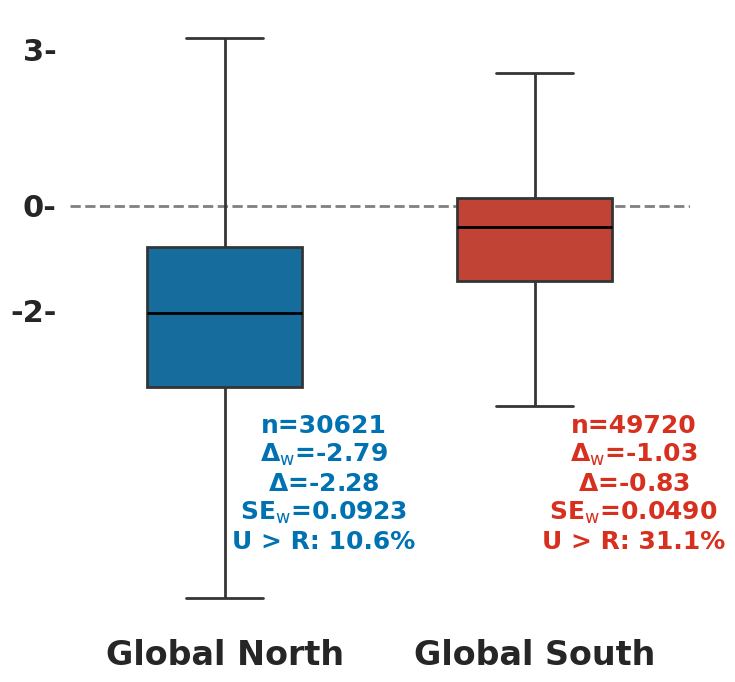

In [17]:
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import mannwhitneyu, ks_2samp

PCT_DECIMALS = 1  # decimals for the "U > R" line

# ────────────────────────────────────────────────────────────────────
# Helpers
# ────────────────────────────────────────────────────────────────────
def _safe_pct(series_bool: pd.Series) -> float:
    """100 * mean of a boolean Series; NaN if empty."""
    n = int(series_bool.size)
    if n == 0:
        return float("nan")
    return float(series_bool.mean() * 100.0)

def _kish_weighted_mean_se(x: np.ndarray, w: np.ndarray):
    """
    Kish-weighted mean and SE:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x − μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ w^2
      SE_w  = sqrt(Var_w / n_eff)
    Returns (mu_w, se_w, n_eff, n_raw, W_sum)
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0, 0.0)
    W = float(w.sum())
    mu_w = float(np.dot(w, x) / W)
    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    w2 = float(np.dot(w, w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return (mu_w, se_w, n_eff, n_raw, W)

def _ext_from_path(path: str) -> str:
    ext = os.path.splitext(path)[1].lower().strip(".")
    return ext if ext in {"png", "pdf", "svg"} else "pdf"

# ────────────────────────────────────────────────────────────────────
# Plotter — shows μ_w / μ / SE_w / n / U>R with subscript w notation
# ────────────────────────────────────────────────────────────────────
def _boxplot(df: pd.DataFrame,
             value_col: str,
             group_col: str,
             palette: dict,
             outfile: str,
             ann_stats: dict,
             pct_by_group: dict) -> None:
    """Two-box plot with fixed x-axis order: Global North | Global South."""
    if df.empty:
        raise ValueError("Nothing to plot – dataframe is empty.")

    plt.rcParams.update({'font.size': 24})
    sns.set(style="white")

    fig = plt.figure(figsize=(8, 8), facecolor="none")
    ax = sns.boxplot(
        x=group_col, y=value_col, data=df,
        order=['Global North', 'Global South'],
        palette=palette, width=0.5, showfliers=False,
        boxprops={'alpha': 1, 'linewidth': 2},
        whiskerprops={'linewidth': 2},
        capprops={'linewidth': 2},
        medianprops={'linewidth': 2, 'color': 'black'}
    )

    # y=0 reference
    ax.axhline(0, color='gray', linestyle='--', linewidth=2, zorder=0)

    # Y ticks: include 0, midpoint, top — labels with trailing "−"
    y_min, y_max = ax.get_ylim()
    y_mid = math.ceil((y_min + y_max) / 2)
    y_top = math.ceil(y_max) - 1

    new_min = min(y_min, 0)
    new_max = max(y_max, 0)
    if (new_min, new_max) != (y_min, y_max):
        ax.set_ylim(new_min, new_max)
        y_min, y_max = new_min, new_max
        y_mid = math.ceil((y_min + y_max) / 2)
        y_top = math.ceil(y_max) - 1

    ticks = sorted({y_mid, y_top, 0})
    labels = [f"{int(t)}-" for t in ticks]
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.yticks(fontsize=22, fontweight='bold')
    plt.xticks(fontsize=24, fontweight='bold')

    sns.despine(left=True, bottom=True, trim=True, offset=10)
    ax.set_xlabel(""); ax.set_ylabel("")

    # Annotation block fixed at y = –5 (extend axis if necessary)
    annot_y = -4
    if annot_y < y_min:
        ax.set_ylim(annot_y, y_max)

    # Per-group annotations (μ_w, μ, SE_w, n, U>R)
    for i, tick in enumerate(ax.get_xticklabels()):
        grp = tick.get_text()
        if grp in ann_stats:
            st = ann_stats[grp]
            pct = pct_by_group.get(grp, float('nan'))
            ann = (
                f"n={st['n_raw']}\n"
                r"$\boldsymbol{\Delta}_{\mathrm{w}}$" + f"={st['mu_w']:.2f}\n"
                r"$\boldsymbol{\Delta}$"               + f"={st['mu_simple']:.2f}\n"
                r"$\mathbf{SE}_{\mathrm{w}}$"       + f"={st['se_w']:.4f}\n"
                f"U > R: {pct:.{PCT_DECIMALS}f}%"
            )
            ax.text(i + 0.32, annot_y, ann,
                    ha='center', va='top',
                    fontsize=18, fontweight='bold',
                    color=palette[grp])

    # Save
    outdir = os.path.dirname(outfile)
    if outdir:
        os.makedirs(outdir, exist_ok=True)
    fig.savefig(outfile, bbox_inches='tight', format=_ext_from_path(outfile), dpi=400, transparent=True)
    print(f"Figure saved → {outfile}")
    plt.show()

# ────────────────────────────────────────────────────────────────────
# Core analysis
# ────────────────────────────────────────────────────────────────────
def analyse_all_cities(csv_path: str) -> pd.DataFrame:
    """Analyse Δtree-height for *all* valid cities in the CSV."""
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    base_req = ['meta_mean_urban', 'meta_mean_rural', 'GlobalNS', 'Urban_Area']
    # Rural weights may be provided as 'Rural_area' or 'Buffer_area'
    # We'll accept either; if neither exists, we fall back to Urban_Area only (still defined).
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        raise RuntimeError(f"Failed to read '{csv_path}': {e}")

    # Validate required metrics and group label
    for col in base_req:
        if col not in df.columns:
            raise ValueError(f"Required column missing: '{col}'")

    # Determine rural-area column if present
    rural_col = None
    if 'Rural_area' in df.columns:
        rural_col = 'Rural_area'
    elif 'Buffer_area' in df.columns:
        rural_col = 'Buffer_area'

    # Coerce numerics for relevant columns
    num_cols = ['meta_mean_urban', 'meta_mean_rural', 'Urban_Area'] + ([rural_col] if rural_col else [])
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    before = len(df)
    # Drop rows with any NaNs in required numeric fields (and rural_col if present)
    drop_cols = ['meta_mean_urban', 'meta_mean_rural', 'Urban_Area'] + ([rural_col] if rural_col else [])
    df.dropna(subset=drop_cols + ['GlobalNS'], inplace=True)
    # Positive area constraint on Urban_Area; if rural_col exists, require positive as well
    area_mask = (df['Urban_Area'] > 0)
    if rural_col:
        area_mask &= (df[rural_col] > 0)
    df = df[area_mask].copy()
    after = len(df)
    print(f"Valid rows after cleaning: {after:,} of {before:,}")
    if after == 0:
        raise ValueError("No valid data rows remain after cleaning.")

    # Δ tree height
    df['tree_height_diff'] = df['meta_mean_urban'] - df['meta_mean_rural']

    # Harmonize group labels
    df['GlobalNS'] = df['GlobalNS'].replace({'North': 'Global North',
                                             'South': 'Global South'})
    df = df[df['GlobalNS'].isin({'Global North', 'Global South'})]
    if df.empty:
        raise ValueError("No rows with Global North/South after harmonization.")

    # Build weights: Urban_Area + (Rural_area/Buffer_area if available)
    if rural_col:
        df['_w'] = df['Urban_Area'].to_numpy() + df[rural_col].to_numpy()
    else:
        # Fallback: use Urban_Area as both parts (documented in header)
        df['_w'] = df['Urban_Area'].to_numpy() + df['Urban_Area'].to_numpy()

    # Split groups
    north = df.loc[df['GlobalNS'] == 'Global North', 'tree_height_diff'].astype(float)
    south = df.loc[df['GlobalNS'] == 'Global South', 'tree_height_diff'].astype(float)

    # Console: tests and effect size (unweighted)
    try:
        mw_u, mw_p = mannwhitneyu(north, south, alternative='two-sided')
    except ValueError:
        mw_p = np.nan
    try:
        ks_s, ks_p = ks_2samp(north, south)
    except ValueError:
        ks_p = np.nan
    pooled_sd = math.sqrt((north.var(ddof=1) + south.var(ddof=1)) / 2) if (north.size > 1 and south.size > 1) else 0.0
    cohens_d = (north.mean() - south.mean()) / pooled_sd if pooled_sd else np.nan

    print("\n─ Statistics on urban − rural tree-height Δ (all cities) ─")
    print(f"Mann-Whitney U p-value : {mw_p:.4e}" if not np.isnan(mw_p) else "Mann-Whitney U p-value : n/a")
    print(f"Kolmogorov-Smirnov p   : {ks_p:.4e}" if not np.isnan(ks_p) else "Kolmogorov-Smirnov p   : n/a")
    print(f"Cohen’s d (effect size): {cohens_d:.3f}" if not np.isnan(cohens_d) else "Cohen’s d (effect size): n/a")

    # Annotation stats per group (Kish-weighted + simple mean)
    ann_stats = {}
    pct_by_group = {}
    for grp in ('Global North', 'Global South'):
        g = df.loc[df['GlobalNS'] == grp, ['tree_height_diff', '_w']].copy()
        x = g['tree_height_diff'].to_numpy(dtype=float)
        w = g['_w'].to_numpy(dtype=float)

        mu_w, se_w, n_eff, n_raw, W_sum = _kish_weighted_mean_se(x, w)
        mu_simple = float(np.nanmean(x)) if x.size else float('nan')

        ann_stats[grp] = {
            'n_raw': int(np.isfinite(x).sum()),
            'mu_w': float(mu_w),
            'se_w': float(se_w) if np.isfinite(se_w) else float('nan'),
            'mu_simple': mu_simple
        }
        pct_by_group[grp] = _safe_pct(pd.Series(x) > 0)

    # Plot
    palette = {'Global North': '#0072B2', 'Global South': '#d7301f'}
    outfig = '/content/Fig4C.pdf'
    _boxplot(df[['GlobalNS', 'tree_height_diff']], 'tree_height_diff',
             'GlobalNS', palette, outfig, ann_stats, pct_by_group)

    return df

# ────────────────────────────────────────────────────────────────────
# CLI
# ────────────────────────────────────────────────────────────────────
def main() -> None:
    csv_path = ('/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv')
    try:
        analyse_all_cities(csv_path)
    except FileNotFoundError as e:
        print(f"[ERROR] {e}", file=sys.stderr); sys.exit(1)
    except ValueError as e:
        print(f"[ERROR] {e}", file=sys.stderr); sys.exit(2)
    except Exception as e:
        print(f"[ERROR] Unexpected: {e}", file=sys.stderr); sys.exit(3)

if __name__ == "__main__":
    main()


# Climate Zones

In [18]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
from scipy.stats import f_oneway, wilcoxon

# ────────────────────────── CONFIG ──────────────────────────

CSV_PATH   = Path("/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv")
H_U_COL    = "meta_mean_urban"
H_R_COL    = "meta_mean_rural"
URBAN_AREA = "Urban_Area"
RURAL_AREA = "Buffer_area"
KOPPEN_COL = "koppen_name_urban"

TOP_N      = 1000
SAVE_DIR   = "/content/tree_height_climate_outputs"

# Standard 4-class Köppen mapping used elsewhere in your project
KOPPEN_MAP = {
    "A": "Tropical",
    "B": "Arid",
    "C": "Temperate",
    "D": "Continental",
}

CLIMATE_ORDER = ["Arid", "Tropical", "Temperate", "Continental"]

# ───────────────── Helper utilities ─────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def kish_weighted_mean_se(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float, int]:
    """
    Kish-style probability-weighted mean and SE.
    Returns (mu_w, se_w, n_eff, n_raw).
    """
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0)

    W = float(w.sum())
    if W <= 0:
        return (np.nan, np.nan, 0.0, n_raw)

    mu = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0

    var_w = float(np.dot(w, (x - mu) ** 2) / W)
    if not np.isfinite(var_w) or n_eff <= 0:
        return (mu, np.nan, n_eff, n_raw)

    se = float(math.sqrt(var_w / n_eff))
    return (mu, se, n_eff, n_raw)

def unweighted_mean_se(x: pd.Series) -> Tuple[float, float, int]:
    s = _coerce_num(x).dropna()
    n = int(s.size)
    if n == 0:
        return (np.nan, np.nan, 0)
    mu = float(s.mean())
    se = float(s.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return (mu, se, n)

def cohens_d_paired(diff: pd.Series) -> float:
    """
    Cohen's d for paired difference diff = (H_urban − H_rural) within a climate:
      d = mean(diff) / sd(diff)
    """
    d = _coerce_num(diff).dropna()
    n = int(d.size)
    if n < 2:
        return float("nan")
    mu = float(d.mean())
    sd = float(d.std(ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return float("nan")
    return float(mu / sd)

def _rank_biserial_from_wilcoxon(T: float, n: int) -> Optional[float]:
    """
    For Wilcoxon signed-rank:
      T = smaller of positive/negative rank sums (SciPy's wilcoxon statistic)
      R = n(n+1)/2
      r_rb = 1 - 2T/R
    """
    if not np.isfinite(T) or n <= 0:
        return None
    R = n * (n + 1) / 2.0
    if R <= 0:
        return None
    return 1.0 - (2.0 * T / R)

def fmt_pretty(v):
    if v is None:
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:,d}"
    if v == "":
        return ""
    return str(v)

# ────────────────────────── DATA PREP ──────────────────────

def prepare_df(csv_path: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path, low_memory=False)

    need = [H_U_COL, H_R_COL, URBAN_AREA, RURAL_AREA, KOPPEN_COL]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required column(s): {missing}")

    # Numerics
    for c in [H_U_COL, H_R_COL, URBAN_AREA, RURAL_AREA]:
        df[c] = _coerce_num(df[c])

    df = df.dropna(subset=[H_U_COL, H_R_COL, URBAN_AREA, RURAL_AREA])
    df = df[(df[URBAN_AREA] > 0) & (df[RURAL_AREA] > 0)].copy()
    if df.empty:
        raise ValueError("No valid rows after cleaning.")

    # Climate mapping from Koppen first letter
    def _map_climate(k):
        if not isinstance(k, str) or len(k) == 0:
            return None
        code = k[0].upper()
        return KOPPEN_MAP.get(code, None)

    df["Climate"] = df[KOPPEN_COL].apply(_map_climate)
    df = df[df["Climate"].isin(CLIMATE_ORDER)].copy()
    if df.empty:
        raise ValueError("No rows with valid Köppen classes after mapping.")

    # Working columns
    df["H_urban"] = df[H_U_COL]
    df["H_rural"] = df[H_R_COL]
    df["diff_ur"] = df["H_urban"] - df["H_rural"]
    df = df[np.isfinite(df["diff_ur"])].copy()

    return df

def subset_top_n(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if df.empty:
        return df
    n = min(n, len(df))
    # deterministic, keep ties
    return df.nlargest(n, URBAN_AREA, keep="all").copy()

# ───────────────────── CLIMATE STATS PER SCOPE ─────────────────────

def climate_stats(df: pd.DataFrame, scope: str, cohort_label: str) -> pd.DataFrame:
    """
    Per scope & climate:
      - Urban/Rural unweighted & Kish-weighted means
      - Δ, Δw, Cohen's d (paired on diff_ur)
      - Wilcoxon T, p, rank-biserial r for diff_ur vs 0
      - n
      - % U>R, % U<R, % U=R
    """
    rows: List[Dict] = []

    for clim in CLIMATE_ORDER:
        sub = df[df["Climate"] == clim]
        if sub.empty:
            continue

        # Unweighted
        mu_u, se_u, n_u = unweighted_mean_se(sub["H_urban"])
        mu_r, se_r, n_r = unweighted_mean_se(sub["H_rural"])

        # Kish-weighted (urban/rural)
        mu_u_w, se_u_w, _, _ = kish_weighted_mean_se(
            sub["H_urban"].to_numpy(), sub[URBAN_AREA].to_numpy()
        )
        mu_r_w, se_r_w, _, _ = kish_weighted_mean_se(
            sub["H_rural"].to_numpy(), sub[RURAL_AREA].to_numpy()
        )

        # Per-city difference & weights
        diff = _coerce_num(sub["diff_ur"]).dropna()
        n_diff = int(diff.size)

        w_diff = (sub[URBAN_AREA] + sub[RURAL_AREA])
        w_diff = _coerce_num(w_diff)
        # align with diff's index
        w_diff = w_diff.loc[diff.index]

        # Simple Δ (urban − rural)
        delta = float(mu_u - mu_r) if np.isfinite(mu_u) and np.isfinite(mu_r) else np.nan

        # Kish-weighted Δw on diff_ur using w_diff
        if n_diff > 0:
            delta_w, delta_se_w, _, _ = kish_weighted_mean_se(
                diff.to_numpy(), w_diff.to_numpy()
            )
        else:
            delta_w, delta_se_w = np.nan, np.nan  # delta_se_w kept internal only

        # Paired Cohen's d
        d_paired = cohens_d_paired(diff)

        # Wilcoxon signed-rank on diff vs 0 (paired U-R within climate)
        if n_diff >= 5 and np.any(diff != 0):
            try:
                T, p_w = wilcoxon(diff, zero_method="wilcox", alternative="two-sided")
            except Exception:
                T, p_w = (np.nan, np.nan)
        else:
            T, p_w = (np.nan, np.nan)

        # Rank-biserial r
        if np.isfinite(T) and n_diff > 0:
            r_rb = _rank_biserial_from_wilcoxon(float(T), n_diff)
        else:
            r_rb = None

        n_rows = int(sub.shape[0])

        # Percentages: U>R, U<R, U=R
        if n_diff > 0:
            pct_u_gt_r = float((diff > 0).mean() * 100.0)
            pct_u_lt_r = float((diff < 0).mean() * 100.0)
            pct_u_eq_r = float(np.isclose(diff, 0.0, atol=1e-6).mean() * 100.0)
        else:
            pct_u_gt_r = pct_u_lt_r = pct_u_eq_r = np.nan

        rows.append({
            "Variable": "Tree height",
            "Climate": clim,
            "Cohort": cohort_label,
            "Urban μ": mu_u,
            "Urban SE": se_u,
            "Urban μw": mu_u_w,
            "Urban SEw": se_u_w,
            "Rural μ": mu_r,
            "Rural SE": se_r,
            "Rural μw": mu_r_w,
            "Rural SEw": se_r_w,
            "Δ": delta,
            "Δw": delta_w,
            "Cohen's d": d_paired,
            "Rank-biserial r": r_rb if r_rb is not None else np.nan,
            "Test Statistic": T,
            "p-value": p_w,
            "n": n_rows,
            "% U>R": pct_u_gt_r,
            "% U<R": pct_u_lt_r,
            "% U=R": pct_u_eq_r,
            # ANOVA columns filled later
            "ANOVA F": np.nan,
            "ANOVA η²": np.nan,
            "ANOVA p-value": np.nan,
            "scope": scope,
        })

    return pd.DataFrame(rows)

# ───────────────────── ANOVA on diff_ur by climate ─────────────────────

def anova_diff_by_climate(df: pd.DataFrame) -> Dict[str, float]:
    """
    One-way ANOVA on diff_ur by Climate.
    Returns {F, eta2, p}.
    """
    vals = []

    for clim in CLIMATE_ORDER:
        sub = _coerce_num(df.loc[df["Climate"] == clim, "diff_ur"]).dropna()
        if sub.size > 1:
            vals.append(sub.to_numpy())

    if len(vals) < 2:
        return {"F": np.nan, "eta2": np.nan, "p": np.nan}

    # ANOVA (for F, p-value)
    try:
        F, p = f_oneway(*vals)
    except Exception:
        return {"F": np.nan, "eta2": np.nan, "p": np.nan}

    # Manual eta-squared
    all_vals = np.concatenate(vals)
    grand_mean = float(all_vals.mean())

    ss_between = 0.0
    ss_within = 0.0
    for arr in vals:
        m = float(arr.mean())
        ss_between += arr.size * (m - grand_mean) ** 2
        ss_within  += float(((arr - m) ** 2).sum())

    ss_total = ss_between + ss_within
    if ss_total <= 0 or not np.isfinite(ss_total):
        eta2 = np.nan
    else:
        eta2 = ss_between / ss_total

    return {"F": float(F), "eta2": float(eta2), "p": float(p)}

# ───────────────────── ASSEMBLE FINAL TABLE ─────────────────────

def build_summary_table(df_all: pd.DataFrame,
                        df_top: pd.DataFrame,
                        top_n: int,
                        have_top: bool) -> pd.DataFrame:
    rows = []

    # ALL cities
    stats_all = climate_stats(df_all, scope="ALL", cohort_label="All cities")
    an_all = anova_diff_by_climate(df_all)
    stats_all["ANOVA F"] = an_all["F"]
    stats_all["ANOVA η²"] = an_all["eta2"]
    stats_all["ANOVA p-value"] = an_all["p"]
    rows.append(stats_all)

    # TOP_N
    if have_top:
        stats_top = climate_stats(df_top, scope=f"TOP_{top_n}", cohort_label="Major cities")
        an_top = anova_diff_by_climate(df_top)
        stats_top["ANOVA F"] = an_top["F"]
        stats_top["ANOVA η²"] = an_top["eta2"]
        stats_top["ANOVA p-value"] = an_top["p"]
        rows.append(stats_top)

    if not rows:
        raise RuntimeError("No climate summary rows generated.")

    summary_df = pd.concat(rows, ignore_index=True)

    # Column order aligned with veg-fraction script (+ Variable at front)
    summary_df = summary_df[[
        "Variable", "Climate", "Cohort",
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "Cohen's d", "Rank-biserial r",
        "Test Statistic", "p-value",
        "n",
        "% U>R", "% U<R", "% U=R",
        "ANOVA F", "ANOVA η²", "ANOVA p-value",
    ]]

    # Rounding: 4 d.p. for most numeric, 2 d.p. for percentages
    float_cols_4 = [
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "Cohen's d", "Rank-biserial r",
        "Test Statistic", "p-value",
        "ANOVA F", "ANOVA η²", "ANOVA p-value",
    ]
    for c in float_cols_4:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

    pct_cols = ["% U>R", "% U<R", "% U=R"]
    for c in pct_cols:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

    summary_df["n"] = pd.to_numeric(summary_df["n"], errors="coerce").astype("Int64")

    return summary_df

# ────────────────────────── RUN ───────────────────────────

def _run(csv_path: Path, top_n: int, save_dir: str | None):
    df_all = prepare_df(csv_path)
    print(f"[OK] Loaded {df_all.shape[0]:,} rows after cleaning (tree height × climate).")

    df_top = subset_top_n(df_all, top_n)
    have_top = not df_top.empty
    if have_top:
        print(f"[OK] TOP_{top_n} subset size: {df_top.shape[0]:,} rows.")
    else:
        print(f"[WARN] TOP_{top_n} subset empty; only All cities will be reported.")

    summary_df = build_summary_table(df_all, df_top, top_n, have_top)

    # Pretty print
    fmt = {col: (lambda v, _c=col: fmt_pretty(v)) for col in summary_df.columns}
    print("\n=== TREE HEIGHT × CLIMATE SUMMARY TABLE ===")
    print(summary_df.to_string(index=False, formatters=fmt))

    # CSV for copy/paste & downstream use
    if save_dir:
        out = Path(save_dir)
        out.mkdir(parents=True, exist_ok=True)
        out_csv = out / "tree_height_climate_summary_table.csv"
        summary_df.to_csv(out_csv, index=False, float_format="%.4f", na_rep="")
        print(f"[OK] Saved tree_height_climate_summary_table.csv to: {out_csv.resolve()}")

if __name__ == "__main__":
    try:
        _run(CSV_PATH, TOP_N, SAVE_DIR)
    except (FileNotFoundError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise


[OK] Loaded 82,790 rows after cleaning (tree height × climate).
[OK] TOP_1000 subset size: 1,000 rows.

=== TREE HEIGHT × CLIMATE SUMMARY TABLE ===
   Variable     Climate       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Rank-biserial r Test Statistic p-value      n   % U>R   % U<R  % U=R   ANOVA F ANOVA η² ANOVA p-value
Tree height        Arid   All cities  2.4528   0.0150   2.7431    0.0890  2.4029   0.0154   2.7357    0.0950  0.0499 -0.0150    0.0381          0.2292  33442815.0000  0.0000 13,173 50.3800 41.7800 7.8400 4263.2631   0.1338        0.0000
Tree height    Tropical   All cities  2.9688   0.0163   3.0355    0.0960  3.6722   0.0219   4.0560    0.1441 -0.7034 -1.0287   -0.4889          0.5762  11473599.0000  0.0000 10,406 29.3500 70.2900 0.3700 4263.2631   0.1338        0.0000
Tree height   Temperate   All cities  3.0148   0.0082   3.3847    0.0518  4.7491   0.0137   5.6435    0.0932 -1.7342 -2.3099   -0.8609       

In [19]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
from scipy.stats import f_oneway, wilcoxon

# ────────────────────────── CONFIG ──────────────────────────

CSV_PATH   = Path("/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv")
H_U_COL    = "meta_mean_urban"
H_R_COL    = "meta_mean_rural"
URBAN_AREA = "Urban_Area"
RURAL_AREA = "Buffer_area"
KOPPEN_COL = "koppen_name_urban"

TOP_N      = 1000
SAVE_DIR   = "/content/tree_height_climate_outputs"

# Standard 4-class Köppen mapping used elsewhere in your project
KOPPEN_MAP = {
    "A": "Tropical",
    "B": "Arid",
    "C": "Temperate",
    "D": "Continental",
}

CLIMATE_ORDER = ["Arid", "Tropical", "Temperate", "Continental"]

# ───────────────── Helper utilities ─────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def kish_weighted_mean_se(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float, int]:
    """
    Kish-style probability-weighted mean and SE.
    Returns (mu_w, se_w, n_eff, n_raw).
    """
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0)

    W = float(w.sum())
    if W <= 0:
        return (np.nan, np.nan, 0.0, n_raw)

    mu = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0

    var_w = float(np.dot(w, (x - mu) ** 2) / W)
    if not np.isfinite(var_w) or n_eff <= 0:
        return (mu, np.nan, n_eff, n_raw)

    se = float(math.sqrt(var_w / n_eff))
    return (mu, se, n_eff, n_raw)

def unweighted_mean_se(x: pd.Series) -> Tuple[float, float, int]:
    s = _coerce_num(x).dropna()
    n = int(s.size)
    if n == 0:
        return (np.nan, np.nan, 0)
    mu = float(s.mean())
    se = float(s.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return (mu, se, n)

def cohens_d_paired(diff: pd.Series) -> float:
    """
    Cohen's d for paired difference diff = (H_urban − H_rural) within a climate:
      d = mean(diff) / sd(diff)
    """
    d = _coerce_num(diff).dropna()
    n = int(d.size)
    if n < 2:
        return float("nan")
    mu = float(d.mean())
    sd = float(d.std(ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return float("nan")
    return float(mu / sd)

def _rank_biserial_from_diff(diff: pd.Series) -> float:
    """
    CORRECTED: Signed rank-biserial correlation for paired differences (Urban − Rural):

        r_rb = (R_pos - R_neg) / (R_pos + R_neg)

    where ranks are on |diff| excluding zeros.

    Interpretation:
      - Positive r_rb ⇒ Urban > Rural effect dominates
      - Negative r_rb ⇒ Rural > Urban effect dominates
      - Magnitude indicates effect size (0 to ±1)

    This is the standard, robust formula that directly computes the effect
    without relying on scipy's Wilcoxon T statistic conventions.
    """
    d = _coerce_num(diff)
    d = d[d != 0].dropna()
    n = int(d.size)
    if n == 0:
        return float("nan")

    # Rank absolute differences
    ranks = d.abs().rank(method="average")
    R_pos = float(ranks[d > 0].sum())
    R_neg = float(ranks[d < 0].sum())
    R_tot = R_pos + R_neg

    if R_tot <= 0:
        return float("nan")

    return float((R_pos - R_neg) / R_tot)

def fmt_pretty(v):
    if v is None:
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:,d}"
    if v == "":
        return ""
    return str(v)

# ────────────────────────── DATA PREP ──────────────────────

def prepare_df(csv_path: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path, low_memory=False)

    need = [H_U_COL, H_R_COL, URBAN_AREA, RURAL_AREA, KOPPEN_COL]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required column(s): {missing}")

    # Numerics
    for c in [H_U_COL, H_R_COL, URBAN_AREA, RURAL_AREA]:
        df[c] = _coerce_num(df[c])

    df = df.dropna(subset=[H_U_COL, H_R_COL, URBAN_AREA, RURAL_AREA])
    df = df[(df[URBAN_AREA] > 0) & (df[RURAL_AREA] > 0)].copy()
    if df.empty:
        raise ValueError("No valid rows after cleaning.")

    # Climate mapping from Koppen first letter
    def _map_climate(k):
        if not isinstance(k, str) or len(k) == 0:
            return None
        code = k[0].upper()
        return KOPPEN_MAP.get(code, None)

    df["Climate"] = df[KOPPEN_COL].apply(_map_climate)
    df = df[df["Climate"].isin(CLIMATE_ORDER)].copy()
    if df.empty:
        raise ValueError("No rows with valid Köppen classes after mapping.")

    # Working columns
    df["H_urban"] = df[H_U_COL]
    df["H_rural"] = df[H_R_COL]
    df["diff_ur"] = df["H_urban"] - df["H_rural"]
    df = df[np.isfinite(df["diff_ur"])].copy()

    return df

def subset_top_n(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if df.empty:
        return df
    n = min(n, len(df))
    # deterministic, keep ties
    return df.nlargest(n, URBAN_AREA, keep="all").copy()

# ───────────────────── CLIMATE STATS PER SCOPE ─────────────────────

def climate_stats(df: pd.DataFrame, scope: str, cohort_label: str) -> pd.DataFrame:
    """
    Per scope & climate:
      - Urban/Rural unweighted & Kish-weighted means
      - Δ, Δw, Cohen's d (paired on diff_ur)
      - Wilcoxon T, p, rank-biserial r for diff_ur vs 0
      - n
      - % U>R, % U<R, % U=R
    """
    rows: List[Dict] = []

    for clim in CLIMATE_ORDER:
        sub = df[df["Climate"] == clim]
        if sub.empty:
            continue

        # Unweighted
        mu_u, se_u, n_u = unweighted_mean_se(sub["H_urban"])
        mu_r, se_r, n_r = unweighted_mean_se(sub["H_rural"])

        # Kish-weighted (urban/rural)
        mu_u_w, se_u_w, _, _ = kish_weighted_mean_se(
            sub["H_urban"].to_numpy(), sub[URBAN_AREA].to_numpy()
        )
        mu_r_w, se_r_w, _, _ = kish_weighted_mean_se(
            sub["H_rural"].to_numpy(), sub[RURAL_AREA].to_numpy()
        )

        # Per-city difference & weights
        diff = _coerce_num(sub["diff_ur"]).dropna()
        n_diff = int(diff.size)

        w_diff = (sub[URBAN_AREA] + sub[RURAL_AREA])
        w_diff = _coerce_num(w_diff)
        # align with diff's index
        w_diff = w_diff.loc[diff.index]

        # Simple Δ (urban − rural)
        delta = float(mu_u - mu_r) if np.isfinite(mu_u) and np.isfinite(mu_r) else np.nan

        # Kish-weighted Δw on diff_ur using w_diff
        if n_diff > 0:
            delta_w, delta_se_w, _, _ = kish_weighted_mean_se(
                diff.to_numpy(), w_diff.to_numpy()
            )
        else:
            delta_w, delta_se_w = np.nan, np.nan  # delta_se_w kept internal only

        # Paired Cohen's d
        d_paired = cohens_d_paired(diff)

        # Wilcoxon signed-rank on diff vs 0 (paired U-R within climate)
        if n_diff >= 5 and np.any(diff != 0):
            try:
                T, p_w = wilcoxon(diff, zero_method="wilcox", alternative="two-sided")
            except Exception:
                T, p_w = (np.nan, np.nan)
        else:
            T, p_w = (np.nan, np.nan)

        # CORRECTED: Rank-biserial r using direct calculation
        r_rb = _rank_biserial_from_diff(diff) if n_diff > 0 else float("nan")

        n_rows = int(sub.shape[0])

        # Percentages: U>R, U<R, U=R
        if n_diff > 0:
            pct_u_gt_r = float((diff > 0).mean() * 100.0)
            pct_u_lt_r = float((diff < 0).mean() * 100.0)
            pct_u_eq_r = float(np.isclose(diff, 0.0, atol=1e-6).mean() * 100.0)
        else:
            pct_u_gt_r = pct_u_lt_r = pct_u_eq_r = np.nan

        rows.append({
            "Variable": "Tree height",
            "Climate": clim,
            "Cohort": cohort_label,
            "Urban μ": mu_u,
            "Urban SE": se_u,
            "Urban μw": mu_u_w,
            "Urban SEw": se_u_w,
            "Rural μ": mu_r,
            "Rural SE": se_r,
            "Rural μw": mu_r_w,
            "Rural SEw": se_r_w,
            "Δ": delta,
            "Δw": delta_w,
            "Cohen's d": d_paired,
            "Rank-biserial r": r_rb,
            "Test Statistic": T,
            "p-value": p_w,
            "n": n_rows,
            "% U>R": pct_u_gt_r,
            "% U<R": pct_u_lt_r,
            "% U=R": pct_u_eq_r,
            # ANOVA columns filled later
            "ANOVA F": np.nan,
            "ANOVA η²": np.nan,
            "ANOVA p-value": np.nan,
            "scope": scope,
        })

    return pd.DataFrame(rows)

# ───────────────────── ANOVA on diff_ur by climate ─────────────────────

def anova_diff_by_climate(df: pd.DataFrame) -> Dict[str, float]:
    """
    One-way ANOVA on diff_ur by Climate.
    Returns {F, eta2, p}.
    """
    vals = []

    for clim in CLIMATE_ORDER:
        sub = _coerce_num(df.loc[df["Climate"] == clim, "diff_ur"]).dropna()
        if sub.size > 1:
            vals.append(sub.to_numpy())

    if len(vals) < 2:
        return {"F": np.nan, "eta2": np.nan, "p": np.nan}

    # ANOVA (for F, p-value)
    try:
        F, p = f_oneway(*vals)
    except Exception:
        return {"F": np.nan, "eta2": np.nan, "p": np.nan}

    # Manual eta-squared
    all_vals = np.concatenate(vals)
    grand_mean = float(all_vals.mean())

    ss_between = 0.0
    ss_within = 0.0
    for arr in vals:
        m = float(arr.mean())
        ss_between += arr.size * (m - grand_mean) ** 2
        ss_within  += float(((arr - m) ** 2).sum())

    ss_total = ss_between + ss_within
    if ss_total <= 0 or not np.isfinite(ss_total):
        eta2 = np.nan
    else:
        eta2 = ss_between / ss_total

    return {"F": float(F), "eta2": float(eta2), "p": float(p)}

# ───────────────────── ASSEMBLE FINAL TABLE ─────────────────────

def build_summary_table(df_all: pd.DataFrame,
                        df_top: pd.DataFrame,
                        top_n: int,
                        have_top: bool) -> pd.DataFrame:
    rows = []

    # ALL cities
    stats_all = climate_stats(df_all, scope="ALL", cohort_label="All cities")
    an_all = anova_diff_by_climate(df_all)
    stats_all["ANOVA F"] = an_all["F"]
    stats_all["ANOVA η²"] = an_all["eta2"]
    stats_all["ANOVA p-value"] = an_all["p"]
    rows.append(stats_all)

    # TOP_N
    if have_top:
        stats_top = climate_stats(df_top, scope=f"TOP_{top_n}", cohort_label="Major cities")
        an_top = anova_diff_by_climate(df_top)
        stats_top["ANOVA F"] = an_top["F"]
        stats_top["ANOVA η²"] = an_top["eta2"]
        stats_top["ANOVA p-value"] = an_top["p"]
        rows.append(stats_top)

    if not rows:
        raise RuntimeError("No climate summary rows generated.")

    summary_df = pd.concat(rows, ignore_index=True)

    # Column order aligned with veg-fraction script (+ Variable at front)
    summary_df = summary_df[[
        "Variable", "Climate", "Cohort",
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "Cohen's d", "Rank-biserial r",
        "Test Statistic", "p-value",
        "n",
        "% U>R", "% U<R", "% U=R",
        "ANOVA F", "ANOVA η²", "ANOVA p-value",
    ]]

    # Rounding: 4 d.p. for most numeric, 2 d.p. for percentages
    float_cols_4 = [
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "Cohen's d", "Rank-biserial r",
        "Test Statistic", "p-value",
        "ANOVA F", "ANOVA η²", "ANOVA p-value",
    ]
    for c in float_cols_4:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

    pct_cols = ["% U>R", "% U<R", "% U=R"]
    for c in pct_cols:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

    summary_df["n"] = pd.to_numeric(summary_df["n"], errors="coerce").astype("Int64")

    return summary_df

# ────────────────────────── RUN ───────────────────────────

def _run(csv_path: Path, top_n: int, save_dir: str | None):
    df_all = prepare_df(csv_path)
    print(f"[OK] Loaded {df_all.shape[0]:,} rows after cleaning (tree height × climate).")

    df_top = subset_top_n(df_all, top_n)
    have_top = not df_top.empty
    if have_top:
        print(f"[OK] TOP_{top_n} subset size: {df_top.shape[0]:,} rows.")
    else:
        print(f"[WARN] TOP_{top_n} subset empty; only All cities will be reported.")

    summary_df = build_summary_table(df_all, df_top, top_n, have_top)

    # Pretty print
    fmt = {col: (lambda v, _c=col: fmt_pretty(v)) for col in summary_df.columns}
    print("\n=== TREE HEIGHT × CLIMATE SUMMARY TABLE ===")
    print(summary_df.to_string(index=False, formatters=fmt))

    # CSV for copy/paste & downstream use
    if save_dir:
        out = Path(save_dir)
        out.mkdir(parents=True, exist_ok=True)
        out_csv = out / "tree_height_climate_summary_table.csv"
        summary_df.to_csv(out_csv, index=False, float_format="%.4f", na_rep="")
        print(f"[OK] Saved tree_height_climate_summary_table.csv to: {out_csv.resolve()}")

if __name__ == "__main__":
    try:
        _run(CSV_PATH, TOP_N, SAVE_DIR)
    except (FileNotFoundError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

[OK] Loaded 82,790 rows after cleaning (tree height × climate).
[OK] TOP_1000 subset size: 1,000 rows.

=== TREE HEIGHT × CLIMATE SUMMARY TABLE ===
   Variable     Climate       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Rank-biserial r Test Statistic p-value      n   % U>R   % U<R  % U=R   ANOVA F ANOVA η² ANOVA p-value
Tree height        Arid   All cities  2.4528   0.0150   2.7431    0.0890  2.4029   0.0154   2.7357    0.0950  0.0499 -0.0150    0.0381          0.0924  33442815.0000  0.0000 13,173 50.3800 41.7800 7.8400 4263.2631   0.1338        0.0000
Tree height    Tropical   All cities  2.9688   0.0163   3.0355    0.0960  3.6722   0.0219   4.0560    0.1441 -0.7034 -1.0287   -0.4889         -0.5731  11473599.0000  0.0000 10,406 29.3500 70.2900 0.3700 4263.2631   0.1338        0.0000
Tree height   Temperate   All cities  3.0148   0.0082   3.3847    0.0518  4.7491   0.0137   5.6435    0.0932 -1.7342 -2.3099   -0.8609       

Valid rows after cleaning for plotting/weights: 81,705 of 83,102
  …including 1,587 cities with Urban tree-cover area == 0 (if other conditions met).


/tmp/ipython-input-4104698263.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


Saved RainCloud plot → /content/Fig_TreeHeight_Koppen_RainCloud.pdf


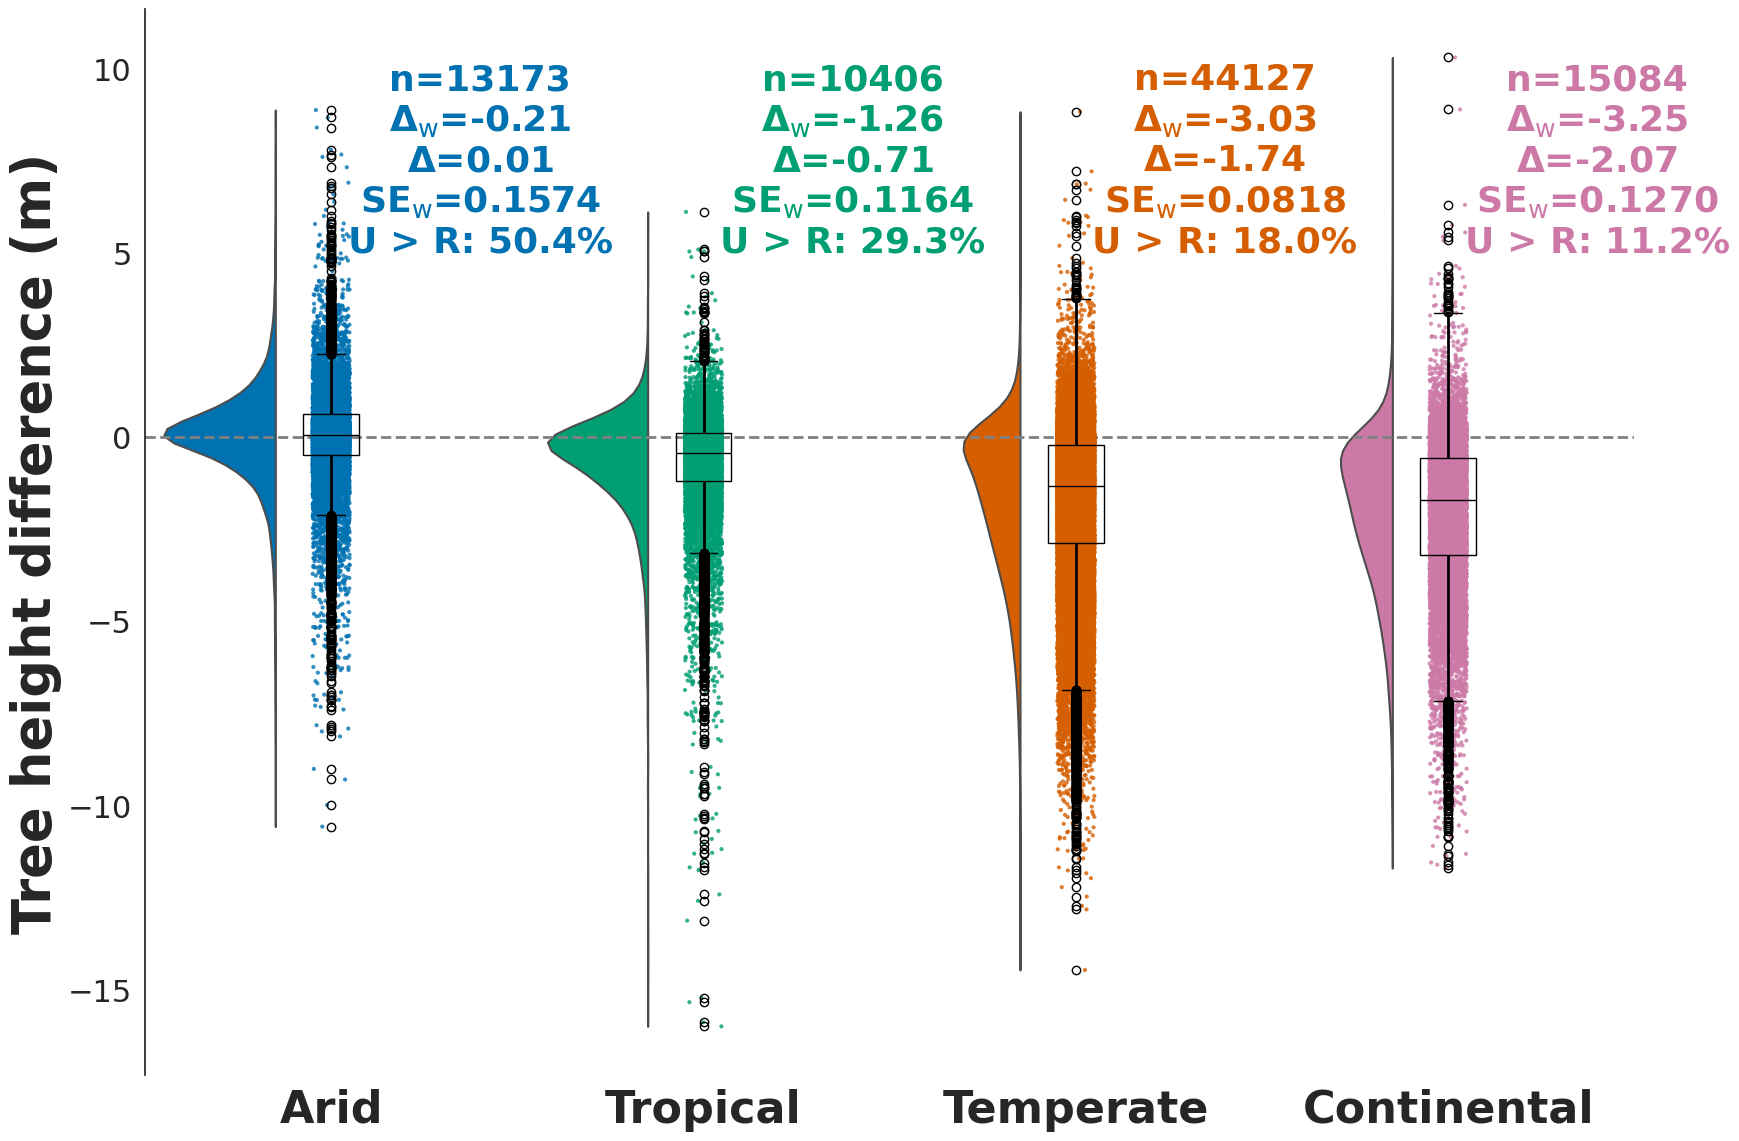

In [20]:
# ────────────────────────────────────────────────────────────────────
# IMPORTS
# ────────────────────────────────────────────────────────────────────
import os
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

# Geospatial optional
try:
    import geopandas as gpd  # noqa: F401
    from shapely.geometry import Point  # noqa: F401
except Exception:
    gpd = None

# ────────────────────────────────────────────────────────────────────
# SILENCE KNOWN FUTUREWARNINGS
# ────────────────────────────────────────────────────────────────────
warnings.filterwarnings(
    "ignore",
    message="The default of observed=False is deprecated",
    category=FutureWarning,
    module="seaborn"
)

# ────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ────────────────────────────────────────────────────────────────────
INPUT_CSV     = Path('/content/combinedFeatures_TreesBiomeKoppen_withLatLon_with_countries.csv')
OUTPUT_FIG    = Path('/content/Fig_TreeHeight_Koppen_RainCloud.pdf')
PCT_DECIMALS  = 1  # decimals for "U > R"

# ────────────────────────────────────────────────────────────────────
# HELPERS
# ────────────────────────────────────────────────────────────────────
def _safe_pct(series_bool: pd.Series) -> float:
    """Return 100 * mean of a boolean Series; NaN if empty."""
    n = int(series_bool.size)
    if n == 0:
        return float("nan")
    return float(series_bool.mean() * 100.0)

def _kish_weighted_mean_se(x: np.ndarray, w: np.ndarray):
    """
    Kish weighting:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x − μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ w^2
      SE_w  = sqrt(Var_w / n_eff)

    Returns (mu_w, se_w, n_eff, n_raw, W_sum)
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    mask = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[mask], w[mask]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0, 0.0)
    W = float(w.sum())
    mu_w = float(np.dot(w, x) / W)
    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    w2 = float(np.dot(w, w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return (mu_w, se_w, n_eff, n_raw, W)

def _norm(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '', str(s).strip().lower())

def _resolve_column(df: pd.DataFrame, candidates, required=True, label=""):
    """
    Resolve a column name in `df` from a list of candidate names using
    normalized matching and fuzzy 'contains' logic.
    """
    if isinstance(candidates, str):
        candidates = [candidates]
    norm_map = {_norm(c): c for c in df.columns}

    # Exact normalized match
    for cand in candidates:
        key = _norm(cand)
        if key in norm_map:
            return norm_map[key]

    # Fuzzy "contains" match
    for c in df.columns:
        nc = _norm(c)
        for cand in candidates:
            if _norm(cand) in nc:
                return c

    if required:
        raise KeyError(
            f"Required column not found for {label or candidates}. "
            f"Available (first 30): {df.columns[:30].tolist()}"
        )
    return None

# ────────────────────────────────────────────────────────────────────
# LOAD DATA (BASE DF FOR U>R AND ORIGINAL n)
# ────────────────────────────────────────────────────────────────────
if not INPUT_CSV.is_file():
    raise FileNotFoundError(f"CSV not found: {INPUT_CSV}")

try:
    data_full = pd.read_csv(INPUT_CSV, low_memory=False)
except Exception as e:
    raise IOError(f"Error reading CSV file '{INPUT_CSV}': {e}")

# Resolve height columns (prefer META, fall back to GLAD/ETH/GLOFAB)
h_u = _resolve_column(
    data_full,
    ["meta_mean_urban", "glad_mean_urban", "eth_mean_urban", "glofab_mean_urban"],
    label="Urban tree height (mean)"
)
h_r = _resolve_column(
    data_full,
    ["meta_mean_rural", "glad_mean_rural", "eth_mean_rural", "glofab_mean_rural"],
    label="Rural tree height (mean)"
)

# Resolve Köppen (prefer urban; fall back to generic)
kop = _resolve_column(data_full, ["koppen_name_urban", "koppen_name"], label="Köppen class")

# Coerce numerics for heights
for c in (h_u, h_r):
    data_full[c] = pd.to_numeric(data_full[c], errors='coerce')

# Base DF: matches summary-table logic (heights + climate only)
base = data_full.dropna(subset=[h_u, h_r, kop]).copy()
base["H_urban"] = base[h_u].astype(float)
base["H_rural"] = base[h_r].astype(float)
base["H_diff"]  = base["H_urban"] - base["H_rural"]

koppen_map = {'A': 'Tropical', 'B': 'Arid', 'C': 'Temperate', 'D': 'Continental'}
base['koppen_class'] = base[kop].astype(str).str[0].map(koppen_map)
base = base.dropna(subset=['koppen_class']).copy()

if base.empty:
    raise ValueError("No rows with valid heights and Köppen classes for U>R computation.")

# Compute U>R and original n per Köppen class
u_gt_r_pct = {}
n_all_per_class = {}
for cls, sub_cls in base.groupby('koppen_class'):
    diff = pd.to_numeric(sub_cls["H_diff"], errors="coerce").dropna()
    n_all_per_class[cls] = int(diff.size)
    if diff.size == 0:
        u_gt_r_pct[cls] = float("nan")
    else:
        u_gt_r_pct[cls] = float((diff > 0).mean() * 100.0)

# ────────────────────────────────────────────────────────────────────
# BUILD SUBSET FOR PLOTTING & WEIGHTED STATS
# ────────────────────────────────────────────────────────────────────
# Resolve tree-cover areas (weights) on full DF
tca_u = _resolve_column(data_full, "tree_cover_area_urban", label="Urban tree-cover area")
tca_r = _resolve_column(data_full, "tree_cover_area_rural", label="Rural tree-cover area")

for c in (tca_u, tca_r):
    data_full[c] = pd.to_numeric(data_full[c], errors='coerce')

before = len(data_full)
# Require heights, tree-cover areas, Köppen for plotting/weights
data = data_full.dropna(subset=[h_u, h_r, tca_u, tca_r, kop]).copy()

# Include urban tree-cover area == 0, but require rural tree-cover area > 0
n_zero_urban_before = (data[tca_u] == 0).sum()
data = data[(data[tca_r] > 0) & (data[tca_u] >= 0)].copy()
after = len(data)

print(f"Valid rows after cleaning for plotting/weights: {after:,} of {before:,}")
print(f"  …including {n_zero_urban_before:,} cities with Urban tree-cover area == 0 (if other conditions met).")

if data.empty:
    raise ValueError("No valid rows after filtering heights and tree-cover weights (rural > 0).")

# Height difference and weights
data["height_diff"] = data[h_u] - data[h_r]
data["w_diff"]      = data[tca_u] + data[tca_r]

# Map Köppen for this subset
data['koppen_class'] = data[kop].astype(str).str[0].map(koppen_map)
data = data.dropna(subset=['koppen_class']).copy()

if data.empty:
    raise ValueError("No rows map to Köppen classes A/B/C/D after filtering for plotting.")

# ────────────────────────────────────────────────────────────────────
# ORDERED CATEGORIES: Arid, Tropical, Temperate, Continental
# ────────────────────────────────────────────────────────────────────
desired_order = ['Arid', 'Tropical', 'Temperate', 'Continental']
present = [c for c in desired_order if c in data['koppen_class'].unique()]
categories = present

data.loc[:, 'koppen_class'] = pd.Categorical(
    data['koppen_class'],
    categories=categories,
    ordered=True
)

# ────────────────────────────────────────────────────────────────────
# PLOTTING
# ────────────────────────────────────────────────────────────────────
plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(figsize=(18, 12))

palette = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
if len(categories) > len(palette):
    palette = sns.color_palette("colorblind", n_colors=len(categories))

pt.half_violinplot(
    x='koppen_class', y='height_diff', data=data,
    palette=palette, bw=.2, cut=0, scale="area",
    width=.6, inner=None, orient='v',
    order=categories, ax=ax
)

sns.boxplot(
    x='koppen_class', y='height_diff', data=data,
    width=.15, showcaps=True,
    boxprops={'facecolor': 'none'},
    whiskerprops={'linewidth': 2},
    color='black', zorder=10,
    order=categories, ax=ax
)

sns.stripplot(
    x='koppen_class', y='height_diff', data=data,
    palette=palette, jitter=0.05, size=3,
    alpha=0.8, orient='v',
    order=categories, ax=ax
)

ax.axhline(0, color='gray', linestyle='--', linewidth=2)
ax.grid(False)
for spine in ('bottom', 'top', 'right'):
    ax.spines[spine].set_visible(False)

ax.set_ylabel('Tree height difference (m)', fontsize=38, fontweight='bold')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0, labelsize=32)
ax.tick_params(axis='y', labelsize=22)
plt.setp(ax.get_xticklabels(), fontweight='bold')

# ────────────────────────────────────────────────────────────────────
# ANNOTATIONS — Kish Δ_w / SE_w + simple Δ,
# n = ORIGINAL n (all valid heights), U>R from summary logic
# ────────────────────────────────────────────────────────────────────
ymin, ymax = ax.get_ylim()
y_text = ymax - 0.05 * (ymax - ymin)

for i, cls in enumerate(categories):
    sub = data.loc[data['koppen_class'] == cls, :].copy()

    x = pd.to_numeric(sub['height_diff'], errors='coerce').to_numpy()
    w = pd.to_numeric(sub['w_diff'],       errors='coerce').to_numpy()

    mu_w, se_w, n_eff, n_raw_weighted, W_sum = _kish_weighted_mean_se(x, w)
    mu_simple = float(np.nanmean(x)) if x.size else float('nan')

    # ORIGINAL n (like summary table): all cities with valid heights in this class
    n_all = n_all_per_class.get(cls, 0)
    # U>R from base (all valid heights)
    upr = u_gt_r_pct.get(cls, float("nan"))

    ann = (
        f"n={n_all}\n"
        r"$\boldsymbol{\Delta}_{\mathrm{w}}$" + f"={mu_w:.2f}\n"
        r"$\boldsymbol{\Delta}$"               + f"={mu_simple:.2f}\n"
        r"$\mathbf{SE}_{\mathrm{w}}$"          + f"={se_w:.4f}\n"
        f"U > R: {upr:.{PCT_DECIMALS}f}%"
    )

    ax.text(
        i + 0.40, y_text, ann,
        ha='center', va='top',
        fontsize=26, fontweight='bold',
        color=palette[i]
    )

plt.tight_layout()

# ────────────────────────────────────────────────────────────────────
# SAVE
# ────────────────────────────────────────────────────
OUTPUT_FIG.parent.mkdir(parents=True, exist_ok=True)
fig_format = os.path.splitext(str(OUTPUT_FIG))[-1].lower().strip('.') or 'pdf'

try:
    fig.savefig(OUTPUT_FIG, format=fig_format, bbox_inches='tight', dpi=300, transparent=True)
    print(f"Saved RainCloud plot → {OUTPUT_FIG}")
except Exception as e:
    raise IOError(f"Error saving figure to '{OUTPUT_FIG}': {e}")

plt.show()
